# Deep Convolutional Generative Adversarial Network

In [1]:
import os
import math
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import torchvision.transforms as transforms
from torchvision import datasets
from torchvision.utils import save_image
from torch.utils.data import DataLoader
from torch.autograd import Variable

In [3]:
import torch.nn as nn
import torch.nn.functional as F
import torch

## Set Arguments

In [4]:
num_workers = 0
n_epochs = 200
batch_size = 64
lr = 0.0002
beta1 = 0.5
beta2 = 0.999
n_cpu = 8
latent_dim = 100
img_size = 32
channels = 1
sample_interval = 400

In [5]:
cuda = True if torch.cuda.is_available() else False

## Configure Data Loader

In [6]:
os.makedirs("images/dcgan/", exist_ok=True)

In [7]:
data_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data',
                   train = True,
                   download = True,
                   transform=transforms.Compose(
                       [transforms.Resize(img_size), transforms.ToTensor(), transforms.Normalize([0.5], [0.5])]),
                   ),
                   batch_size = batch_size,
                   shuffle = True,
)

## Build DCGAN Architecture

<img src='images/dcgan-architecture.png' width='75%'/>

In [8]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find('conv') != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm2d') != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)

## Generator

In [9]:
class Generator(nn.Module):
    
    def __init__(self):
        super(Generator, self).__init__()
        
        self.init_size = img_size // 4
        self.l1 = nn.Sequential(nn.Linear(latent_dim, 128 * self.init_size ** 2))
        
        self.conv_blocks = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Upsample(scale_factor=2),
            nn.Conv2d(128, 64, 3, stride=1, padding=1),
            nn.BatchNorm2d(64, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, channels, 3, stride=1, padding=1),
            nn.Tanh(),
        )
        
    def forward(self, z):
        img = self.l1(z)
        img = img.view(img.shape[0], 128, self.init_size, self.init_size)
        img = self.conv_blocks(img)
        
        return img

## Discriminator

In [10]:
class Discriminator(nn.Module):
    
    def __init__(self):
        super(Discriminator, self).__init__()

        def discriminator_block(in_filters, out_filters, bnorm=True):
            block = [nn.Conv2d(in_filters, out_filters, 3, 2, 1), nn.LeakyReLU(0.2, inplace=True), nn.Dropout2d(0.25)]
            if bnorm:
                block.append(nn.BatchNorm2d(out_filters, 0.8))
            return block

        self.model = nn.Sequential(
            *discriminator_block(channels, 16, bnorm=False),
            *discriminator_block(16, 32),
            *discriminator_block(32, 64),
            *discriminator_block(64, 128),
        )

        # The height and width of downsampled image
        ds_size = img_size // 2 ** 4
        self.adv_layer = nn.Sequential(nn.Linear(128 * ds_size ** 2, 1), nn.Sigmoid())

    def forward(self, img):
        img = self.model(img)
        img = img.view(img.shape[0], -1)
        validity = self.adv_layer(img)

        return validity

#### Initialize the generator and discriminator

In [11]:
generator = Generator()
discriminator = Discriminator()
if cuda:
    generator.cuda()
    discriminator.cuda()

## Loss Function

In [12]:
adversarial_loss = nn.BCELoss()
if cuda: adversarial_loss.cuda()

## Optimizer

In [13]:
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(beta1, beta2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, beta2))

In [14]:
Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

## Training The [Network](https://arxiv.org/pdf/1511.06434)

#### Initialize weights

In [15]:
generator.apply(weights_init_normal)

Generator(
  (l1): Sequential(
    (0): Linear(in_features=100, out_features=8192, bias=True)
  )
  (conv_blocks): Sequential(
    (0): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Upsample(scale_factor=2.0, mode=nearest)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): BatchNorm2d(128, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Upsample(scale_factor=2.0, mode=nearest)
    (6): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): BatchNorm2d(64, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): Conv2d(64, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): Tanh()
  )
)

In [16]:
discriminator.apply(weights_init_normal)

Discriminator(
  (model): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout2d(p=0.25, inplace=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Dropout2d(p=0.25, inplace=False)
    (6): BatchNorm2d(32, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (7): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): Dropout2d(p=0.25, inplace=False)
    (10): BatchNorm2d(64, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (11): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (12): LeakyReLU(negative_slope=0.2, inplace=True)
    (13): Dropout2d(p=0.25, inplace=False)
    (14): BatchNorm2d(128, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
  )
  (adv_laye

In [17]:
def imshow(imgs, nrows=5):
    fig = plt.figure(figsize=(20,20))
    for idx in np.arange(25):
        ax = fig.add_subplot(5, 25/nrows, idx+1, xticks=[], yticks=[])
        plt.imshow(imgs[idx, :, :, 0], cmap='gray') # convert from Tensor image        

    plt.savefig('./images/dcgan/final_images.png')
    plt.show()

In [18]:
n_epochs = 10 # theoretically should be high

[Epoch 0/10] [Batch 0/938] [Generator loss: 0.689631] [Discriminator loss: 0.692307]


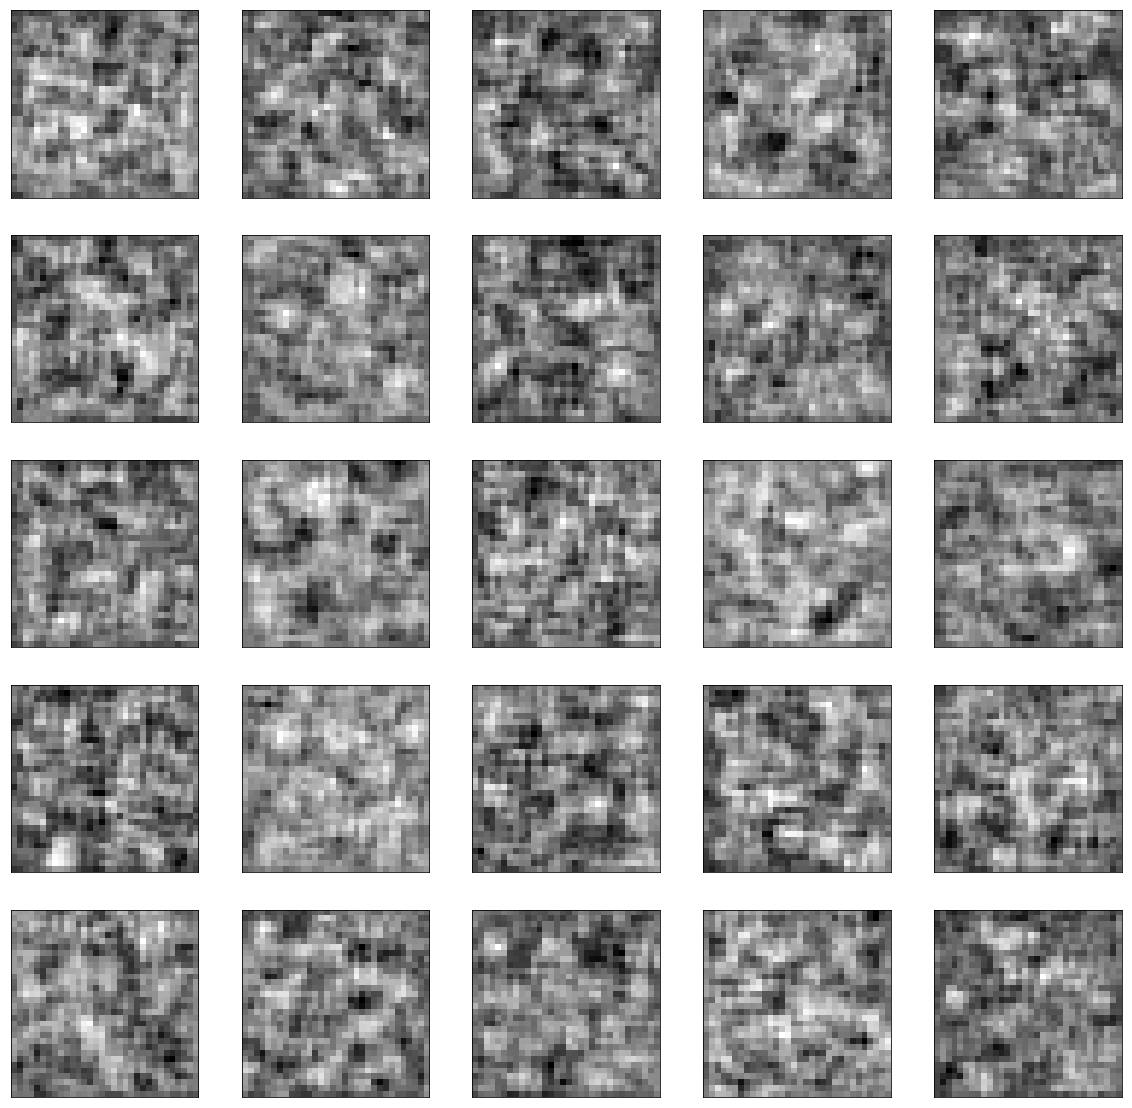

[Epoch 0/10] [Batch 1/938] [Generator loss: 0.690081] [Discriminator loss: 0.688799]
[Epoch 0/10] [Batch 2/938] [Generator loss: 0.690043] [Discriminator loss: 0.686892]
[Epoch 0/10] [Batch 3/938] [Generator loss: 0.690954] [Discriminator loss: 0.685220]
[Epoch 0/10] [Batch 4/938] [Generator loss: 0.691585] [Discriminator loss: 0.683913]
[Epoch 0/10] [Batch 5/938] [Generator loss: 0.691571] [Discriminator loss: 0.680079]
[Epoch 0/10] [Batch 6/938] [Generator loss: 0.691836] [Discriminator loss: 0.676561]
[Epoch 0/10] [Batch 7/938] [Generator loss: 0.691729] [Discriminator loss: 0.673438]
[Epoch 0/10] [Batch 8/938] [Generator loss: 0.691805] [Discriminator loss: 0.671163]
[Epoch 0/10] [Batch 9/938] [Generator loss: 0.689456] [Discriminator loss: 0.665210]
[Epoch 0/10] [Batch 10/938] [Generator loss: 0.688491] [Discriminator loss: 0.663314]
[Epoch 0/10] [Batch 11/938] [Generator loss: 0.686734] [Discriminator loss: 0.661520]
[Epoch 0/10] [Batch 12/938] [Generator loss: 0.682670] [Discrim

[Epoch 0/10] [Batch 98/938] [Generator loss: 0.664317] [Discriminator loss: 0.688849]
[Epoch 0/10] [Batch 99/938] [Generator loss: 0.689764] [Discriminator loss: 0.688187]
[Epoch 0/10] [Batch 100/938] [Generator loss: 0.690075] [Discriminator loss: 0.681111]
[Epoch 0/10] [Batch 101/938] [Generator loss: 0.685546] [Discriminator loss: 0.687565]
[Epoch 0/10] [Batch 102/938] [Generator loss: 0.657826] [Discriminator loss: 0.684062]
[Epoch 0/10] [Batch 103/938] [Generator loss: 0.670497] [Discriminator loss: 0.682870]
[Epoch 0/10] [Batch 104/938] [Generator loss: 0.675683] [Discriminator loss: 0.687906]
[Epoch 0/10] [Batch 105/938] [Generator loss: 0.673146] [Discriminator loss: 0.680659]
[Epoch 0/10] [Batch 106/938] [Generator loss: 0.669233] [Discriminator loss: 0.685829]
[Epoch 0/10] [Batch 107/938] [Generator loss: 0.645152] [Discriminator loss: 0.688062]
[Epoch 0/10] [Batch 108/938] [Generator loss: 0.668311] [Discriminator loss: 0.682972]
[Epoch 0/10] [Batch 109/938] [Generator loss:

[Epoch 0/10] [Batch 198/938] [Generator loss: 0.697948] [Discriminator loss: 0.693400]
[Epoch 0/10] [Batch 199/938] [Generator loss: 0.715170] [Discriminator loss: 0.694632]
[Epoch 0/10] [Batch 200/938] [Generator loss: 0.707283] [Discriminator loss: 0.693113]
[Epoch 0/10] [Batch 201/938] [Generator loss: 0.691715] [Discriminator loss: 0.685125]
[Epoch 0/10] [Batch 202/938] [Generator loss: 0.698536] [Discriminator loss: 0.689970]
[Epoch 0/10] [Batch 203/938] [Generator loss: 0.700906] [Discriminator loss: 0.689886]
[Epoch 0/10] [Batch 204/938] [Generator loss: 0.697904] [Discriminator loss: 0.688819]
[Epoch 0/10] [Batch 205/938] [Generator loss: 0.700519] [Discriminator loss: 0.709169]
[Epoch 0/10] [Batch 206/938] [Generator loss: 0.713186] [Discriminator loss: 0.699384]
[Epoch 0/10] [Batch 207/938] [Generator loss: 0.693897] [Discriminator loss: 0.695617]
[Epoch 0/10] [Batch 208/938] [Generator loss: 0.704901] [Discriminator loss: 0.698077]
[Epoch 0/10] [Batch 209/938] [Generator los

[Epoch 0/10] [Batch 297/938] [Generator loss: 0.692334] [Discriminator loss: 0.696196]
[Epoch 0/10] [Batch 298/938] [Generator loss: 0.680721] [Discriminator loss: 0.684823]
[Epoch 0/10] [Batch 299/938] [Generator loss: 0.677113] [Discriminator loss: 0.689815]
[Epoch 0/10] [Batch 300/938] [Generator loss: 0.678761] [Discriminator loss: 0.698816]
[Epoch 0/10] [Batch 301/938] [Generator loss: 0.677665] [Discriminator loss: 0.687956]
[Epoch 0/10] [Batch 302/938] [Generator loss: 0.662586] [Discriminator loss: 0.692101]
[Epoch 0/10] [Batch 303/938] [Generator loss: 0.685958] [Discriminator loss: 0.682122]
[Epoch 0/10] [Batch 304/938] [Generator loss: 0.685701] [Discriminator loss: 0.689970]
[Epoch 0/10] [Batch 305/938] [Generator loss: 0.676610] [Discriminator loss: 0.679068]
[Epoch 0/10] [Batch 306/938] [Generator loss: 0.674041] [Discriminator loss: 0.690379]
[Epoch 0/10] [Batch 307/938] [Generator loss: 0.682388] [Discriminator loss: 0.689889]
[Epoch 0/10] [Batch 308/938] [Generator los

[Epoch 0/10] [Batch 396/938] [Generator loss: 0.711013] [Discriminator loss: 0.685183]
[Epoch 0/10] [Batch 397/938] [Generator loss: 0.694654] [Discriminator loss: 0.691127]
[Epoch 0/10] [Batch 398/938] [Generator loss: 0.717787] [Discriminator loss: 0.688395]
[Epoch 0/10] [Batch 399/938] [Generator loss: 0.703403] [Discriminator loss: 0.692455]
[Epoch 0/10] [Batch 400/938] [Generator loss: 0.725695] [Discriminator loss: 0.683980]


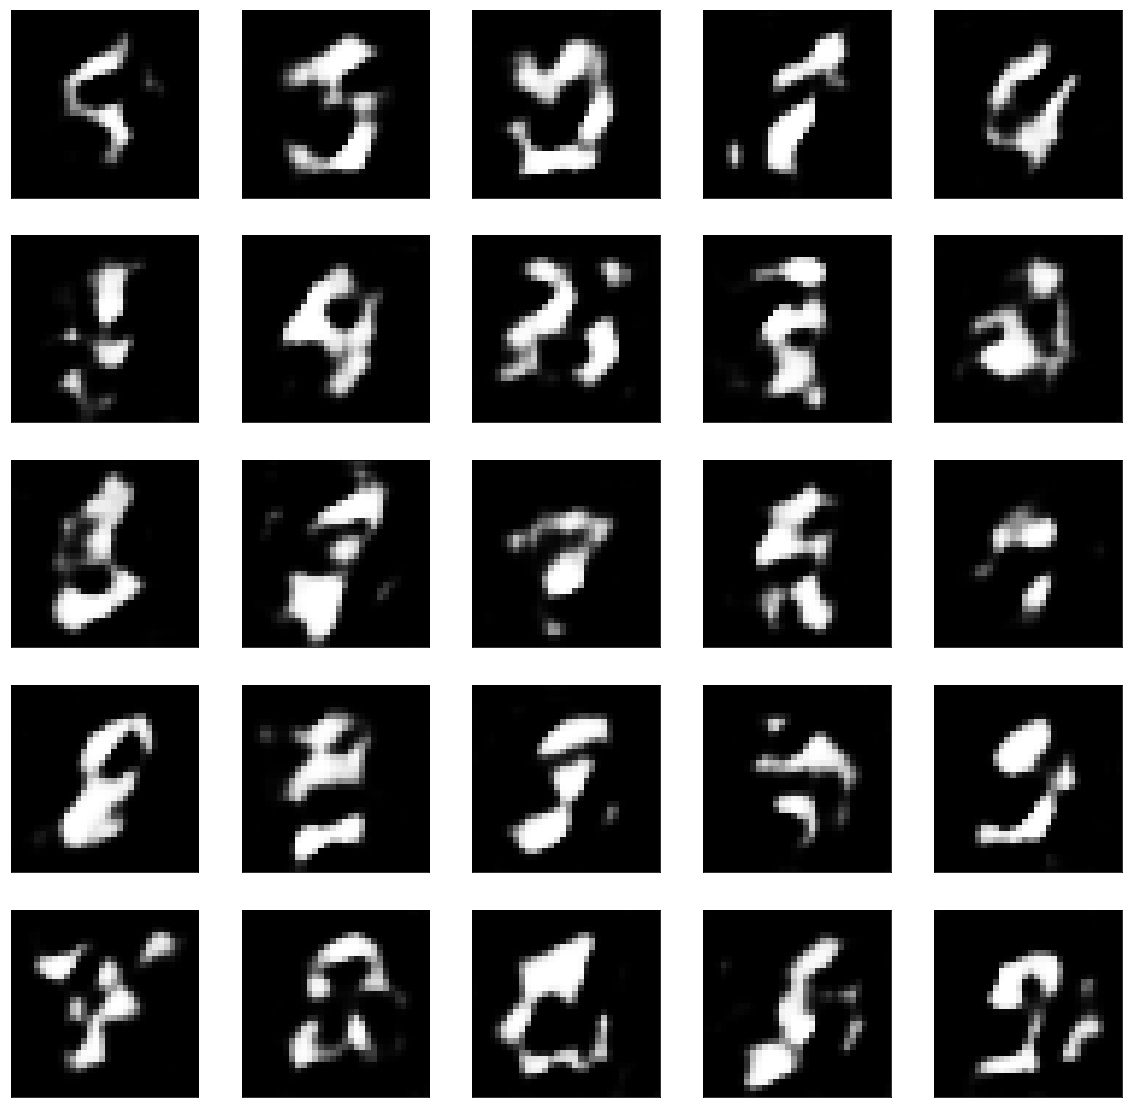

[Epoch 0/10] [Batch 401/938] [Generator loss: 0.693994] [Discriminator loss: 0.700405]
[Epoch 0/10] [Batch 402/938] [Generator loss: 0.698353] [Discriminator loss: 0.695517]
[Epoch 0/10] [Batch 403/938] [Generator loss: 0.678599] [Discriminator loss: 0.682746]
[Epoch 0/10] [Batch 404/938] [Generator loss: 0.674805] [Discriminator loss: 0.678946]
[Epoch 0/10] [Batch 405/938] [Generator loss: 0.650319] [Discriminator loss: 0.690603]
[Epoch 0/10] [Batch 406/938] [Generator loss: 0.662116] [Discriminator loss: 0.688582]
[Epoch 0/10] [Batch 407/938] [Generator loss: 0.642957] [Discriminator loss: 0.692937]
[Epoch 0/10] [Batch 408/938] [Generator loss: 0.681864] [Discriminator loss: 0.691980]
[Epoch 0/10] [Batch 409/938] [Generator loss: 0.671403] [Discriminator loss: 0.694047]
[Epoch 0/10] [Batch 410/938] [Generator loss: 0.652170] [Discriminator loss: 0.703956]
[Epoch 0/10] [Batch 411/938] [Generator loss: 0.681538] [Discriminator loss: 0.690134]
[Epoch 0/10] [Batch 412/938] [Generator los

[Epoch 0/10] [Batch 500/938] [Generator loss: 0.726055] [Discriminator loss: 0.692793]
[Epoch 0/10] [Batch 501/938] [Generator loss: 0.751380] [Discriminator loss: 0.676505]
[Epoch 0/10] [Batch 502/938] [Generator loss: 0.753394] [Discriminator loss: 0.687806]
[Epoch 0/10] [Batch 503/938] [Generator loss: 0.714888] [Discriminator loss: 0.679012]
[Epoch 0/10] [Batch 504/938] [Generator loss: 0.737421] [Discriminator loss: 0.685094]
[Epoch 0/10] [Batch 505/938] [Generator loss: 0.720375] [Discriminator loss: 0.668376]
[Epoch 0/10] [Batch 506/938] [Generator loss: 0.711714] [Discriminator loss: 0.676804]
[Epoch 0/10] [Batch 507/938] [Generator loss: 0.699783] [Discriminator loss: 0.686515]
[Epoch 0/10] [Batch 508/938] [Generator loss: 0.693160] [Discriminator loss: 0.688196]
[Epoch 0/10] [Batch 509/938] [Generator loss: 0.704638] [Discriminator loss: 0.691334]
[Epoch 0/10] [Batch 510/938] [Generator loss: 0.681165] [Discriminator loss: 0.705375]
[Epoch 0/10] [Batch 511/938] [Generator los

[Epoch 0/10] [Batch 595/938] [Generator loss: 0.727108] [Discriminator loss: 0.682354]
[Epoch 0/10] [Batch 596/938] [Generator loss: 0.695311] [Discriminator loss: 0.676450]
[Epoch 0/10] [Batch 597/938] [Generator loss: 0.699143] [Discriminator loss: 0.674921]
[Epoch 0/10] [Batch 598/938] [Generator loss: 0.677957] [Discriminator loss: 0.675463]
[Epoch 0/10] [Batch 599/938] [Generator loss: 0.658107] [Discriminator loss: 0.673170]
[Epoch 0/10] [Batch 600/938] [Generator loss: 0.642393] [Discriminator loss: 0.685216]
[Epoch 0/10] [Batch 601/938] [Generator loss: 0.635484] [Discriminator loss: 0.668391]
[Epoch 0/10] [Batch 602/938] [Generator loss: 0.657971] [Discriminator loss: 0.687459]
[Epoch 0/10] [Batch 603/938] [Generator loss: 0.683422] [Discriminator loss: 0.668537]
[Epoch 0/10] [Batch 604/938] [Generator loss: 0.677718] [Discriminator loss: 0.682565]
[Epoch 0/10] [Batch 605/938] [Generator loss: 0.730985] [Discriminator loss: 0.685159]
[Epoch 0/10] [Batch 606/938] [Generator los

[Epoch 0/10] [Batch 694/938] [Generator loss: 0.679506] [Discriminator loss: 0.698757]
[Epoch 0/10] [Batch 695/938] [Generator loss: 0.688133] [Discriminator loss: 0.695329]
[Epoch 0/10] [Batch 696/938] [Generator loss: 0.647578] [Discriminator loss: 0.701017]
[Epoch 0/10] [Batch 697/938] [Generator loss: 0.693338] [Discriminator loss: 0.674663]
[Epoch 0/10] [Batch 698/938] [Generator loss: 0.680984] [Discriminator loss: 0.692272]
[Epoch 0/10] [Batch 699/938] [Generator loss: 0.688725] [Discriminator loss: 0.673115]
[Epoch 0/10] [Batch 700/938] [Generator loss: 0.704509] [Discriminator loss: 0.694816]
[Epoch 0/10] [Batch 701/938] [Generator loss: 0.692750] [Discriminator loss: 0.687627]
[Epoch 0/10] [Batch 702/938] [Generator loss: 0.697780] [Discriminator loss: 0.689787]
[Epoch 0/10] [Batch 703/938] [Generator loss: 0.743956] [Discriminator loss: 0.671689]
[Epoch 0/10] [Batch 704/938] [Generator loss: 0.750088] [Discriminator loss: 0.679248]
[Epoch 0/10] [Batch 705/938] [Generator los

[Epoch 0/10] [Batch 794/938] [Generator loss: 0.688990] [Discriminator loss: 0.700223]
[Epoch 0/10] [Batch 795/938] [Generator loss: 0.757724] [Discriminator loss: 0.688810]
[Epoch 0/10] [Batch 796/938] [Generator loss: 0.733678] [Discriminator loss: 0.671212]
[Epoch 0/10] [Batch 797/938] [Generator loss: 0.695213] [Discriminator loss: 0.671721]
[Epoch 0/10] [Batch 798/938] [Generator loss: 0.743976] [Discriminator loss: 0.669839]
[Epoch 0/10] [Batch 799/938] [Generator loss: 0.683973] [Discriminator loss: 0.700794]
[Epoch 0/10] [Batch 800/938] [Generator loss: 0.684587] [Discriminator loss: 0.672083]


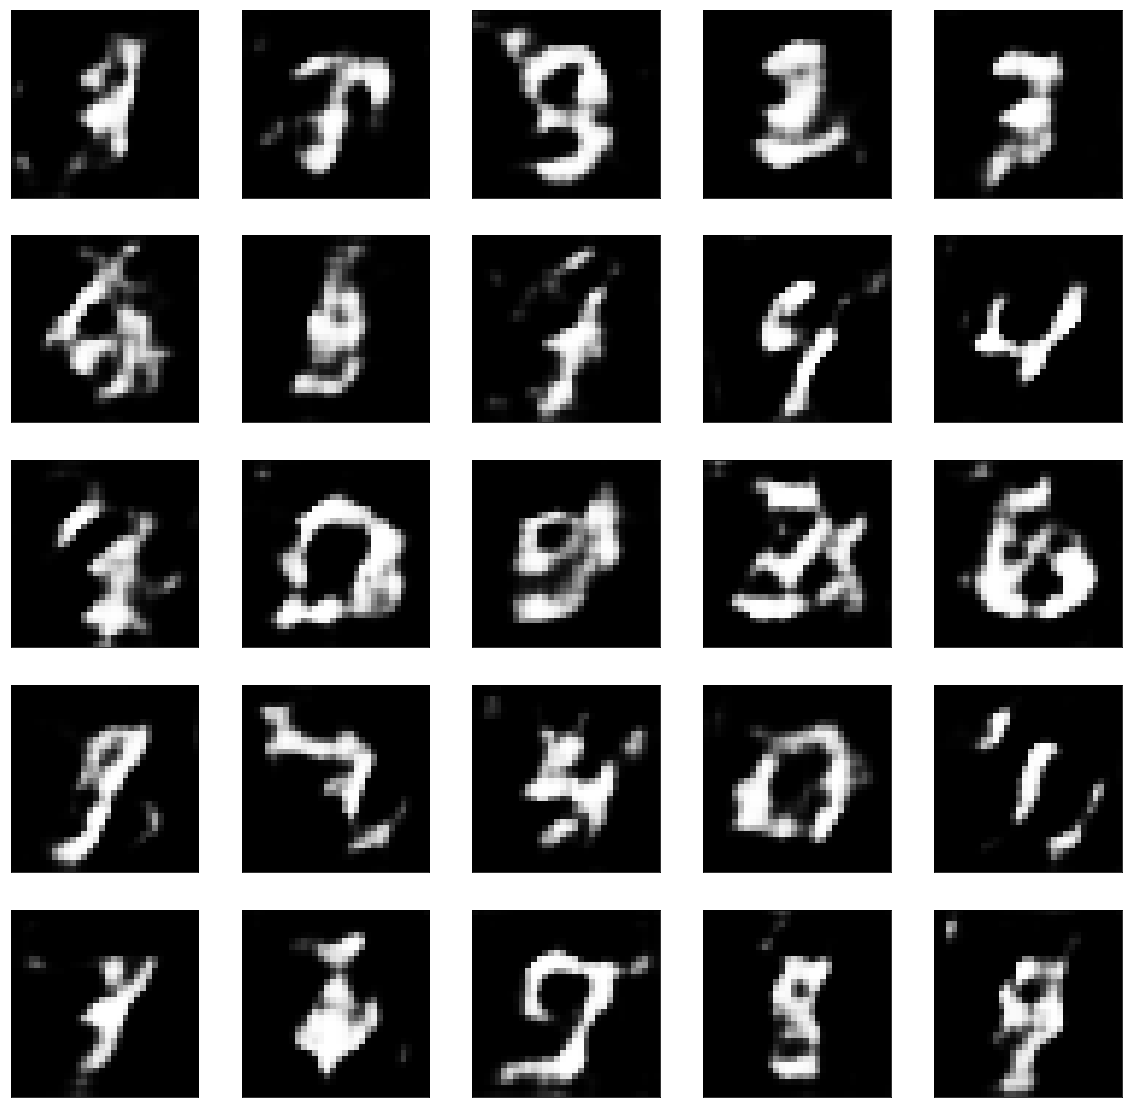

[Epoch 0/10] [Batch 801/938] [Generator loss: 0.744236] [Discriminator loss: 0.676262]
[Epoch 0/10] [Batch 802/938] [Generator loss: 0.732623] [Discriminator loss: 0.697422]
[Epoch 0/10] [Batch 803/938] [Generator loss: 0.752117] [Discriminator loss: 0.677633]
[Epoch 0/10] [Batch 804/938] [Generator loss: 0.713469] [Discriminator loss: 0.690079]
[Epoch 0/10] [Batch 805/938] [Generator loss: 0.736993] [Discriminator loss: 0.666113]
[Epoch 0/10] [Batch 806/938] [Generator loss: 0.724086] [Discriminator loss: 0.663401]
[Epoch 0/10] [Batch 807/938] [Generator loss: 0.726344] [Discriminator loss: 0.666609]
[Epoch 0/10] [Batch 808/938] [Generator loss: 0.770928] [Discriminator loss: 0.667918]
[Epoch 0/10] [Batch 809/938] [Generator loss: 0.738793] [Discriminator loss: 0.675567]
[Epoch 0/10] [Batch 810/938] [Generator loss: 0.798797] [Discriminator loss: 0.641847]
[Epoch 0/10] [Batch 811/938] [Generator loss: 0.821537] [Discriminator loss: 0.654794]
[Epoch 0/10] [Batch 812/938] [Generator los

[Epoch 0/10] [Batch 900/938] [Generator loss: 0.731576] [Discriminator loss: 0.639429]
[Epoch 0/10] [Batch 901/938] [Generator loss: 0.710334] [Discriminator loss: 0.643583]
[Epoch 0/10] [Batch 902/938] [Generator loss: 0.663785] [Discriminator loss: 0.624625]
[Epoch 0/10] [Batch 903/938] [Generator loss: 0.659596] [Discriminator loss: 0.660700]
[Epoch 0/10] [Batch 904/938] [Generator loss: 0.641640] [Discriminator loss: 0.657055]
[Epoch 0/10] [Batch 905/938] [Generator loss: 0.725664] [Discriminator loss: 0.637283]
[Epoch 0/10] [Batch 906/938] [Generator loss: 0.843036] [Discriminator loss: 0.663700]
[Epoch 0/10] [Batch 907/938] [Generator loss: 0.767090] [Discriminator loss: 0.649289]
[Epoch 0/10] [Batch 908/938] [Generator loss: 0.744413] [Discriminator loss: 0.653836]
[Epoch 0/10] [Batch 909/938] [Generator loss: 0.740013] [Discriminator loss: 0.641849]
[Epoch 0/10] [Batch 910/938] [Generator loss: 0.677658] [Discriminator loss: 0.678068]
[Epoch 0/10] [Batch 911/938] [Generator los

[Epoch 1/10] [Batch 58/938] [Generator loss: 0.749975] [Discriminator loss: 0.650940]
[Epoch 1/10] [Batch 59/938] [Generator loss: 0.731534] [Discriminator loss: 0.667984]
[Epoch 1/10] [Batch 60/938] [Generator loss: 0.789380] [Discriminator loss: 0.607168]
[Epoch 1/10] [Batch 61/938] [Generator loss: 0.747951] [Discriminator loss: 0.653739]
[Epoch 1/10] [Batch 62/938] [Generator loss: 0.806769] [Discriminator loss: 0.644309]
[Epoch 1/10] [Batch 63/938] [Generator loss: 0.865251] [Discriminator loss: 0.653262]
[Epoch 1/10] [Batch 64/938] [Generator loss: 0.690427] [Discriminator loss: 0.671140]
[Epoch 1/10] [Batch 65/938] [Generator loss: 0.778781] [Discriminator loss: 0.615754]
[Epoch 1/10] [Batch 66/938] [Generator loss: 0.700769] [Discriminator loss: 0.660084]
[Epoch 1/10] [Batch 67/938] [Generator loss: 0.766832] [Discriminator loss: 0.665382]
[Epoch 1/10] [Batch 68/938] [Generator loss: 0.790754] [Discriminator loss: 0.654143]
[Epoch 1/10] [Batch 69/938] [Generator loss: 0.818926]

[Epoch 1/10] [Batch 155/938] [Generator loss: 0.744454] [Discriminator loss: 0.687014]
[Epoch 1/10] [Batch 156/938] [Generator loss: 0.727447] [Discriminator loss: 0.664127]
[Epoch 1/10] [Batch 157/938] [Generator loss: 0.814923] [Discriminator loss: 0.658493]
[Epoch 1/10] [Batch 158/938] [Generator loss: 0.855370] [Discriminator loss: 0.634485]
[Epoch 1/10] [Batch 159/938] [Generator loss: 0.861745] [Discriminator loss: 0.644360]
[Epoch 1/10] [Batch 160/938] [Generator loss: 0.723427] [Discriminator loss: 0.632393]
[Epoch 1/10] [Batch 161/938] [Generator loss: 0.768851] [Discriminator loss: 0.628627]
[Epoch 1/10] [Batch 162/938] [Generator loss: 0.719882] [Discriminator loss: 0.638977]
[Epoch 1/10] [Batch 163/938] [Generator loss: 0.720276] [Discriminator loss: 0.608231]
[Epoch 1/10] [Batch 164/938] [Generator loss: 0.838157] [Discriminator loss: 0.630226]
[Epoch 1/10] [Batch 165/938] [Generator loss: 1.006631] [Discriminator loss: 0.596255]
[Epoch 1/10] [Batch 166/938] [Generator los

[Epoch 1/10] [Batch 253/938] [Generator loss: 0.763874] [Discriminator loss: 0.659285]
[Epoch 1/10] [Batch 254/938] [Generator loss: 0.736040] [Discriminator loss: 0.702226]
[Epoch 1/10] [Batch 255/938] [Generator loss: 0.727762] [Discriminator loss: 0.668544]
[Epoch 1/10] [Batch 256/938] [Generator loss: 0.775447] [Discriminator loss: 0.659713]
[Epoch 1/10] [Batch 257/938] [Generator loss: 0.715258] [Discriminator loss: 0.670017]
[Epoch 1/10] [Batch 258/938] [Generator loss: 0.745290] [Discriminator loss: 0.674372]
[Epoch 1/10] [Batch 259/938] [Generator loss: 0.787675] [Discriminator loss: 0.665861]
[Epoch 1/10] [Batch 260/938] [Generator loss: 0.800487] [Discriminator loss: 0.656712]
[Epoch 1/10] [Batch 261/938] [Generator loss: 0.706091] [Discriminator loss: 0.694210]
[Epoch 1/10] [Batch 262/938] [Generator loss: 0.736549] [Discriminator loss: 0.653068]


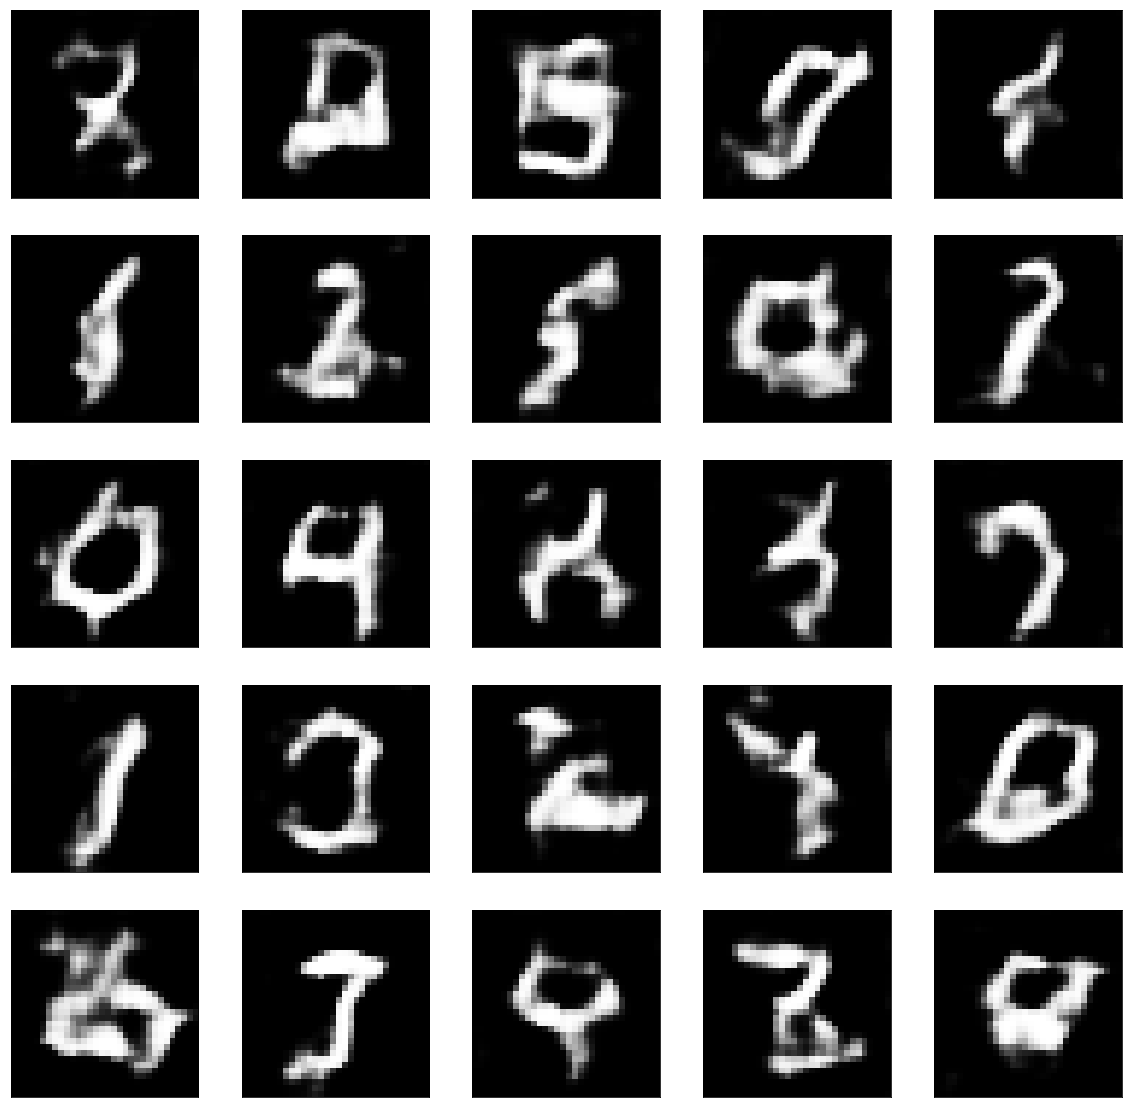

[Epoch 1/10] [Batch 263/938] [Generator loss: 0.728187] [Discriminator loss: 0.708621]
[Epoch 1/10] [Batch 264/938] [Generator loss: 0.771543] [Discriminator loss: 0.681595]
[Epoch 1/10] [Batch 265/938] [Generator loss: 0.839881] [Discriminator loss: 0.670586]
[Epoch 1/10] [Batch 266/938] [Generator loss: 0.759479] [Discriminator loss: 0.679938]
[Epoch 1/10] [Batch 267/938] [Generator loss: 0.699373] [Discriminator loss: 0.637199]
[Epoch 1/10] [Batch 268/938] [Generator loss: 0.677524] [Discriminator loss: 0.701657]
[Epoch 1/10] [Batch 269/938] [Generator loss: 0.821574] [Discriminator loss: 0.614571]
[Epoch 1/10] [Batch 270/938] [Generator loss: 0.772729] [Discriminator loss: 0.634124]
[Epoch 1/10] [Batch 271/938] [Generator loss: 0.732188] [Discriminator loss: 0.651991]
[Epoch 1/10] [Batch 272/938] [Generator loss: 0.737781] [Discriminator loss: 0.676074]
[Epoch 1/10] [Batch 273/938] [Generator loss: 0.771802] [Discriminator loss: 0.679764]
[Epoch 1/10] [Batch 274/938] [Generator los

[Epoch 1/10] [Batch 363/938] [Generator loss: 0.726245] [Discriminator loss: 0.683048]
[Epoch 1/10] [Batch 364/938] [Generator loss: 0.696193] [Discriminator loss: 0.691301]
[Epoch 1/10] [Batch 365/938] [Generator loss: 0.645644] [Discriminator loss: 0.687052]
[Epoch 1/10] [Batch 366/938] [Generator loss: 0.685748] [Discriminator loss: 0.640594]
[Epoch 1/10] [Batch 367/938] [Generator loss: 0.731777] [Discriminator loss: 0.613993]
[Epoch 1/10] [Batch 368/938] [Generator loss: 0.837703] [Discriminator loss: 0.605250]
[Epoch 1/10] [Batch 369/938] [Generator loss: 0.861535] [Discriminator loss: 0.590343]
[Epoch 1/10] [Batch 370/938] [Generator loss: 0.810653] [Discriminator loss: 0.593394]
[Epoch 1/10] [Batch 371/938] [Generator loss: 0.802018] [Discriminator loss: 0.669290]
[Epoch 1/10] [Batch 372/938] [Generator loss: 0.642149] [Discriminator loss: 0.692977]
[Epoch 1/10] [Batch 373/938] [Generator loss: 0.746319] [Discriminator loss: 0.655976]
[Epoch 1/10] [Batch 374/938] [Generator los

[Epoch 1/10] [Batch 462/938] [Generator loss: 0.782382] [Discriminator loss: 0.627907]
[Epoch 1/10] [Batch 463/938] [Generator loss: 0.734938] [Discriminator loss: 0.618854]
[Epoch 1/10] [Batch 464/938] [Generator loss: 0.680557] [Discriminator loss: 0.697343]
[Epoch 1/10] [Batch 465/938] [Generator loss: 0.778709] [Discriminator loss: 0.712465]
[Epoch 1/10] [Batch 466/938] [Generator loss: 0.787729] [Discriminator loss: 0.600051]
[Epoch 1/10] [Batch 467/938] [Generator loss: 0.898862] [Discriminator loss: 0.657900]
[Epoch 1/10] [Batch 468/938] [Generator loss: 0.744260] [Discriminator loss: 0.628838]
[Epoch 1/10] [Batch 469/938] [Generator loss: 0.799527] [Discriminator loss: 0.645087]
[Epoch 1/10] [Batch 470/938] [Generator loss: 0.786354] [Discriminator loss: 0.648580]
[Epoch 1/10] [Batch 471/938] [Generator loss: 0.629620] [Discriminator loss: 0.661276]
[Epoch 1/10] [Batch 472/938] [Generator loss: 0.670494] [Discriminator loss: 0.636958]
[Epoch 1/10] [Batch 473/938] [Generator los

[Epoch 1/10] [Batch 561/938] [Generator loss: 0.883791] [Discriminator loss: 0.639535]
[Epoch 1/10] [Batch 562/938] [Generator loss: 0.814366] [Discriminator loss: 0.619765]
[Epoch 1/10] [Batch 563/938] [Generator loss: 0.640931] [Discriminator loss: 0.596450]
[Epoch 1/10] [Batch 564/938] [Generator loss: 0.701807] [Discriminator loss: 0.627454]
[Epoch 1/10] [Batch 565/938] [Generator loss: 0.828672] [Discriminator loss: 0.654374]
[Epoch 1/10] [Batch 566/938] [Generator loss: 0.900834] [Discriminator loss: 0.667886]
[Epoch 1/10] [Batch 567/938] [Generator loss: 0.853820] [Discriminator loss: 0.656028]
[Epoch 1/10] [Batch 568/938] [Generator loss: 0.744163] [Discriminator loss: 0.655263]
[Epoch 1/10] [Batch 569/938] [Generator loss: 0.784570] [Discriminator loss: 0.593515]
[Epoch 1/10] [Batch 570/938] [Generator loss: 0.755623] [Discriminator loss: 0.638676]
[Epoch 1/10] [Batch 571/938] [Generator loss: 0.760394] [Discriminator loss: 0.608394]
[Epoch 1/10] [Batch 572/938] [Generator los

[Epoch 1/10] [Batch 659/938] [Generator loss: 0.628974] [Discriminator loss: 0.609666]
[Epoch 1/10] [Batch 660/938] [Generator loss: 0.739907] [Discriminator loss: 0.696786]
[Epoch 1/10] [Batch 661/938] [Generator loss: 0.885518] [Discriminator loss: 0.643487]
[Epoch 1/10] [Batch 662/938] [Generator loss: 0.820558] [Discriminator loss: 0.674503]


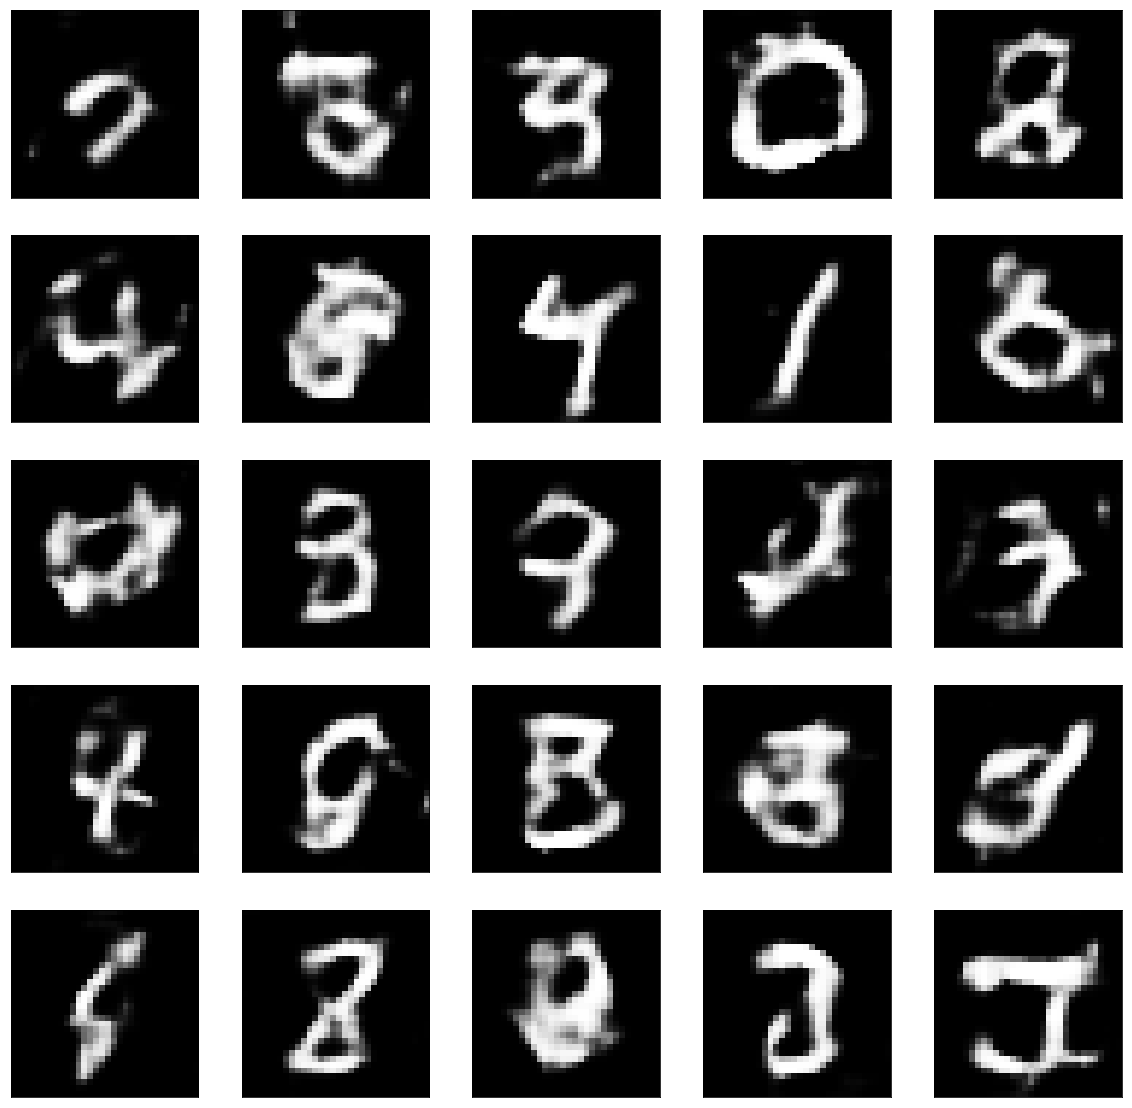

[Epoch 1/10] [Batch 663/938] [Generator loss: 0.822988] [Discriminator loss: 0.680724]
[Epoch 1/10] [Batch 664/938] [Generator loss: 0.742949] [Discriminator loss: 0.639577]
[Epoch 1/10] [Batch 665/938] [Generator loss: 0.889526] [Discriminator loss: 0.610220]
[Epoch 1/10] [Batch 666/938] [Generator loss: 0.753937] [Discriminator loss: 0.530675]
[Epoch 1/10] [Batch 667/938] [Generator loss: 0.704159] [Discriminator loss: 0.605445]
[Epoch 1/10] [Batch 668/938] [Generator loss: 0.814949] [Discriminator loss: 0.686645]
[Epoch 1/10] [Batch 669/938] [Generator loss: 0.688133] [Discriminator loss: 0.650172]
[Epoch 1/10] [Batch 670/938] [Generator loss: 0.748962] [Discriminator loss: 0.642494]
[Epoch 1/10] [Batch 671/938] [Generator loss: 0.797631] [Discriminator loss: 0.685667]
[Epoch 1/10] [Batch 672/938] [Generator loss: 0.916056] [Discriminator loss: 0.615591]
[Epoch 1/10] [Batch 673/938] [Generator loss: 0.685475] [Discriminator loss: 0.718073]
[Epoch 1/10] [Batch 674/938] [Generator los

[Epoch 1/10] [Batch 764/938] [Generator loss: 0.758757] [Discriminator loss: 0.728703]
[Epoch 1/10] [Batch 765/938] [Generator loss: 0.788674] [Discriminator loss: 0.604165]
[Epoch 1/10] [Batch 766/938] [Generator loss: 0.820769] [Discriminator loss: 0.663535]
[Epoch 1/10] [Batch 767/938] [Generator loss: 0.914816] [Discriminator loss: 0.564001]
[Epoch 1/10] [Batch 768/938] [Generator loss: 0.805755] [Discriminator loss: 0.697524]
[Epoch 1/10] [Batch 769/938] [Generator loss: 0.816126] [Discriminator loss: 0.617017]
[Epoch 1/10] [Batch 770/938] [Generator loss: 0.729322] [Discriminator loss: 0.624860]
[Epoch 1/10] [Batch 771/938] [Generator loss: 0.807590] [Discriminator loss: 0.630099]
[Epoch 1/10] [Batch 772/938] [Generator loss: 0.732759] [Discriminator loss: 0.689634]
[Epoch 1/10] [Batch 773/938] [Generator loss: 0.951550] [Discriminator loss: 0.642201]
[Epoch 1/10] [Batch 774/938] [Generator loss: 0.876430] [Discriminator loss: 0.625522]
[Epoch 1/10] [Batch 775/938] [Generator los

[Epoch 1/10] [Batch 863/938] [Generator loss: 0.661778] [Discriminator loss: 0.690413]
[Epoch 1/10] [Batch 864/938] [Generator loss: 0.874256] [Discriminator loss: 0.653749]
[Epoch 1/10] [Batch 865/938] [Generator loss: 0.817596] [Discriminator loss: 0.692462]
[Epoch 1/10] [Batch 866/938] [Generator loss: 0.697529] [Discriminator loss: 0.653132]
[Epoch 1/10] [Batch 867/938] [Generator loss: 0.796852] [Discriminator loss: 0.611796]
[Epoch 1/10] [Batch 868/938] [Generator loss: 0.731303] [Discriminator loss: 0.556001]
[Epoch 1/10] [Batch 869/938] [Generator loss: 0.729200] [Discriminator loss: 0.613732]
[Epoch 1/10] [Batch 870/938] [Generator loss: 0.749248] [Discriminator loss: 0.601776]
[Epoch 1/10] [Batch 871/938] [Generator loss: 0.819153] [Discriminator loss: 0.615375]
[Epoch 1/10] [Batch 872/938] [Generator loss: 0.770305] [Discriminator loss: 0.625246]
[Epoch 1/10] [Batch 873/938] [Generator loss: 0.784757] [Discriminator loss: 0.580806]
[Epoch 1/10] [Batch 874/938] [Generator los

[Epoch 2/10] [Batch 22/938] [Generator loss: 0.796098] [Discriminator loss: 0.600424]
[Epoch 2/10] [Batch 23/938] [Generator loss: 1.016803] [Discriminator loss: 0.629506]
[Epoch 2/10] [Batch 24/938] [Generator loss: 0.916052] [Discriminator loss: 0.595114]
[Epoch 2/10] [Batch 25/938] [Generator loss: 0.830007] [Discriminator loss: 0.636391]
[Epoch 2/10] [Batch 26/938] [Generator loss: 0.703696] [Discriminator loss: 0.676904]
[Epoch 2/10] [Batch 27/938] [Generator loss: 0.762108] [Discriminator loss: 0.594047]
[Epoch 2/10] [Batch 28/938] [Generator loss: 0.622305] [Discriminator loss: 0.676906]
[Epoch 2/10] [Batch 29/938] [Generator loss: 0.946314] [Discriminator loss: 0.578373]
[Epoch 2/10] [Batch 30/938] [Generator loss: 0.954312] [Discriminator loss: 0.687781]
[Epoch 2/10] [Batch 31/938] [Generator loss: 0.818361] [Discriminator loss: 0.619967]
[Epoch 2/10] [Batch 32/938] [Generator loss: 0.636545] [Discriminator loss: 0.686333]
[Epoch 2/10] [Batch 33/938] [Generator loss: 0.718190]

[Epoch 2/10] [Batch 123/938] [Generator loss: 0.887365] [Discriminator loss: 0.677149]
[Epoch 2/10] [Batch 124/938] [Generator loss: 0.702643] [Discriminator loss: 0.583906]


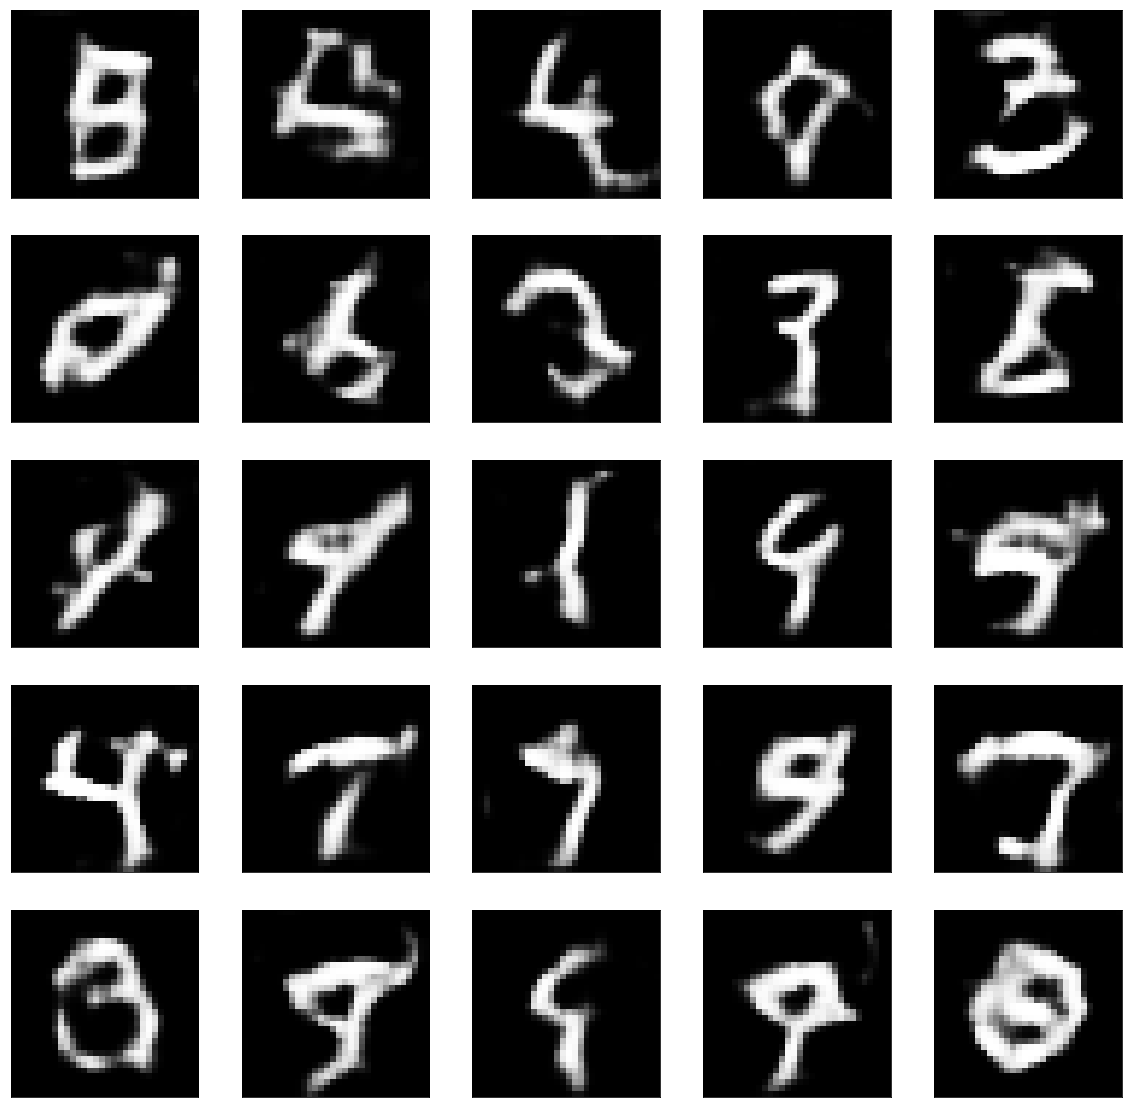

[Epoch 2/10] [Batch 125/938] [Generator loss: 0.900134] [Discriminator loss: 0.619612]
[Epoch 2/10] [Batch 126/938] [Generator loss: 0.824648] [Discriminator loss: 0.623828]
[Epoch 2/10] [Batch 127/938] [Generator loss: 0.797136] [Discriminator loss: 0.635075]
[Epoch 2/10] [Batch 128/938] [Generator loss: 0.756612] [Discriminator loss: 0.628969]
[Epoch 2/10] [Batch 129/938] [Generator loss: 0.673648] [Discriminator loss: 0.642331]
[Epoch 2/10] [Batch 130/938] [Generator loss: 0.743160] [Discriminator loss: 0.739542]
[Epoch 2/10] [Batch 131/938] [Generator loss: 0.847832] [Discriminator loss: 0.668207]
[Epoch 2/10] [Batch 132/938] [Generator loss: 0.949200] [Discriminator loss: 0.620094]
[Epoch 2/10] [Batch 133/938] [Generator loss: 0.756450] [Discriminator loss: 0.532718]
[Epoch 2/10] [Batch 134/938] [Generator loss: 0.659566] [Discriminator loss: 0.604025]
[Epoch 2/10] [Batch 135/938] [Generator loss: 0.768141] [Discriminator loss: 0.696516]
[Epoch 2/10] [Batch 136/938] [Generator los

[Epoch 2/10] [Batch 221/938] [Generator loss: 0.741678] [Discriminator loss: 0.605701]
[Epoch 2/10] [Batch 222/938] [Generator loss: 0.857644] [Discriminator loss: 0.605281]
[Epoch 2/10] [Batch 223/938] [Generator loss: 0.805981] [Discriminator loss: 0.575545]
[Epoch 2/10] [Batch 224/938] [Generator loss: 0.774407] [Discriminator loss: 0.584820]
[Epoch 2/10] [Batch 225/938] [Generator loss: 0.757263] [Discriminator loss: 0.597870]
[Epoch 2/10] [Batch 226/938] [Generator loss: 0.846025] [Discriminator loss: 0.569713]
[Epoch 2/10] [Batch 227/938] [Generator loss: 0.808725] [Discriminator loss: 0.539849]
[Epoch 2/10] [Batch 228/938] [Generator loss: 0.815121] [Discriminator loss: 0.648744]
[Epoch 2/10] [Batch 229/938] [Generator loss: 0.907464] [Discriminator loss: 0.641392]
[Epoch 2/10] [Batch 230/938] [Generator loss: 0.829282] [Discriminator loss: 0.654053]
[Epoch 2/10] [Batch 231/938] [Generator loss: 0.796829] [Discriminator loss: 0.657236]
[Epoch 2/10] [Batch 232/938] [Generator los

[Epoch 2/10] [Batch 320/938] [Generator loss: 0.728728] [Discriminator loss: 0.604380]
[Epoch 2/10] [Batch 321/938] [Generator loss: 0.892068] [Discriminator loss: 0.696583]
[Epoch 2/10] [Batch 322/938] [Generator loss: 0.784570] [Discriminator loss: 0.610478]
[Epoch 2/10] [Batch 323/938] [Generator loss: 0.786325] [Discriminator loss: 0.618254]
[Epoch 2/10] [Batch 324/938] [Generator loss: 0.760736] [Discriminator loss: 0.744883]
[Epoch 2/10] [Batch 325/938] [Generator loss: 0.880616] [Discriminator loss: 0.646745]
[Epoch 2/10] [Batch 326/938] [Generator loss: 0.790626] [Discriminator loss: 0.601074]
[Epoch 2/10] [Batch 327/938] [Generator loss: 0.686197] [Discriminator loss: 0.612487]
[Epoch 2/10] [Batch 328/938] [Generator loss: 0.740872] [Discriminator loss: 0.709850]
[Epoch 2/10] [Batch 329/938] [Generator loss: 0.609059] [Discriminator loss: 0.633869]
[Epoch 2/10] [Batch 330/938] [Generator loss: 0.809503] [Discriminator loss: 0.633714]
[Epoch 2/10] [Batch 331/938] [Generator los

[Epoch 2/10] [Batch 419/938] [Generator loss: 0.893457] [Discriminator loss: 0.556393]
[Epoch 2/10] [Batch 420/938] [Generator loss: 0.753873] [Discriminator loss: 0.642606]
[Epoch 2/10] [Batch 421/938] [Generator loss: 0.747007] [Discriminator loss: 0.638938]
[Epoch 2/10] [Batch 422/938] [Generator loss: 0.907718] [Discriminator loss: 0.610572]
[Epoch 2/10] [Batch 423/938] [Generator loss: 0.849722] [Discriminator loss: 0.656955]
[Epoch 2/10] [Batch 424/938] [Generator loss: 0.721112] [Discriminator loss: 0.668312]
[Epoch 2/10] [Batch 425/938] [Generator loss: 0.654477] [Discriminator loss: 0.610035]
[Epoch 2/10] [Batch 426/938] [Generator loss: 0.796176] [Discriminator loss: 0.605197]
[Epoch 2/10] [Batch 427/938] [Generator loss: 0.755846] [Discriminator loss: 0.645593]
[Epoch 2/10] [Batch 428/938] [Generator loss: 0.780500] [Discriminator loss: 0.669079]
[Epoch 2/10] [Batch 429/938] [Generator loss: 0.878914] [Discriminator loss: 0.649350]
[Epoch 2/10] [Batch 430/938] [Generator los

[Epoch 2/10] [Batch 518/938] [Generator loss: 0.725867] [Discriminator loss: 0.630950]
[Epoch 2/10] [Batch 519/938] [Generator loss: 0.945671] [Discriminator loss: 0.657739]
[Epoch 2/10] [Batch 520/938] [Generator loss: 0.705329] [Discriminator loss: 0.667690]
[Epoch 2/10] [Batch 521/938] [Generator loss: 0.708104] [Discriminator loss: 0.584337]
[Epoch 2/10] [Batch 522/938] [Generator loss: 0.878082] [Discriminator loss: 0.646220]
[Epoch 2/10] [Batch 523/938] [Generator loss: 0.794472] [Discriminator loss: 0.597714]
[Epoch 2/10] [Batch 524/938] [Generator loss: 0.844749] [Discriminator loss: 0.643577]


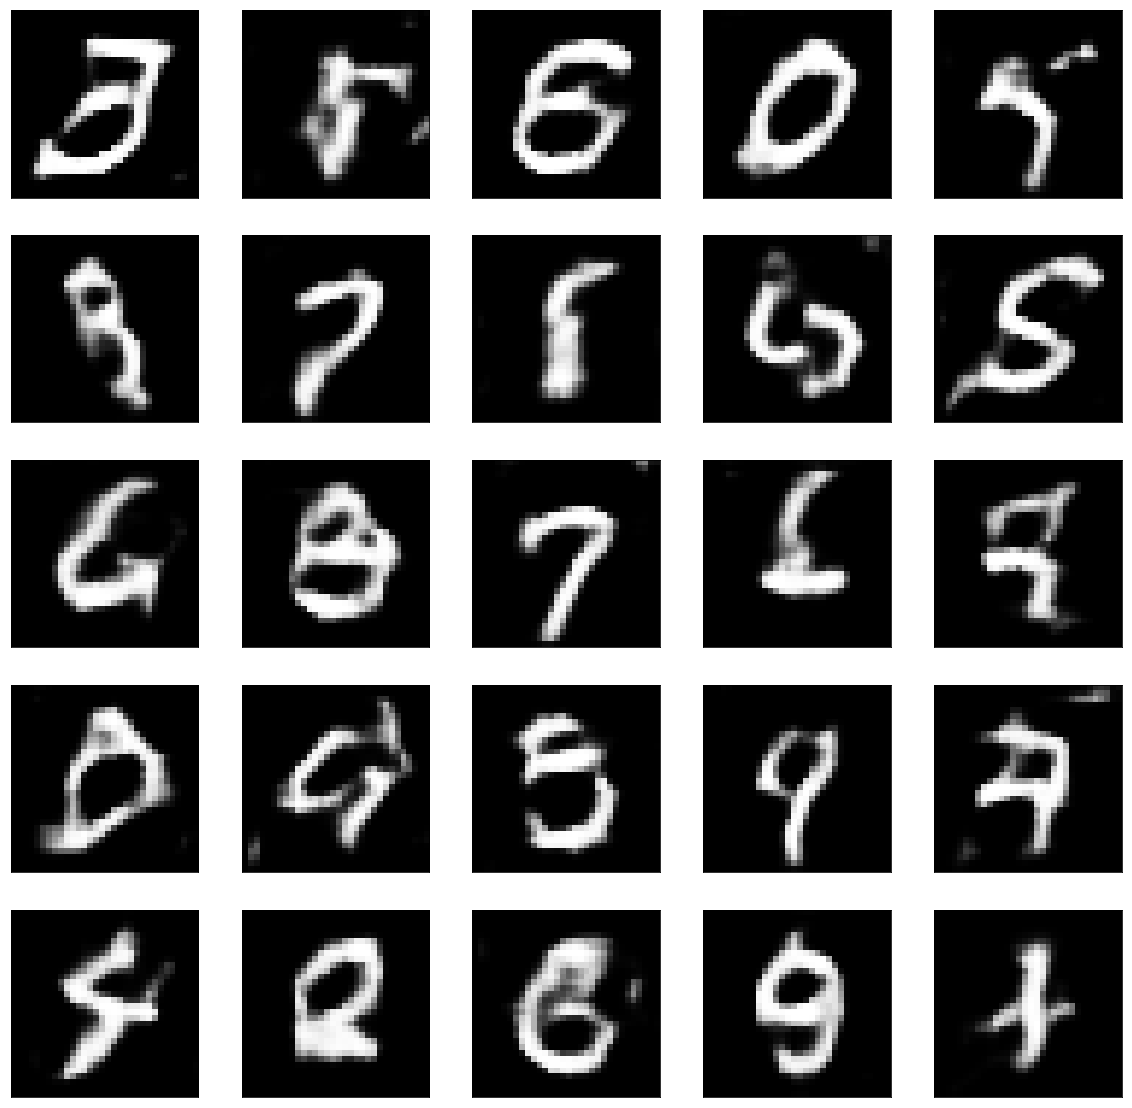

[Epoch 2/10] [Batch 525/938] [Generator loss: 0.862281] [Discriminator loss: 0.704437]
[Epoch 2/10] [Batch 526/938] [Generator loss: 0.890545] [Discriminator loss: 0.593335]
[Epoch 2/10] [Batch 527/938] [Generator loss: 0.703582] [Discriminator loss: 0.658747]
[Epoch 2/10] [Batch 528/938] [Generator loss: 0.677793] [Discriminator loss: 0.626301]
[Epoch 2/10] [Batch 529/938] [Generator loss: 0.820670] [Discriminator loss: 0.577670]
[Epoch 2/10] [Batch 530/938] [Generator loss: 0.936272] [Discriminator loss: 0.651801]
[Epoch 2/10] [Batch 531/938] [Generator loss: 0.813491] [Discriminator loss: 0.674662]
[Epoch 2/10] [Batch 532/938] [Generator loss: 0.854091] [Discriminator loss: 0.702436]
[Epoch 2/10] [Batch 533/938] [Generator loss: 0.862726] [Discriminator loss: 0.678262]
[Epoch 2/10] [Batch 534/938] [Generator loss: 0.706756] [Discriminator loss: 0.635023]
[Epoch 2/10] [Batch 535/938] [Generator loss: 0.887999] [Discriminator loss: 0.650245]
[Epoch 2/10] [Batch 536/938] [Generator los

[Epoch 2/10] [Batch 621/938] [Generator loss: 0.737233] [Discriminator loss: 0.604309]
[Epoch 2/10] [Batch 622/938] [Generator loss: 0.801984] [Discriminator loss: 0.527670]
[Epoch 2/10] [Batch 623/938] [Generator loss: 0.768794] [Discriminator loss: 0.627109]
[Epoch 2/10] [Batch 624/938] [Generator loss: 0.719993] [Discriminator loss: 0.649763]
[Epoch 2/10] [Batch 625/938] [Generator loss: 0.863938] [Discriminator loss: 0.534716]
[Epoch 2/10] [Batch 626/938] [Generator loss: 0.795760] [Discriminator loss: 0.651418]
[Epoch 2/10] [Batch 627/938] [Generator loss: 0.723967] [Discriminator loss: 0.624898]
[Epoch 2/10] [Batch 628/938] [Generator loss: 0.685649] [Discriminator loss: 0.697044]
[Epoch 2/10] [Batch 629/938] [Generator loss: 0.852116] [Discriminator loss: 0.570637]
[Epoch 2/10] [Batch 630/938] [Generator loss: 0.770345] [Discriminator loss: 0.588454]
[Epoch 2/10] [Batch 631/938] [Generator loss: 0.726005] [Discriminator loss: 0.597163]
[Epoch 2/10] [Batch 632/938] [Generator los

[Epoch 2/10] [Batch 717/938] [Generator loss: 0.853809] [Discriminator loss: 0.501340]
[Epoch 2/10] [Batch 718/938] [Generator loss: 0.861867] [Discriminator loss: 0.597711]
[Epoch 2/10] [Batch 719/938] [Generator loss: 0.781317] [Discriminator loss: 0.610400]
[Epoch 2/10] [Batch 720/938] [Generator loss: 0.955898] [Discriminator loss: 0.610351]
[Epoch 2/10] [Batch 721/938] [Generator loss: 0.893375] [Discriminator loss: 0.552251]
[Epoch 2/10] [Batch 722/938] [Generator loss: 0.650311] [Discriminator loss: 0.578257]
[Epoch 2/10] [Batch 723/938] [Generator loss: 0.801249] [Discriminator loss: 0.588712]
[Epoch 2/10] [Batch 724/938] [Generator loss: 0.908387] [Discriminator loss: 0.677358]
[Epoch 2/10] [Batch 725/938] [Generator loss: 0.998187] [Discriminator loss: 0.604184]
[Epoch 2/10] [Batch 726/938] [Generator loss: 1.074786] [Discriminator loss: 0.620328]
[Epoch 2/10] [Batch 727/938] [Generator loss: 0.944276] [Discriminator loss: 0.555556]
[Epoch 2/10] [Batch 728/938] [Generator los

[Epoch 2/10] [Batch 816/938] [Generator loss: 0.873312] [Discriminator loss: 0.667538]
[Epoch 2/10] [Batch 817/938] [Generator loss: 0.739961] [Discriminator loss: 0.608945]
[Epoch 2/10] [Batch 818/938] [Generator loss: 0.855011] [Discriminator loss: 0.626538]
[Epoch 2/10] [Batch 819/938] [Generator loss: 0.958642] [Discriminator loss: 0.573779]
[Epoch 2/10] [Batch 820/938] [Generator loss: 0.823791] [Discriminator loss: 0.687568]
[Epoch 2/10] [Batch 821/938] [Generator loss: 0.731447] [Discriminator loss: 0.696205]
[Epoch 2/10] [Batch 822/938] [Generator loss: 0.762419] [Discriminator loss: 0.621489]
[Epoch 2/10] [Batch 823/938] [Generator loss: 1.092053] [Discriminator loss: 0.598988]
[Epoch 2/10] [Batch 824/938] [Generator loss: 0.813754] [Discriminator loss: 0.543354]
[Epoch 2/10] [Batch 825/938] [Generator loss: 0.756567] [Discriminator loss: 0.605427]
[Epoch 2/10] [Batch 826/938] [Generator loss: 0.735720] [Discriminator loss: 0.506374]
[Epoch 2/10] [Batch 827/938] [Generator los

[Epoch 2/10] [Batch 912/938] [Generator loss: 0.956442] [Discriminator loss: 0.547349]
[Epoch 2/10] [Batch 913/938] [Generator loss: 0.886307] [Discriminator loss: 0.621563]
[Epoch 2/10] [Batch 914/938] [Generator loss: 0.569334] [Discriminator loss: 0.674229]
[Epoch 2/10] [Batch 915/938] [Generator loss: 0.654051] [Discriminator loss: 0.690344]
[Epoch 2/10] [Batch 916/938] [Generator loss: 0.743081] [Discriminator loss: 0.574313]
[Epoch 2/10] [Batch 917/938] [Generator loss: 0.754206] [Discriminator loss: 0.551137]
[Epoch 2/10] [Batch 918/938] [Generator loss: 1.009602] [Discriminator loss: 0.749478]
[Epoch 2/10] [Batch 919/938] [Generator loss: 0.741005] [Discriminator loss: 0.700099]
[Epoch 2/10] [Batch 920/938] [Generator loss: 0.895027] [Discriminator loss: 0.620156]
[Epoch 2/10] [Batch 921/938] [Generator loss: 0.825373] [Discriminator loss: 0.792336]
[Epoch 2/10] [Batch 922/938] [Generator loss: 0.884064] [Discriminator loss: 0.681855]
[Epoch 2/10] [Batch 923/938] [Generator los

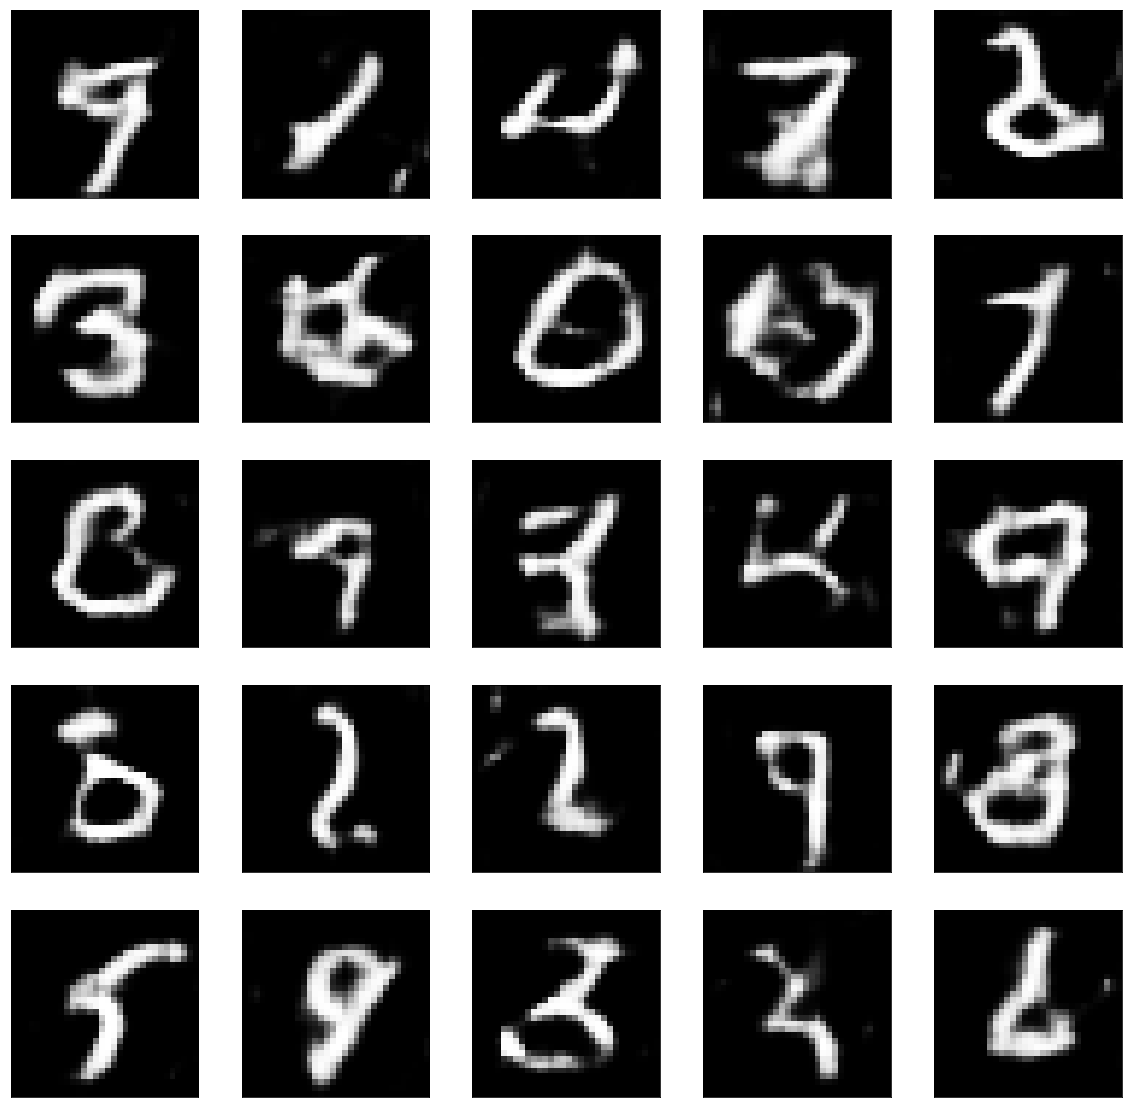

[Epoch 2/10] [Batch 925/938] [Generator loss: 0.701903] [Discriminator loss: 0.589810]
[Epoch 2/10] [Batch 926/938] [Generator loss: 0.834369] [Discriminator loss: 0.669251]
[Epoch 2/10] [Batch 927/938] [Generator loss: 0.824899] [Discriminator loss: 0.637466]
[Epoch 2/10] [Batch 928/938] [Generator loss: 0.961572] [Discriminator loss: 0.566848]
[Epoch 2/10] [Batch 929/938] [Generator loss: 0.970619] [Discriminator loss: 0.646776]
[Epoch 2/10] [Batch 930/938] [Generator loss: 0.893670] [Discriminator loss: 0.557807]
[Epoch 2/10] [Batch 931/938] [Generator loss: 0.843307] [Discriminator loss: 0.598204]
[Epoch 2/10] [Batch 932/938] [Generator loss: 0.864335] [Discriminator loss: 0.648051]
[Epoch 2/10] [Batch 933/938] [Generator loss: 0.897978] [Discriminator loss: 0.665403]
[Epoch 2/10] [Batch 934/938] [Generator loss: 0.849157] [Discriminator loss: 0.620545]
[Epoch 2/10] [Batch 935/938] [Generator loss: 0.881775] [Discriminator loss: 0.555820]
[Epoch 2/10] [Batch 936/938] [Generator los

[Epoch 3/10] [Batch 89/938] [Generator loss: 0.847309] [Discriminator loss: 0.573288]
[Epoch 3/10] [Batch 90/938] [Generator loss: 0.967318] [Discriminator loss: 0.571042]
[Epoch 3/10] [Batch 91/938] [Generator loss: 0.864101] [Discriminator loss: 0.539253]
[Epoch 3/10] [Batch 92/938] [Generator loss: 0.651764] [Discriminator loss: 0.555685]
[Epoch 3/10] [Batch 93/938] [Generator loss: 0.655876] [Discriminator loss: 0.622805]
[Epoch 3/10] [Batch 94/938] [Generator loss: 0.762167] [Discriminator loss: 0.564233]
[Epoch 3/10] [Batch 95/938] [Generator loss: 0.845910] [Discriminator loss: 0.637096]
[Epoch 3/10] [Batch 96/938] [Generator loss: 0.997184] [Discriminator loss: 0.573471]
[Epoch 3/10] [Batch 97/938] [Generator loss: 0.798404] [Discriminator loss: 0.701818]
[Epoch 3/10] [Batch 98/938] [Generator loss: 0.780888] [Discriminator loss: 0.565622]
[Epoch 3/10] [Batch 99/938] [Generator loss: 0.778264] [Discriminator loss: 0.558106]
[Epoch 3/10] [Batch 100/938] [Generator loss: 1.026165

[Epoch 3/10] [Batch 185/938] [Generator loss: 1.134631] [Discriminator loss: 0.498804]
[Epoch 3/10] [Batch 186/938] [Generator loss: 0.856239] [Discriminator loss: 0.611790]
[Epoch 3/10] [Batch 187/938] [Generator loss: 1.008369] [Discriminator loss: 0.600982]
[Epoch 3/10] [Batch 188/938] [Generator loss: 0.768012] [Discriminator loss: 0.601016]
[Epoch 3/10] [Batch 189/938] [Generator loss: 0.656005] [Discriminator loss: 0.639311]
[Epoch 3/10] [Batch 190/938] [Generator loss: 0.616844] [Discriminator loss: 0.719323]
[Epoch 3/10] [Batch 191/938] [Generator loss: 0.853235] [Discriminator loss: 0.639073]
[Epoch 3/10] [Batch 192/938] [Generator loss: 0.967837] [Discriminator loss: 0.696814]
[Epoch 3/10] [Batch 193/938] [Generator loss: 1.017132] [Discriminator loss: 0.659186]
[Epoch 3/10] [Batch 194/938] [Generator loss: 0.825353] [Discriminator loss: 0.540448]
[Epoch 3/10] [Batch 195/938] [Generator loss: 0.786646] [Discriminator loss: 0.595752]
[Epoch 3/10] [Batch 196/938] [Generator los

[Epoch 3/10] [Batch 287/938] [Generator loss: 0.701677] [Discriminator loss: 0.580772]
[Epoch 3/10] [Batch 288/938] [Generator loss: 0.766923] [Discriminator loss: 0.595056]
[Epoch 3/10] [Batch 289/938] [Generator loss: 0.995529] [Discriminator loss: 0.505582]
[Epoch 3/10] [Batch 290/938] [Generator loss: 0.952889] [Discriminator loss: 0.696617]
[Epoch 3/10] [Batch 291/938] [Generator loss: 0.850130] [Discriminator loss: 0.631581]
[Epoch 3/10] [Batch 292/938] [Generator loss: 0.788181] [Discriminator loss: 0.576891]
[Epoch 3/10] [Batch 293/938] [Generator loss: 0.626407] [Discriminator loss: 0.627731]
[Epoch 3/10] [Batch 294/938] [Generator loss: 0.811731] [Discriminator loss: 0.453270]
[Epoch 3/10] [Batch 295/938] [Generator loss: 0.839395] [Discriminator loss: 0.607915]
[Epoch 3/10] [Batch 296/938] [Generator loss: 0.836529] [Discriminator loss: 0.601106]
[Epoch 3/10] [Batch 297/938] [Generator loss: 0.908461] [Discriminator loss: 0.538293]
[Epoch 3/10] [Batch 298/938] [Generator los

[Epoch 3/10] [Batch 385/938] [Generator loss: 1.041201] [Discriminator loss: 0.526354]
[Epoch 3/10] [Batch 386/938] [Generator loss: 1.092179] [Discriminator loss: 0.556968]


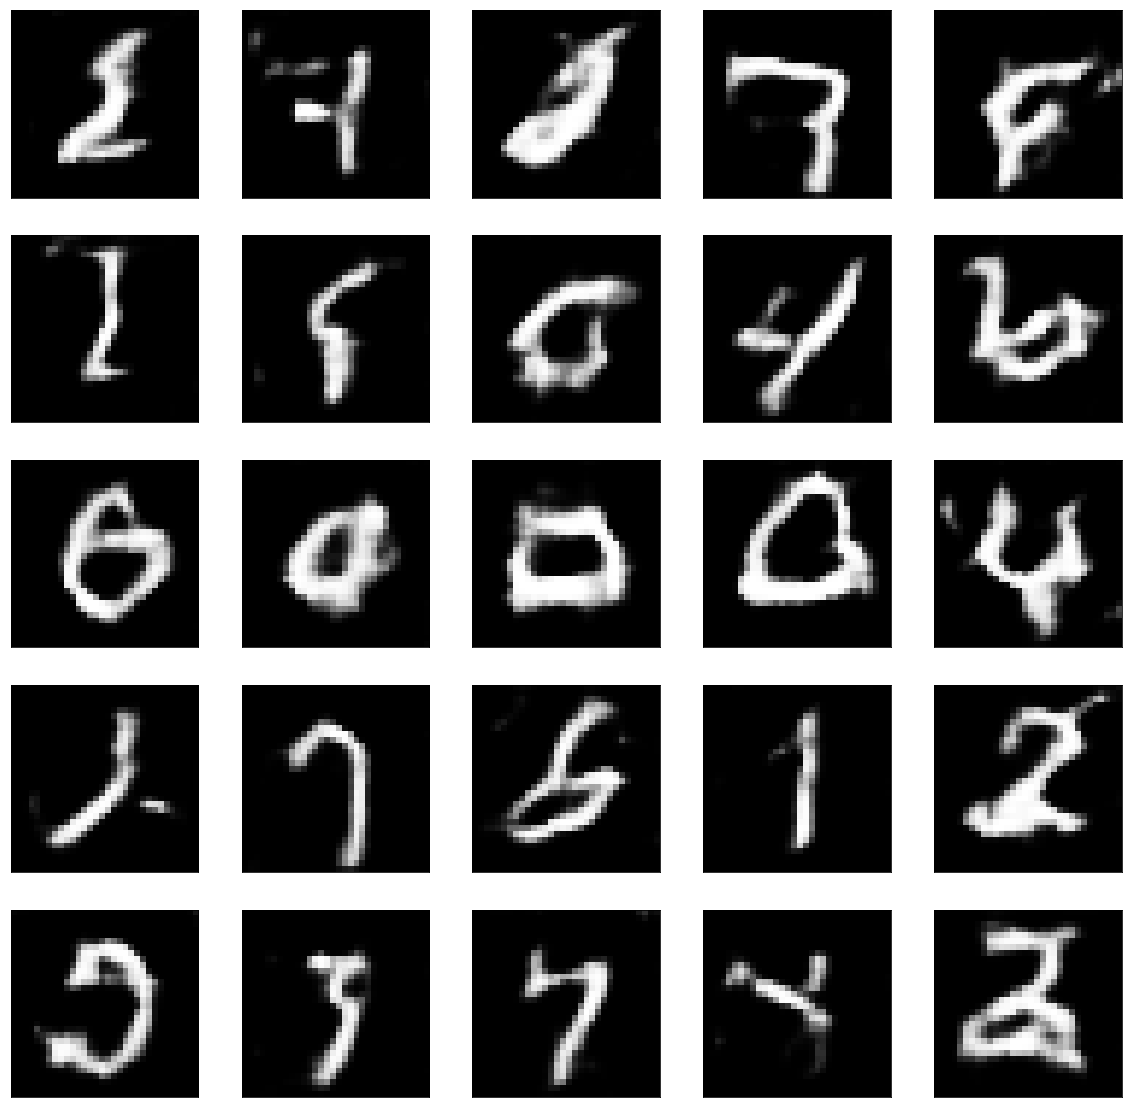

[Epoch 3/10] [Batch 387/938] [Generator loss: 1.243392] [Discriminator loss: 0.525450]
[Epoch 3/10] [Batch 388/938] [Generator loss: 0.907142] [Discriminator loss: 0.597745]
[Epoch 3/10] [Batch 389/938] [Generator loss: 0.685861] [Discriminator loss: 0.637615]
[Epoch 3/10] [Batch 390/938] [Generator loss: 0.749227] [Discriminator loss: 0.567688]
[Epoch 3/10] [Batch 391/938] [Generator loss: 0.819704] [Discriminator loss: 0.698640]
[Epoch 3/10] [Batch 392/938] [Generator loss: 1.048019] [Discriminator loss: 0.595104]
[Epoch 3/10] [Batch 393/938] [Generator loss: 0.881895] [Discriminator loss: 0.460044]
[Epoch 3/10] [Batch 394/938] [Generator loss: 0.850764] [Discriminator loss: 0.658972]
[Epoch 3/10] [Batch 395/938] [Generator loss: 0.961751] [Discriminator loss: 0.668417]
[Epoch 3/10] [Batch 396/938] [Generator loss: 0.843661] [Discriminator loss: 0.592728]
[Epoch 3/10] [Batch 397/938] [Generator loss: 0.779401] [Discriminator loss: 0.586527]
[Epoch 3/10] [Batch 398/938] [Generator los

[Epoch 3/10] [Batch 490/938] [Generator loss: 1.041081] [Discriminator loss: 0.565213]
[Epoch 3/10] [Batch 491/938] [Generator loss: 0.797482] [Discriminator loss: 0.572979]
[Epoch 3/10] [Batch 492/938] [Generator loss: 0.724707] [Discriminator loss: 0.594517]
[Epoch 3/10] [Batch 493/938] [Generator loss: 1.059179] [Discriminator loss: 0.455702]
[Epoch 3/10] [Batch 494/938] [Generator loss: 0.861258] [Discriminator loss: 0.549175]
[Epoch 3/10] [Batch 495/938] [Generator loss: 1.047605] [Discriminator loss: 0.593045]
[Epoch 3/10] [Batch 496/938] [Generator loss: 0.962103] [Discriminator loss: 0.595770]
[Epoch 3/10] [Batch 497/938] [Generator loss: 1.020638] [Discriminator loss: 0.588996]
[Epoch 3/10] [Batch 498/938] [Generator loss: 0.993624] [Discriminator loss: 0.453568]
[Epoch 3/10] [Batch 499/938] [Generator loss: 1.080842] [Discriminator loss: 0.504127]
[Epoch 3/10] [Batch 500/938] [Generator loss: 1.150180] [Discriminator loss: 0.557490]
[Epoch 3/10] [Batch 501/938] [Generator los

[Epoch 3/10] [Batch 589/938] [Generator loss: 0.933180] [Discriminator loss: 0.640192]
[Epoch 3/10] [Batch 590/938] [Generator loss: 0.804433] [Discriminator loss: 0.530585]
[Epoch 3/10] [Batch 591/938] [Generator loss: 1.258693] [Discriminator loss: 0.578241]
[Epoch 3/10] [Batch 592/938] [Generator loss: 1.045639] [Discriminator loss: 0.667268]
[Epoch 3/10] [Batch 593/938] [Generator loss: 0.765969] [Discriminator loss: 0.714460]
[Epoch 3/10] [Batch 594/938] [Generator loss: 0.916586] [Discriminator loss: 0.560302]
[Epoch 3/10] [Batch 595/938] [Generator loss: 0.783989] [Discriminator loss: 0.509006]
[Epoch 3/10] [Batch 596/938] [Generator loss: 1.133753] [Discriminator loss: 0.669207]
[Epoch 3/10] [Batch 597/938] [Generator loss: 0.754629] [Discriminator loss: 0.628220]
[Epoch 3/10] [Batch 598/938] [Generator loss: 0.905558] [Discriminator loss: 0.736226]
[Epoch 3/10] [Batch 599/938] [Generator loss: 1.021922] [Discriminator loss: 0.581868]
[Epoch 3/10] [Batch 600/938] [Generator los

[Epoch 3/10] [Batch 688/938] [Generator loss: 0.842740] [Discriminator loss: 0.667781]
[Epoch 3/10] [Batch 689/938] [Generator loss: 0.994760] [Discriminator loss: 0.529462]
[Epoch 3/10] [Batch 690/938] [Generator loss: 1.102581] [Discriminator loss: 0.617295]
[Epoch 3/10] [Batch 691/938] [Generator loss: 0.878082] [Discriminator loss: 0.581835]
[Epoch 3/10] [Batch 692/938] [Generator loss: 0.806235] [Discriminator loss: 0.739100]
[Epoch 3/10] [Batch 693/938] [Generator loss: 0.655056] [Discriminator loss: 0.594409]
[Epoch 3/10] [Batch 694/938] [Generator loss: 0.754521] [Discriminator loss: 0.569390]
[Epoch 3/10] [Batch 695/938] [Generator loss: 1.028060] [Discriminator loss: 0.600505]
[Epoch 3/10] [Batch 696/938] [Generator loss: 1.020102] [Discriminator loss: 0.658095]
[Epoch 3/10] [Batch 697/938] [Generator loss: 0.959008] [Discriminator loss: 0.504621]
[Epoch 3/10] [Batch 698/938] [Generator loss: 0.872077] [Discriminator loss: 0.693478]
[Epoch 3/10] [Batch 699/938] [Generator los

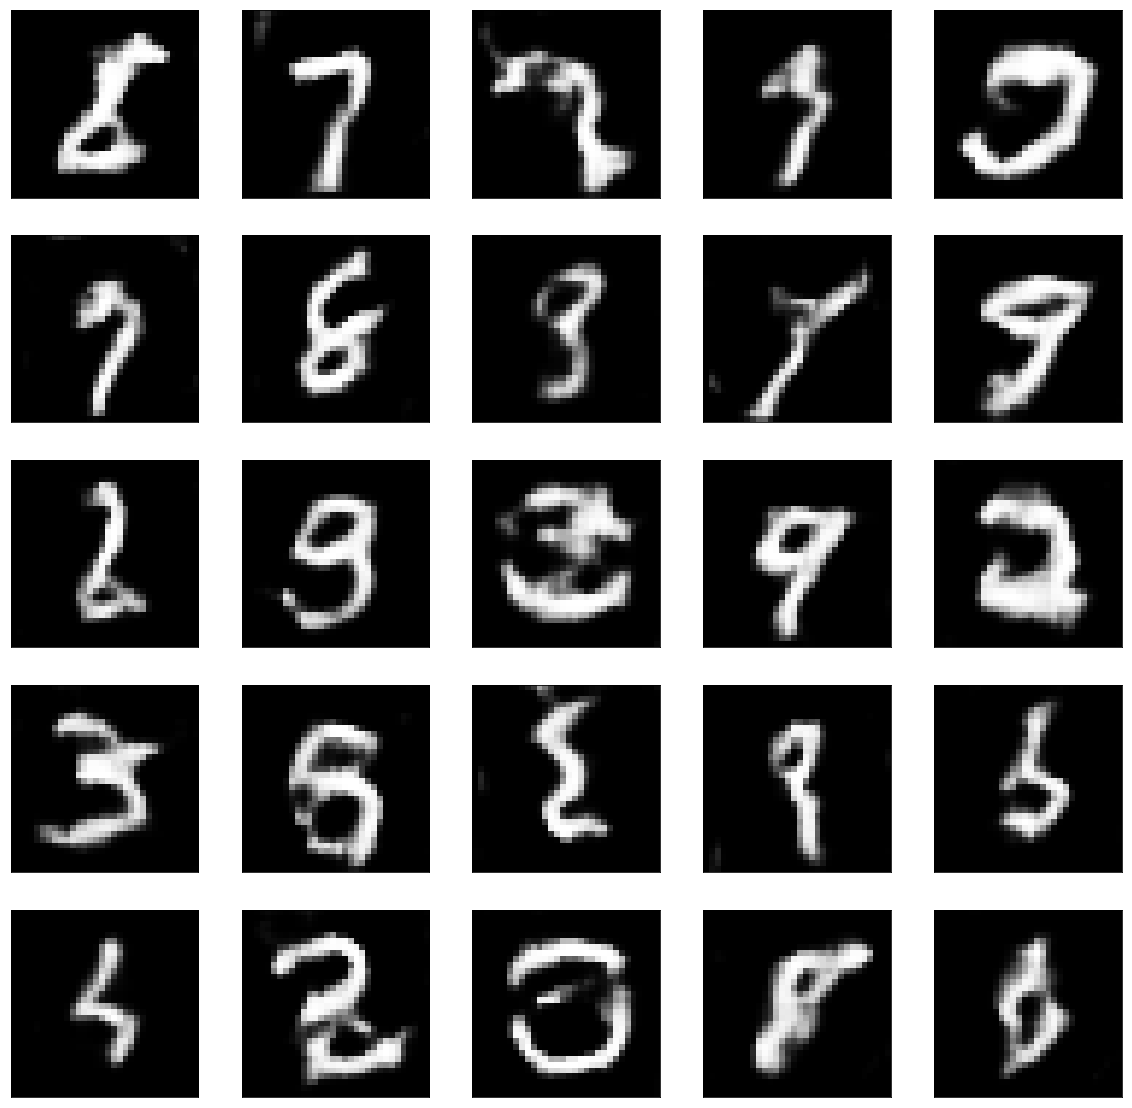

[Epoch 3/10] [Batch 787/938] [Generator loss: 0.964673] [Discriminator loss: 0.618881]
[Epoch 3/10] [Batch 788/938] [Generator loss: 0.766859] [Discriminator loss: 0.519660]
[Epoch 3/10] [Batch 789/938] [Generator loss: 0.796671] [Discriminator loss: 0.662388]
[Epoch 3/10] [Batch 790/938] [Generator loss: 0.768109] [Discriminator loss: 0.583499]
[Epoch 3/10] [Batch 791/938] [Generator loss: 0.742989] [Discriminator loss: 0.558429]
[Epoch 3/10] [Batch 792/938] [Generator loss: 0.856305] [Discriminator loss: 0.718664]
[Epoch 3/10] [Batch 793/938] [Generator loss: 0.887863] [Discriminator loss: 0.562300]
[Epoch 3/10] [Batch 794/938] [Generator loss: 0.776863] [Discriminator loss: 0.659744]
[Epoch 3/10] [Batch 795/938] [Generator loss: 0.799861] [Discriminator loss: 0.537247]
[Epoch 3/10] [Batch 796/938] [Generator loss: 0.981062] [Discriminator loss: 0.586380]
[Epoch 3/10] [Batch 797/938] [Generator loss: 0.649232] [Discriminator loss: 0.666462]
[Epoch 3/10] [Batch 798/938] [Generator los

[Epoch 3/10] [Batch 889/938] [Generator loss: 1.032119] [Discriminator loss: 0.478131]
[Epoch 3/10] [Batch 890/938] [Generator loss: 0.593648] [Discriminator loss: 0.629429]
[Epoch 3/10] [Batch 891/938] [Generator loss: 0.618784] [Discriminator loss: 0.557176]
[Epoch 3/10] [Batch 892/938] [Generator loss: 0.781459] [Discriminator loss: 0.609895]
[Epoch 3/10] [Batch 893/938] [Generator loss: 0.811124] [Discriminator loss: 0.508156]
[Epoch 3/10] [Batch 894/938] [Generator loss: 1.179873] [Discriminator loss: 0.670021]
[Epoch 3/10] [Batch 895/938] [Generator loss: 1.010731] [Discriminator loss: 0.564160]
[Epoch 3/10] [Batch 896/938] [Generator loss: 0.625581] [Discriminator loss: 0.576692]
[Epoch 3/10] [Batch 897/938] [Generator loss: 0.673308] [Discriminator loss: 0.627570]
[Epoch 3/10] [Batch 898/938] [Generator loss: 1.007467] [Discriminator loss: 0.632180]
[Epoch 3/10] [Batch 899/938] [Generator loss: 0.958050] [Discriminator loss: 0.523610]
[Epoch 3/10] [Batch 900/938] [Generator los

[Epoch 4/10] [Batch 46/938] [Generator loss: 0.836877] [Discriminator loss: 0.520290]
[Epoch 4/10] [Batch 47/938] [Generator loss: 0.715529] [Discriminator loss: 0.548359]
[Epoch 4/10] [Batch 48/938] [Generator loss: 0.598843] [Discriminator loss: 0.626590]
[Epoch 4/10] [Batch 49/938] [Generator loss: 0.774843] [Discriminator loss: 0.733631]
[Epoch 4/10] [Batch 50/938] [Generator loss: 0.739497] [Discriminator loss: 0.628950]
[Epoch 4/10] [Batch 51/938] [Generator loss: 0.999884] [Discriminator loss: 0.605289]
[Epoch 4/10] [Batch 52/938] [Generator loss: 0.782184] [Discriminator loss: 0.537309]
[Epoch 4/10] [Batch 53/938] [Generator loss: 1.099460] [Discriminator loss: 0.658595]
[Epoch 4/10] [Batch 54/938] [Generator loss: 1.041621] [Discriminator loss: 0.539274]
[Epoch 4/10] [Batch 55/938] [Generator loss: 0.823525] [Discriminator loss: 0.558572]
[Epoch 4/10] [Batch 56/938] [Generator loss: 0.821638] [Discriminator loss: 0.525270]
[Epoch 4/10] [Batch 57/938] [Generator loss: 1.146378]

[Epoch 4/10] [Batch 148/938] [Generator loss: 0.923561] [Discriminator loss: 0.598751]
[Epoch 4/10] [Batch 149/938] [Generator loss: 0.869196] [Discriminator loss: 0.649478]
[Epoch 4/10] [Batch 150/938] [Generator loss: 0.546058] [Discriminator loss: 0.527344]
[Epoch 4/10] [Batch 151/938] [Generator loss: 0.765897] [Discriminator loss: 0.626650]
[Epoch 4/10] [Batch 152/938] [Generator loss: 1.030690] [Discriminator loss: 0.588465]
[Epoch 4/10] [Batch 153/938] [Generator loss: 1.013947] [Discriminator loss: 0.546696]
[Epoch 4/10] [Batch 154/938] [Generator loss: 0.691630] [Discriminator loss: 0.694948]
[Epoch 4/10] [Batch 155/938] [Generator loss: 1.026452] [Discriminator loss: 0.542368]
[Epoch 4/10] [Batch 156/938] [Generator loss: 1.372321] [Discriminator loss: 0.565111]
[Epoch 4/10] [Batch 157/938] [Generator loss: 0.771961] [Discriminator loss: 0.609704]
[Epoch 4/10] [Batch 158/938] [Generator loss: 0.720907] [Discriminator loss: 0.699041]
[Epoch 4/10] [Batch 159/938] [Generator los

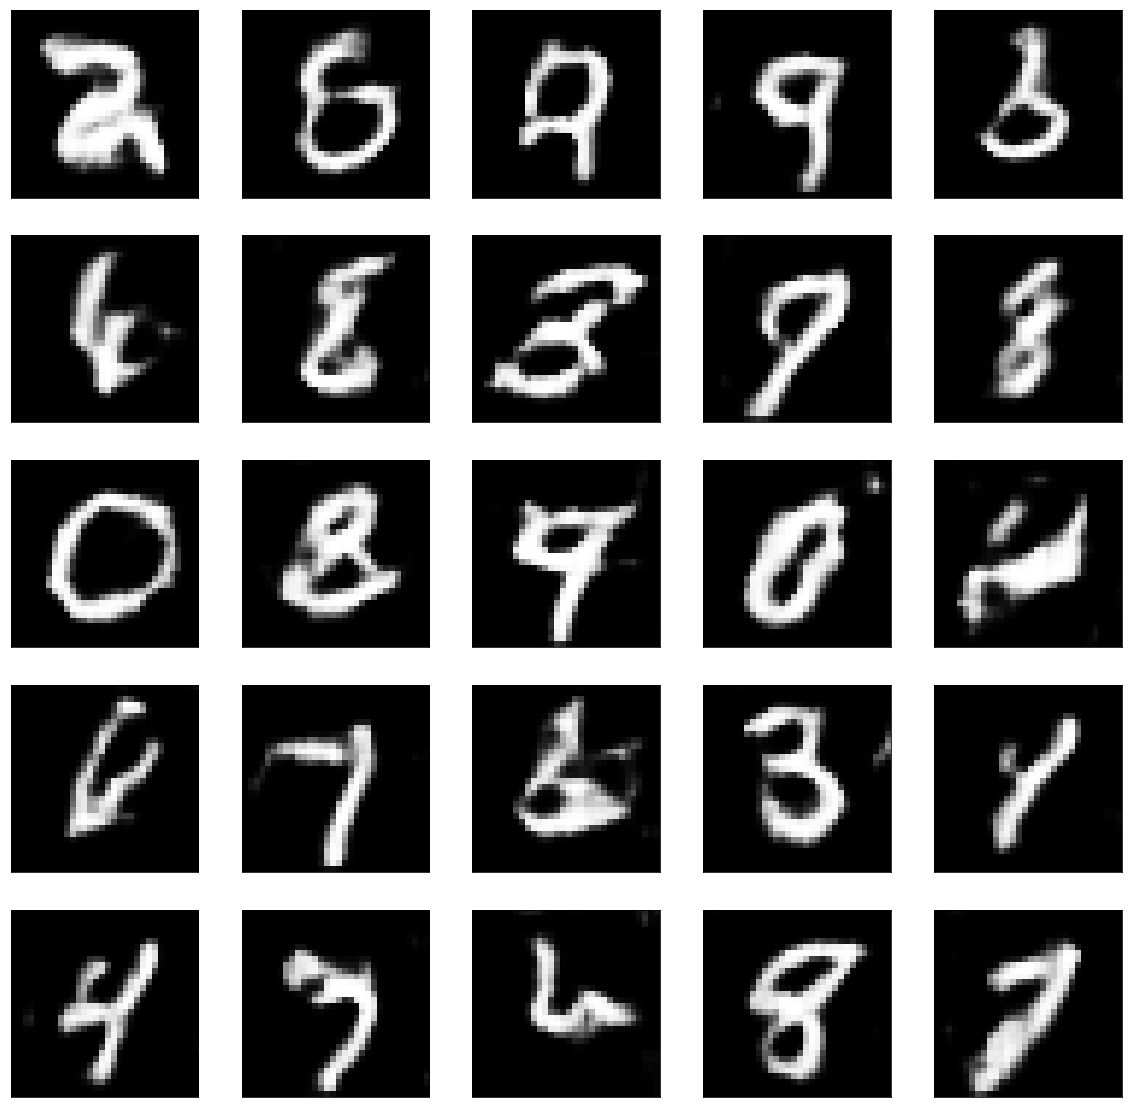

[Epoch 4/10] [Batch 249/938] [Generator loss: 1.115889] [Discriminator loss: 0.481657]
[Epoch 4/10] [Batch 250/938] [Generator loss: 0.802117] [Discriminator loss: 0.652479]
[Epoch 4/10] [Batch 251/938] [Generator loss: 0.566651] [Discriminator loss: 0.719649]
[Epoch 4/10] [Batch 252/938] [Generator loss: 0.728552] [Discriminator loss: 0.737307]
[Epoch 4/10] [Batch 253/938] [Generator loss: 1.109480] [Discriminator loss: 0.636755]
[Epoch 4/10] [Batch 254/938] [Generator loss: 0.825034] [Discriminator loss: 0.571647]
[Epoch 4/10] [Batch 255/938] [Generator loss: 0.728068] [Discriminator loss: 0.572561]
[Epoch 4/10] [Batch 256/938] [Generator loss: 1.106047] [Discriminator loss: 0.598175]
[Epoch 4/10] [Batch 257/938] [Generator loss: 0.911095] [Discriminator loss: 0.641944]
[Epoch 4/10] [Batch 258/938] [Generator loss: 0.765560] [Discriminator loss: 0.476085]
[Epoch 4/10] [Batch 259/938] [Generator loss: 0.905990] [Discriminator loss: 0.506821]
[Epoch 4/10] [Batch 260/938] [Generator los

[Epoch 4/10] [Batch 350/938] [Generator loss: 1.096260] [Discriminator loss: 0.553686]
[Epoch 4/10] [Batch 351/938] [Generator loss: 1.042196] [Discriminator loss: 0.492537]
[Epoch 4/10] [Batch 352/938] [Generator loss: 1.034490] [Discriminator loss: 0.599055]
[Epoch 4/10] [Batch 353/938] [Generator loss: 1.088653] [Discriminator loss: 0.540099]
[Epoch 4/10] [Batch 354/938] [Generator loss: 0.810731] [Discriminator loss: 0.628880]
[Epoch 4/10] [Batch 355/938] [Generator loss: 0.842941] [Discriminator loss: 0.668046]
[Epoch 4/10] [Batch 356/938] [Generator loss: 1.170806] [Discriminator loss: 0.710040]
[Epoch 4/10] [Batch 357/938] [Generator loss: 1.010219] [Discriminator loss: 0.681185]
[Epoch 4/10] [Batch 358/938] [Generator loss: 0.980615] [Discriminator loss: 0.782228]
[Epoch 4/10] [Batch 359/938] [Generator loss: 0.886362] [Discriminator loss: 0.522049]
[Epoch 4/10] [Batch 360/938] [Generator loss: 0.773710] [Discriminator loss: 0.631943]
[Epoch 4/10] [Batch 361/938] [Generator los

[Epoch 4/10] [Batch 445/938] [Generator loss: 0.644788] [Discriminator loss: 0.708947]
[Epoch 4/10] [Batch 446/938] [Generator loss: 0.914149] [Discriminator loss: 0.513110]
[Epoch 4/10] [Batch 447/938] [Generator loss: 0.849537] [Discriminator loss: 0.638738]
[Epoch 4/10] [Batch 448/938] [Generator loss: 0.779640] [Discriminator loss: 0.521549]
[Epoch 4/10] [Batch 449/938] [Generator loss: 0.864074] [Discriminator loss: 0.549989]
[Epoch 4/10] [Batch 450/938] [Generator loss: 1.044698] [Discriminator loss: 0.560971]
[Epoch 4/10] [Batch 451/938] [Generator loss: 0.968331] [Discriminator loss: 0.701538]
[Epoch 4/10] [Batch 452/938] [Generator loss: 0.715701] [Discriminator loss: 0.536554]
[Epoch 4/10] [Batch 453/938] [Generator loss: 0.995290] [Discriminator loss: 0.610369]
[Epoch 4/10] [Batch 454/938] [Generator loss: 0.906344] [Discriminator loss: 0.724290]
[Epoch 4/10] [Batch 455/938] [Generator loss: 0.770618] [Discriminator loss: 0.611213]
[Epoch 4/10] [Batch 456/938] [Generator los

[Epoch 4/10] [Batch 547/938] [Generator loss: 1.048873] [Discriminator loss: 0.648063]
[Epoch 4/10] [Batch 548/938] [Generator loss: 0.978343] [Discriminator loss: 0.649194]
[Epoch 4/10] [Batch 549/938] [Generator loss: 0.989635] [Discriminator loss: 0.582902]
[Epoch 4/10] [Batch 550/938] [Generator loss: 0.831896] [Discriminator loss: 0.672576]
[Epoch 4/10] [Batch 551/938] [Generator loss: 1.034347] [Discriminator loss: 0.568480]
[Epoch 4/10] [Batch 552/938] [Generator loss: 0.855976] [Discriminator loss: 0.702728]
[Epoch 4/10] [Batch 553/938] [Generator loss: 1.039676] [Discriminator loss: 0.741543]
[Epoch 4/10] [Batch 554/938] [Generator loss: 0.850078] [Discriminator loss: 0.702552]
[Epoch 4/10] [Batch 555/938] [Generator loss: 0.954434] [Discriminator loss: 0.546352]
[Epoch 4/10] [Batch 556/938] [Generator loss: 0.863835] [Discriminator loss: 0.634968]
[Epoch 4/10] [Batch 557/938] [Generator loss: 0.919264] [Discriminator loss: 0.469144]
[Epoch 4/10] [Batch 558/938] [Generator los

[Epoch 4/10] [Batch 648/938] [Generator loss: 1.073750] [Discriminator loss: 0.641728]


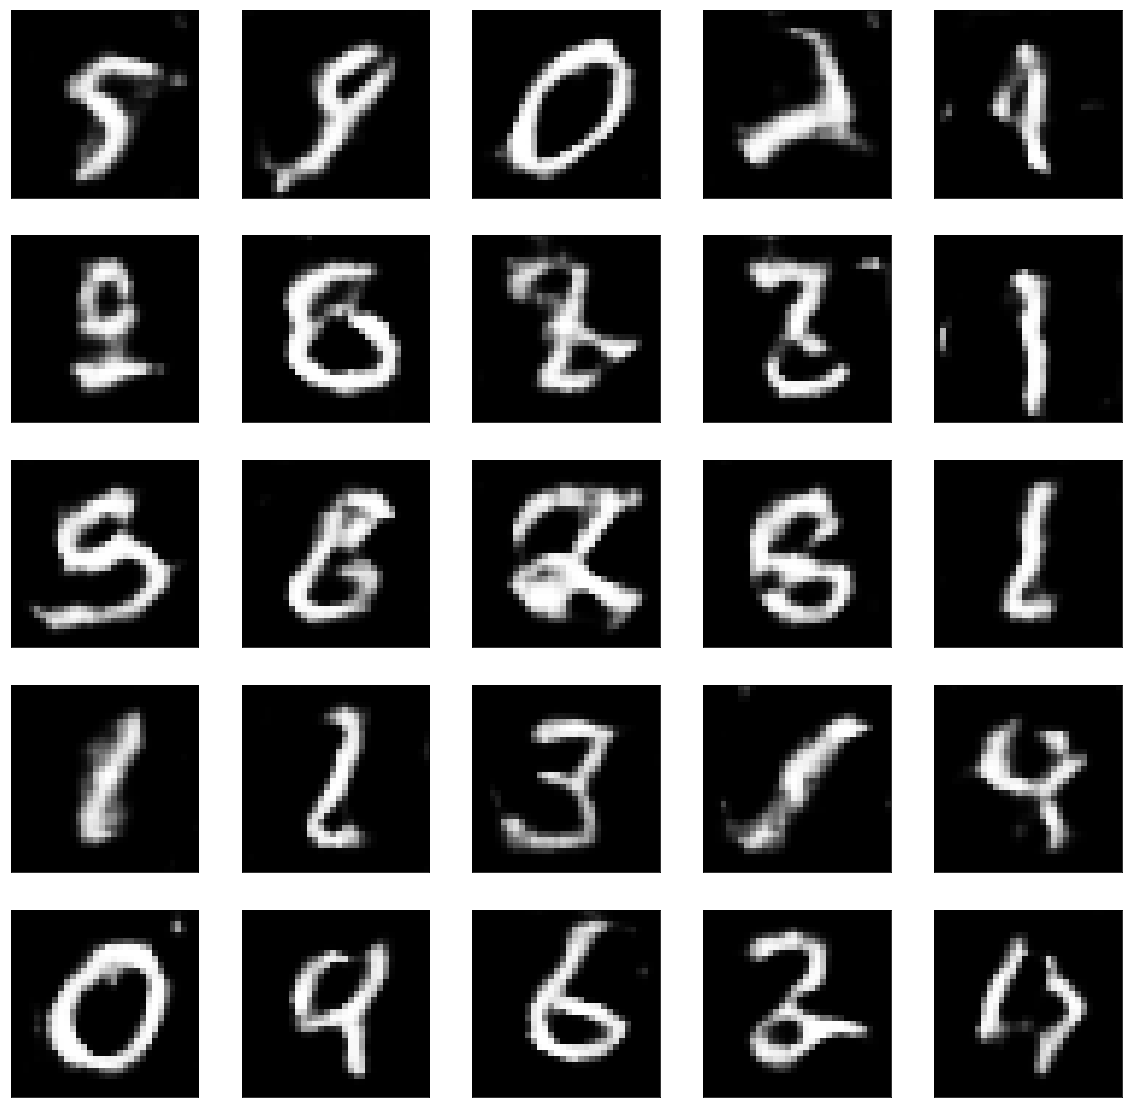

[Epoch 4/10] [Batch 649/938] [Generator loss: 1.296606] [Discriminator loss: 0.451995]
[Epoch 4/10] [Batch 650/938] [Generator loss: 1.043973] [Discriminator loss: 0.694151]
[Epoch 4/10] [Batch 651/938] [Generator loss: 0.890251] [Discriminator loss: 0.604434]
[Epoch 4/10] [Batch 652/938] [Generator loss: 0.778192] [Discriminator loss: 0.596950]
[Epoch 4/10] [Batch 653/938] [Generator loss: 0.771887] [Discriminator loss: 0.650044]
[Epoch 4/10] [Batch 654/938] [Generator loss: 0.920119] [Discriminator loss: 0.712844]
[Epoch 4/10] [Batch 655/938] [Generator loss: 1.068235] [Discriminator loss: 0.571832]
[Epoch 4/10] [Batch 656/938] [Generator loss: 0.601054] [Discriminator loss: 0.678298]
[Epoch 4/10] [Batch 657/938] [Generator loss: 0.939542] [Discriminator loss: 0.513930]
[Epoch 4/10] [Batch 658/938] [Generator loss: 1.061554] [Discriminator loss: 0.719537]
[Epoch 4/10] [Batch 659/938] [Generator loss: 1.476077] [Discriminator loss: 0.584734]
[Epoch 4/10] [Batch 660/938] [Generator los

[Epoch 4/10] [Batch 749/938] [Generator loss: 0.984109] [Discriminator loss: 0.582301]
[Epoch 4/10] [Batch 750/938] [Generator loss: 0.901680] [Discriminator loss: 0.671254]
[Epoch 4/10] [Batch 751/938] [Generator loss: 0.860854] [Discriminator loss: 0.549599]
[Epoch 4/10] [Batch 752/938] [Generator loss: 0.568569] [Discriminator loss: 0.598718]
[Epoch 4/10] [Batch 753/938] [Generator loss: 0.837649] [Discriminator loss: 0.541877]
[Epoch 4/10] [Batch 754/938] [Generator loss: 1.040189] [Discriminator loss: 0.685203]
[Epoch 4/10] [Batch 755/938] [Generator loss: 0.773376] [Discriminator loss: 0.596392]
[Epoch 4/10] [Batch 756/938] [Generator loss: 0.831588] [Discriminator loss: 0.477065]
[Epoch 4/10] [Batch 757/938] [Generator loss: 1.109219] [Discriminator loss: 0.496744]
[Epoch 4/10] [Batch 758/938] [Generator loss: 1.257990] [Discriminator loss: 0.677085]
[Epoch 4/10] [Batch 759/938] [Generator loss: 1.060163] [Discriminator loss: 0.542953]
[Epoch 4/10] [Batch 760/938] [Generator los

[Epoch 4/10] [Batch 848/938] [Generator loss: 0.810442] [Discriminator loss: 0.577017]
[Epoch 4/10] [Batch 849/938] [Generator loss: 0.842211] [Discriminator loss: 0.593066]
[Epoch 4/10] [Batch 850/938] [Generator loss: 0.832564] [Discriminator loss: 0.544597]
[Epoch 4/10] [Batch 851/938] [Generator loss: 0.991070] [Discriminator loss: 0.501598]
[Epoch 4/10] [Batch 852/938] [Generator loss: 0.827540] [Discriminator loss: 0.676233]
[Epoch 4/10] [Batch 853/938] [Generator loss: 1.016040] [Discriminator loss: 0.507872]
[Epoch 4/10] [Batch 854/938] [Generator loss: 0.957038] [Discriminator loss: 0.600167]
[Epoch 4/10] [Batch 855/938] [Generator loss: 0.645728] [Discriminator loss: 0.590488]
[Epoch 4/10] [Batch 856/938] [Generator loss: 1.202163] [Discriminator loss: 0.560094]
[Epoch 4/10] [Batch 857/938] [Generator loss: 1.384046] [Discriminator loss: 0.639392]
[Epoch 4/10] [Batch 858/938] [Generator loss: 0.970495] [Discriminator loss: 0.575829]
[Epoch 4/10] [Batch 859/938] [Generator los

[Epoch 5/10] [Batch 6/938] [Generator loss: 0.711507] [Discriminator loss: 0.460072]
[Epoch 5/10] [Batch 7/938] [Generator loss: 0.785421] [Discriminator loss: 0.531474]
[Epoch 5/10] [Batch 8/938] [Generator loss: 0.836600] [Discriminator loss: 0.612244]
[Epoch 5/10] [Batch 9/938] [Generator loss: 1.186411] [Discriminator loss: 0.579137]
[Epoch 5/10] [Batch 10/938] [Generator loss: 1.102370] [Discriminator loss: 0.558952]
[Epoch 5/10] [Batch 11/938] [Generator loss: 0.615601] [Discriminator loss: 0.617194]
[Epoch 5/10] [Batch 12/938] [Generator loss: 0.765657] [Discriminator loss: 0.868342]
[Epoch 5/10] [Batch 13/938] [Generator loss: 1.117905] [Discriminator loss: 0.500651]
[Epoch 5/10] [Batch 14/938] [Generator loss: 0.786982] [Discriminator loss: 0.825658]
[Epoch 5/10] [Batch 15/938] [Generator loss: 0.958393] [Discriminator loss: 0.490190]
[Epoch 5/10] [Batch 16/938] [Generator loss: 0.877855] [Discriminator loss: 0.581659]
[Epoch 5/10] [Batch 17/938] [Generator loss: 0.906062] [Di

[Epoch 5/10] [Batch 102/938] [Generator loss: 0.861804] [Discriminator loss: 0.607004]
[Epoch 5/10] [Batch 103/938] [Generator loss: 1.065909] [Discriminator loss: 0.656689]
[Epoch 5/10] [Batch 104/938] [Generator loss: 0.868418] [Discriminator loss: 0.664059]
[Epoch 5/10] [Batch 105/938] [Generator loss: 0.818871] [Discriminator loss: 0.576691]
[Epoch 5/10] [Batch 106/938] [Generator loss: 0.448120] [Discriminator loss: 0.568544]
[Epoch 5/10] [Batch 107/938] [Generator loss: 0.937998] [Discriminator loss: 0.724206]
[Epoch 5/10] [Batch 108/938] [Generator loss: 1.024541] [Discriminator loss: 0.587152]
[Epoch 5/10] [Batch 109/938] [Generator loss: 0.940062] [Discriminator loss: 0.554193]
[Epoch 5/10] [Batch 110/938] [Generator loss: 1.164863] [Discriminator loss: 0.471259]


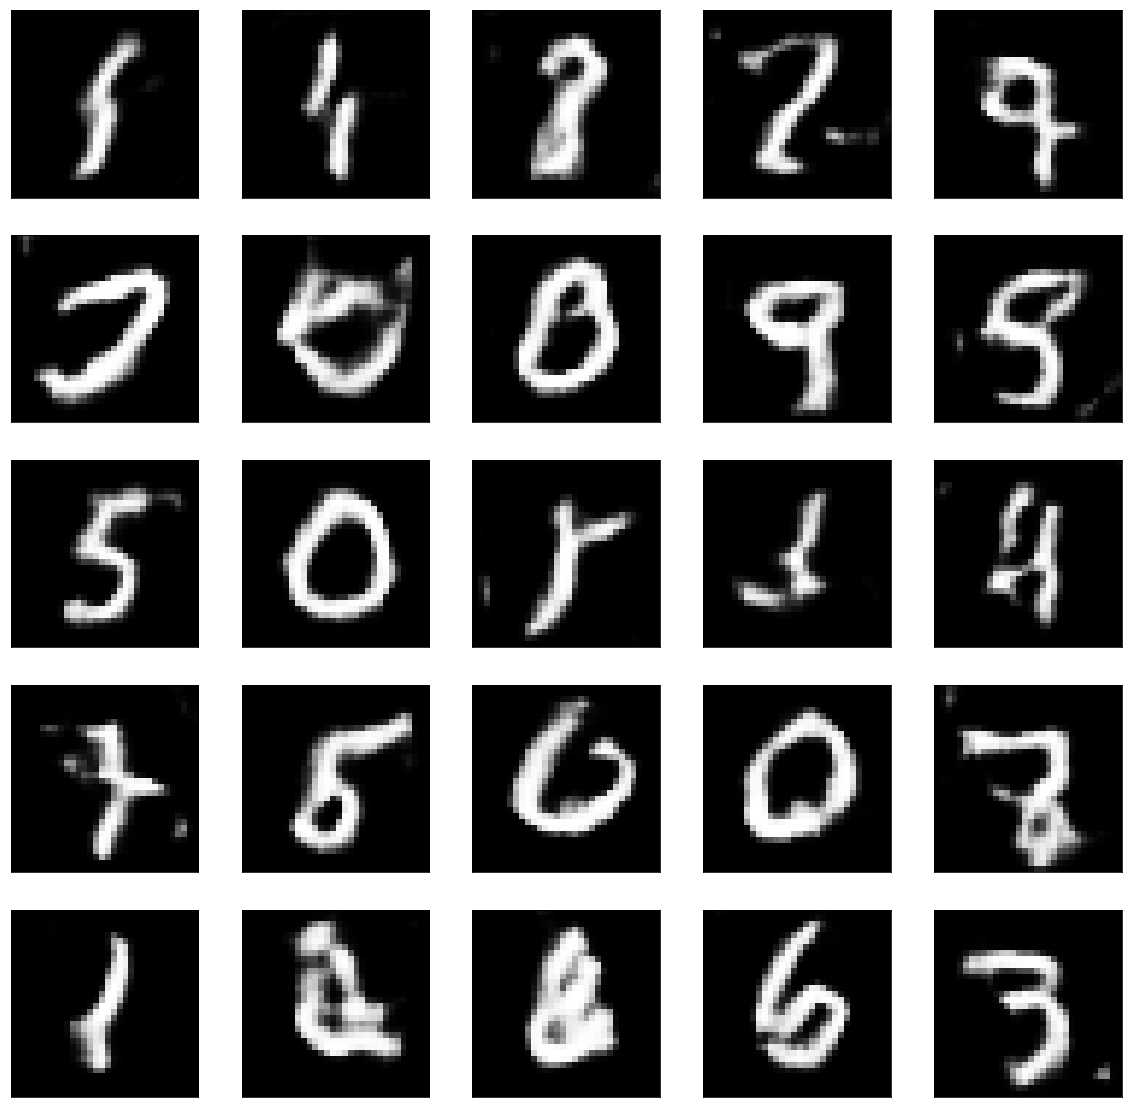

[Epoch 5/10] [Batch 111/938] [Generator loss: 0.951254] [Discriminator loss: 0.614222]
[Epoch 5/10] [Batch 112/938] [Generator loss: 0.742254] [Discriminator loss: 0.596725]
[Epoch 5/10] [Batch 113/938] [Generator loss: 0.881805] [Discriminator loss: 0.531043]
[Epoch 5/10] [Batch 114/938] [Generator loss: 0.772435] [Discriminator loss: 0.615999]
[Epoch 5/10] [Batch 115/938] [Generator loss: 0.789760] [Discriminator loss: 0.629067]
[Epoch 5/10] [Batch 116/938] [Generator loss: 0.898089] [Discriminator loss: 0.469407]
[Epoch 5/10] [Batch 117/938] [Generator loss: 1.166813] [Discriminator loss: 0.481170]
[Epoch 5/10] [Batch 118/938] [Generator loss: 1.061245] [Discriminator loss: 0.450590]
[Epoch 5/10] [Batch 119/938] [Generator loss: 0.807523] [Discriminator loss: 0.625038]
[Epoch 5/10] [Batch 120/938] [Generator loss: 0.867399] [Discriminator loss: 0.597374]
[Epoch 5/10] [Batch 121/938] [Generator loss: 1.076998] [Discriminator loss: 0.526579]
[Epoch 5/10] [Batch 122/938] [Generator los

[Epoch 5/10] [Batch 211/938] [Generator loss: 0.982383] [Discriminator loss: 0.546202]
[Epoch 5/10] [Batch 212/938] [Generator loss: 0.937291] [Discriminator loss: 0.592151]
[Epoch 5/10] [Batch 213/938] [Generator loss: 0.832656] [Discriminator loss: 0.547170]
[Epoch 5/10] [Batch 214/938] [Generator loss: 0.692462] [Discriminator loss: 0.700147]
[Epoch 5/10] [Batch 215/938] [Generator loss: 1.037781] [Discriminator loss: 0.551808]
[Epoch 5/10] [Batch 216/938] [Generator loss: 1.018163] [Discriminator loss: 0.513326]
[Epoch 5/10] [Batch 217/938] [Generator loss: 1.106460] [Discriminator loss: 0.540863]
[Epoch 5/10] [Batch 218/938] [Generator loss: 1.197587] [Discriminator loss: 0.529624]
[Epoch 5/10] [Batch 219/938] [Generator loss: 0.935168] [Discriminator loss: 0.613680]
[Epoch 5/10] [Batch 220/938] [Generator loss: 1.214636] [Discriminator loss: 0.526009]
[Epoch 5/10] [Batch 221/938] [Generator loss: 0.699851] [Discriminator loss: 0.529974]
[Epoch 5/10] [Batch 222/938] [Generator los

[Epoch 5/10] [Batch 313/938] [Generator loss: 0.906704] [Discriminator loss: 0.585489]
[Epoch 5/10] [Batch 314/938] [Generator loss: 1.040108] [Discriminator loss: 0.605560]
[Epoch 5/10] [Batch 315/938] [Generator loss: 1.038979] [Discriminator loss: 0.639574]
[Epoch 5/10] [Batch 316/938] [Generator loss: 0.913139] [Discriminator loss: 0.703558]
[Epoch 5/10] [Batch 317/938] [Generator loss: 0.742853] [Discriminator loss: 0.495200]
[Epoch 5/10] [Batch 318/938] [Generator loss: 0.969000] [Discriminator loss: 0.612139]
[Epoch 5/10] [Batch 319/938] [Generator loss: 0.907446] [Discriminator loss: 0.564950]
[Epoch 5/10] [Batch 320/938] [Generator loss: 1.166841] [Discriminator loss: 0.580152]
[Epoch 5/10] [Batch 321/938] [Generator loss: 0.795206] [Discriminator loss: 0.530668]
[Epoch 5/10] [Batch 322/938] [Generator loss: 0.663161] [Discriminator loss: 0.642426]
[Epoch 5/10] [Batch 323/938] [Generator loss: 0.994364] [Discriminator loss: 0.685044]
[Epoch 5/10] [Batch 324/938] [Generator los

[Epoch 5/10] [Batch 409/938] [Generator loss: 0.771639] [Discriminator loss: 0.574315]
[Epoch 5/10] [Batch 410/938] [Generator loss: 1.130866] [Discriminator loss: 0.494088]
[Epoch 5/10] [Batch 411/938] [Generator loss: 0.773796] [Discriminator loss: 0.688975]
[Epoch 5/10] [Batch 412/938] [Generator loss: 0.897019] [Discriminator loss: 0.589907]
[Epoch 5/10] [Batch 413/938] [Generator loss: 0.892709] [Discriminator loss: 0.510109]
[Epoch 5/10] [Batch 414/938] [Generator loss: 0.875674] [Discriminator loss: 0.442267]
[Epoch 5/10] [Batch 415/938] [Generator loss: 0.814047] [Discriminator loss: 0.463585]
[Epoch 5/10] [Batch 416/938] [Generator loss: 0.621016] [Discriminator loss: 0.854778]
[Epoch 5/10] [Batch 417/938] [Generator loss: 0.763103] [Discriminator loss: 0.588842]
[Epoch 5/10] [Batch 418/938] [Generator loss: 1.200158] [Discriminator loss: 0.657184]
[Epoch 5/10] [Batch 419/938] [Generator loss: 1.082321] [Discriminator loss: 0.754581]
[Epoch 5/10] [Batch 420/938] [Generator los

[Epoch 5/10] [Batch 504/938] [Generator loss: 1.170974] [Discriminator loss: 0.544236]
[Epoch 5/10] [Batch 505/938] [Generator loss: 1.063872] [Discriminator loss: 0.649230]
[Epoch 5/10] [Batch 506/938] [Generator loss: 1.212221] [Discriminator loss: 0.568058]
[Epoch 5/10] [Batch 507/938] [Generator loss: 0.910682] [Discriminator loss: 0.572611]
[Epoch 5/10] [Batch 508/938] [Generator loss: 1.148096] [Discriminator loss: 0.654995]
[Epoch 5/10] [Batch 509/938] [Generator loss: 0.970479] [Discriminator loss: 0.504916]
[Epoch 5/10] [Batch 510/938] [Generator loss: 0.814660] [Discriminator loss: 0.705410]


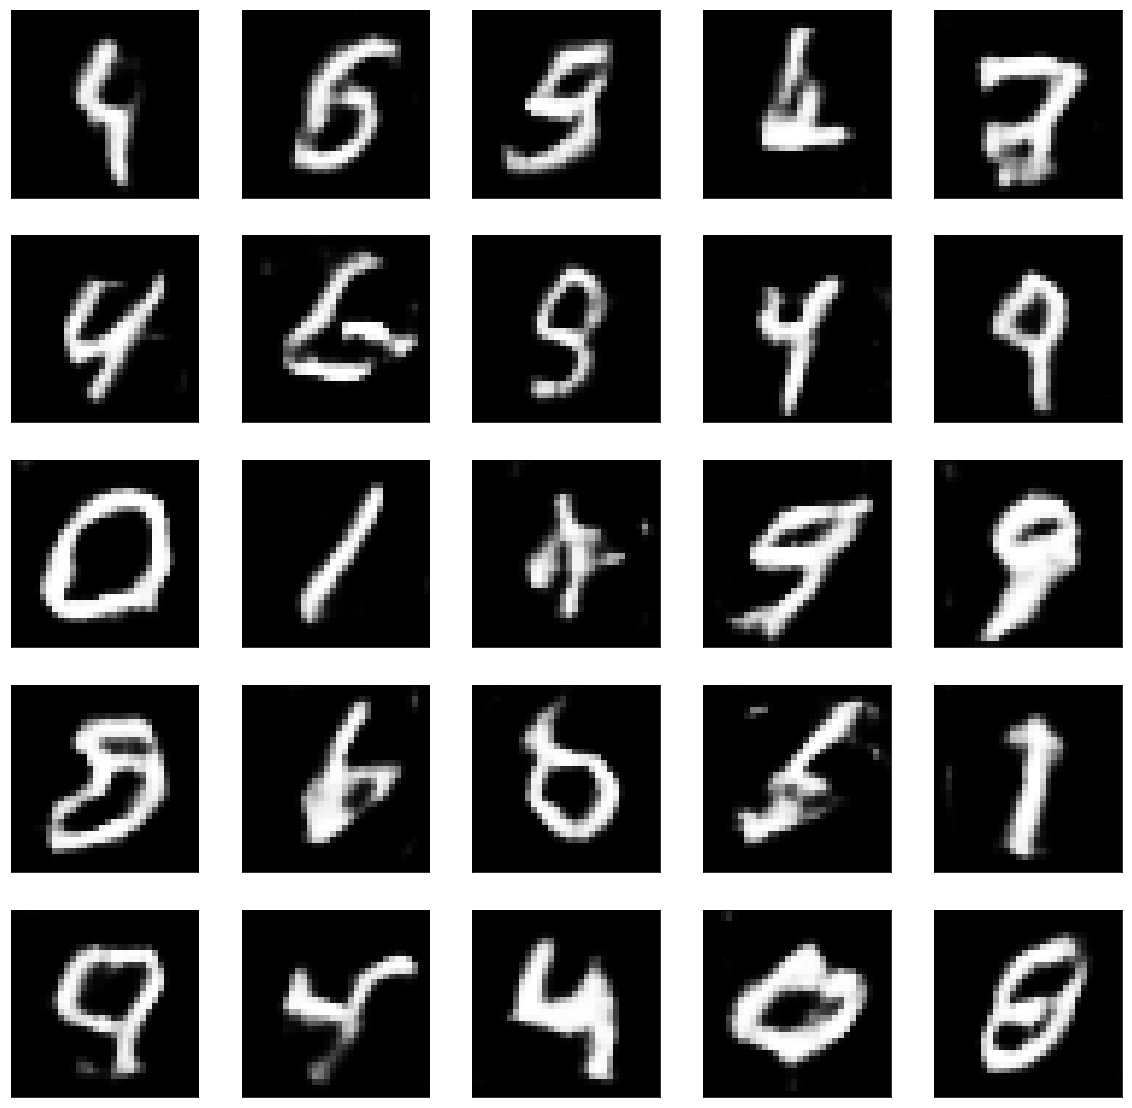

[Epoch 5/10] [Batch 511/938] [Generator loss: 0.937438] [Discriminator loss: 0.644875]
[Epoch 5/10] [Batch 512/938] [Generator loss: 1.042168] [Discriminator loss: 0.561033]
[Epoch 5/10] [Batch 513/938] [Generator loss: 1.608562] [Discriminator loss: 0.662339]
[Epoch 5/10] [Batch 514/938] [Generator loss: 1.332907] [Discriminator loss: 0.617716]
[Epoch 5/10] [Batch 515/938] [Generator loss: 0.626406] [Discriminator loss: 0.680411]
[Epoch 5/10] [Batch 516/938] [Generator loss: 0.671344] [Discriminator loss: 0.667644]
[Epoch 5/10] [Batch 517/938] [Generator loss: 0.996332] [Discriminator loss: 0.633677]
[Epoch 5/10] [Batch 518/938] [Generator loss: 0.958624] [Discriminator loss: 0.695823]
[Epoch 5/10] [Batch 519/938] [Generator loss: 1.126498] [Discriminator loss: 0.482161]
[Epoch 5/10] [Batch 520/938] [Generator loss: 0.940345] [Discriminator loss: 0.510734]
[Epoch 5/10] [Batch 521/938] [Generator loss: 0.646472] [Discriminator loss: 0.594814]
[Epoch 5/10] [Batch 522/938] [Generator los

[Epoch 5/10] [Batch 611/938] [Generator loss: 0.943349] [Discriminator loss: 0.533494]
[Epoch 5/10] [Batch 612/938] [Generator loss: 0.864752] [Discriminator loss: 0.483835]
[Epoch 5/10] [Batch 613/938] [Generator loss: 1.602487] [Discriminator loss: 0.645065]
[Epoch 5/10] [Batch 614/938] [Generator loss: 0.911714] [Discriminator loss: 0.523805]
[Epoch 5/10] [Batch 615/938] [Generator loss: 0.547098] [Discriminator loss: 0.555939]
[Epoch 5/10] [Batch 616/938] [Generator loss: 0.896097] [Discriminator loss: 0.577096]
[Epoch 5/10] [Batch 617/938] [Generator loss: 1.109273] [Discriminator loss: 0.736969]
[Epoch 5/10] [Batch 618/938] [Generator loss: 0.677567] [Discriminator loss: 0.601894]
[Epoch 5/10] [Batch 619/938] [Generator loss: 1.037095] [Discriminator loss: 0.700414]
[Epoch 5/10] [Batch 620/938] [Generator loss: 0.986552] [Discriminator loss: 0.585095]
[Epoch 5/10] [Batch 621/938] [Generator loss: 0.762459] [Discriminator loss: 0.739752]
[Epoch 5/10] [Batch 622/938] [Generator los

[Epoch 5/10] [Batch 709/938] [Generator loss: 0.600600] [Discriminator loss: 0.726111]
[Epoch 5/10] [Batch 710/938] [Generator loss: 0.786179] [Discriminator loss: 0.716126]
[Epoch 5/10] [Batch 711/938] [Generator loss: 0.731340] [Discriminator loss: 0.621101]
[Epoch 5/10] [Batch 712/938] [Generator loss: 1.087009] [Discriminator loss: 0.474946]
[Epoch 5/10] [Batch 713/938] [Generator loss: 1.058153] [Discriminator loss: 0.742668]
[Epoch 5/10] [Batch 714/938] [Generator loss: 0.926280] [Discriminator loss: 0.660120]
[Epoch 5/10] [Batch 715/938] [Generator loss: 0.735464] [Discriminator loss: 0.605685]
[Epoch 5/10] [Batch 716/938] [Generator loss: 0.893514] [Discriminator loss: 0.447122]
[Epoch 5/10] [Batch 717/938] [Generator loss: 1.132409] [Discriminator loss: 0.473994]
[Epoch 5/10] [Batch 718/938] [Generator loss: 0.730695] [Discriminator loss: 0.601628]
[Epoch 5/10] [Batch 719/938] [Generator loss: 0.829988] [Discriminator loss: 0.462294]
[Epoch 5/10] [Batch 720/938] [Generator los

[Epoch 5/10] [Batch 804/938] [Generator loss: 0.737319] [Discriminator loss: 0.468771]
[Epoch 5/10] [Batch 805/938] [Generator loss: 0.742285] [Discriminator loss: 0.582605]
[Epoch 5/10] [Batch 806/938] [Generator loss: 1.007452] [Discriminator loss: 0.569359]
[Epoch 5/10] [Batch 807/938] [Generator loss: 1.148424] [Discriminator loss: 0.553333]
[Epoch 5/10] [Batch 808/938] [Generator loss: 1.101115] [Discriminator loss: 0.567752]
[Epoch 5/10] [Batch 809/938] [Generator loss: 0.887218] [Discriminator loss: 0.682269]
[Epoch 5/10] [Batch 810/938] [Generator loss: 0.722437] [Discriminator loss: 0.618872]
[Epoch 5/10] [Batch 811/938] [Generator loss: 0.964580] [Discriminator loss: 0.638385]
[Epoch 5/10] [Batch 812/938] [Generator loss: 0.722934] [Discriminator loss: 0.507263]
[Epoch 5/10] [Batch 813/938] [Generator loss: 0.886607] [Discriminator loss: 0.611471]
[Epoch 5/10] [Batch 814/938] [Generator loss: 0.844609] [Discriminator loss: 0.632615]
[Epoch 5/10] [Batch 815/938] [Generator los

[Epoch 5/10] [Batch 903/938] [Generator loss: 1.115172] [Discriminator loss: 0.597510]
[Epoch 5/10] [Batch 904/938] [Generator loss: 1.156362] [Discriminator loss: 0.510367]
[Epoch 5/10] [Batch 905/938] [Generator loss: 1.045565] [Discriminator loss: 0.548963]
[Epoch 5/10] [Batch 906/938] [Generator loss: 1.065377] [Discriminator loss: 0.428868]
[Epoch 5/10] [Batch 907/938] [Generator loss: 0.803224] [Discriminator loss: 0.531875]
[Epoch 5/10] [Batch 908/938] [Generator loss: 1.128399] [Discriminator loss: 0.511216]
[Epoch 5/10] [Batch 909/938] [Generator loss: 1.123181] [Discriminator loss: 0.606869]
[Epoch 5/10] [Batch 910/938] [Generator loss: 0.982238] [Discriminator loss: 0.623058]


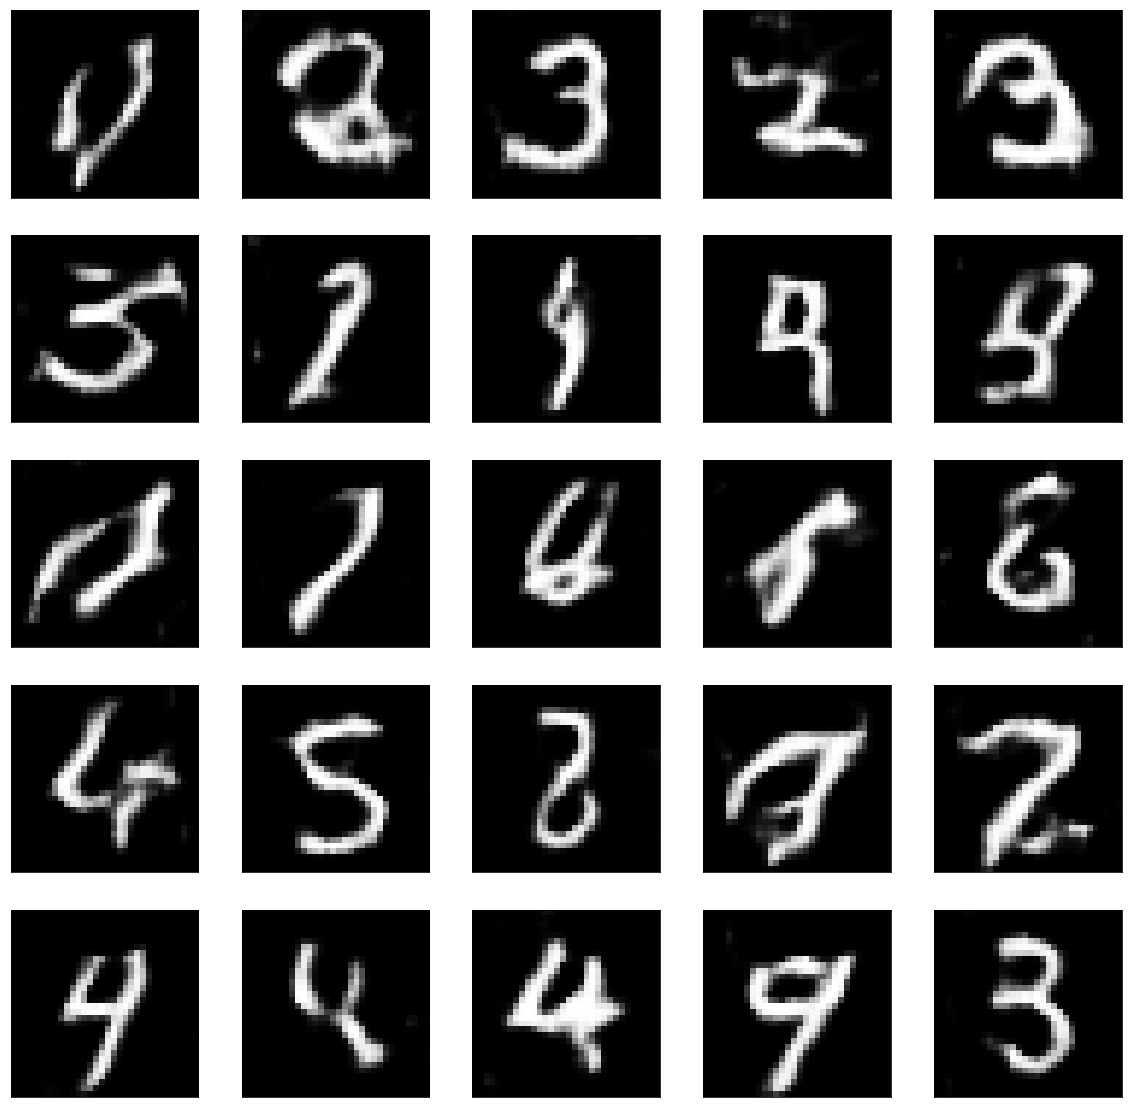

[Epoch 5/10] [Batch 911/938] [Generator loss: 1.271399] [Discriminator loss: 0.691290]
[Epoch 5/10] [Batch 912/938] [Generator loss: 1.030271] [Discriminator loss: 0.666204]
[Epoch 5/10] [Batch 913/938] [Generator loss: 1.000063] [Discriminator loss: 0.592724]
[Epoch 5/10] [Batch 914/938] [Generator loss: 0.747948] [Discriminator loss: 0.659208]
[Epoch 5/10] [Batch 915/938] [Generator loss: 0.910997] [Discriminator loss: 0.528539]
[Epoch 5/10] [Batch 916/938] [Generator loss: 0.752205] [Discriminator loss: 0.543066]
[Epoch 5/10] [Batch 917/938] [Generator loss: 0.821393] [Discriminator loss: 0.650767]
[Epoch 5/10] [Batch 918/938] [Generator loss: 1.117588] [Discriminator loss: 0.607699]
[Epoch 5/10] [Batch 919/938] [Generator loss: 1.381694] [Discriminator loss: 0.531800]
[Epoch 5/10] [Batch 920/938] [Generator loss: 1.168468] [Discriminator loss: 0.597073]
[Epoch 5/10] [Batch 921/938] [Generator loss: 0.881156] [Discriminator loss: 0.685030]
[Epoch 5/10] [Batch 922/938] [Generator los

[Epoch 6/10] [Batch 75/938] [Generator loss: 0.863827] [Discriminator loss: 0.592115]
[Epoch 6/10] [Batch 76/938] [Generator loss: 1.416358] [Discriminator loss: 0.576956]
[Epoch 6/10] [Batch 77/938] [Generator loss: 1.422574] [Discriminator loss: 0.561148]
[Epoch 6/10] [Batch 78/938] [Generator loss: 1.005936] [Discriminator loss: 0.546617]
[Epoch 6/10] [Batch 79/938] [Generator loss: 1.150529] [Discriminator loss: 0.510470]
[Epoch 6/10] [Batch 80/938] [Generator loss: 1.517313] [Discriminator loss: 0.400661]
[Epoch 6/10] [Batch 81/938] [Generator loss: 1.268030] [Discriminator loss: 0.582078]
[Epoch 6/10] [Batch 82/938] [Generator loss: 1.017471] [Discriminator loss: 0.573244]
[Epoch 6/10] [Batch 83/938] [Generator loss: 1.009761] [Discriminator loss: 0.599714]
[Epoch 6/10] [Batch 84/938] [Generator loss: 0.717385] [Discriminator loss: 0.758606]
[Epoch 6/10] [Batch 85/938] [Generator loss: 1.278003] [Discriminator loss: 0.554579]
[Epoch 6/10] [Batch 86/938] [Generator loss: 0.969269]

[Epoch 6/10] [Batch 171/938] [Generator loss: 0.817851] [Discriminator loss: 0.564564]
[Epoch 6/10] [Batch 172/938] [Generator loss: 0.727244] [Discriminator loss: 0.524321]
[Epoch 6/10] [Batch 173/938] [Generator loss: 1.011941] [Discriminator loss: 0.449696]
[Epoch 6/10] [Batch 174/938] [Generator loss: 1.177634] [Discriminator loss: 0.617786]
[Epoch 6/10] [Batch 175/938] [Generator loss: 1.301960] [Discriminator loss: 0.649495]
[Epoch 6/10] [Batch 176/938] [Generator loss: 0.823188] [Discriminator loss: 0.687230]
[Epoch 6/10] [Batch 177/938] [Generator loss: 0.882593] [Discriminator loss: 0.528604]
[Epoch 6/10] [Batch 178/938] [Generator loss: 0.597307] [Discriminator loss: 0.616029]
[Epoch 6/10] [Batch 179/938] [Generator loss: 0.706212] [Discriminator loss: 0.553836]
[Epoch 6/10] [Batch 180/938] [Generator loss: 1.179923] [Discriminator loss: 0.459436]
[Epoch 6/10] [Batch 181/938] [Generator loss: 0.974236] [Discriminator loss: 0.527559]
[Epoch 6/10] [Batch 182/938] [Generator los

[Epoch 6/10] [Batch 266/938] [Generator loss: 1.151631] [Discriminator loss: 0.525957]
[Epoch 6/10] [Batch 267/938] [Generator loss: 0.773790] [Discriminator loss: 0.510696]
[Epoch 6/10] [Batch 268/938] [Generator loss: 0.886514] [Discriminator loss: 0.482824]
[Epoch 6/10] [Batch 269/938] [Generator loss: 0.727649] [Discriminator loss: 0.480003]
[Epoch 6/10] [Batch 270/938] [Generator loss: 1.504587] [Discriminator loss: 0.440565]
[Epoch 6/10] [Batch 271/938] [Generator loss: 1.212819] [Discriminator loss: 0.668909]
[Epoch 6/10] [Batch 272/938] [Generator loss: 0.919563] [Discriminator loss: 0.662996]
[Epoch 6/10] [Batch 273/938] [Generator loss: 0.647442] [Discriminator loss: 0.571556]
[Epoch 6/10] [Batch 274/938] [Generator loss: 0.670594] [Discriminator loss: 0.643216]
[Epoch 6/10] [Batch 275/938] [Generator loss: 0.661360] [Discriminator loss: 0.564828]
[Epoch 6/10] [Batch 276/938] [Generator loss: 0.794068] [Discriminator loss: 0.641412]
[Epoch 6/10] [Batch 277/938] [Generator los

[Epoch 6/10] [Batch 369/938] [Generator loss: 1.407373] [Discriminator loss: 0.705898]
[Epoch 6/10] [Batch 370/938] [Generator loss: 1.000578] [Discriminator loss: 0.566696]
[Epoch 6/10] [Batch 371/938] [Generator loss: 1.571842] [Discriminator loss: 0.576964]
[Epoch 6/10] [Batch 372/938] [Generator loss: 0.738739] [Discriminator loss: 0.798414]


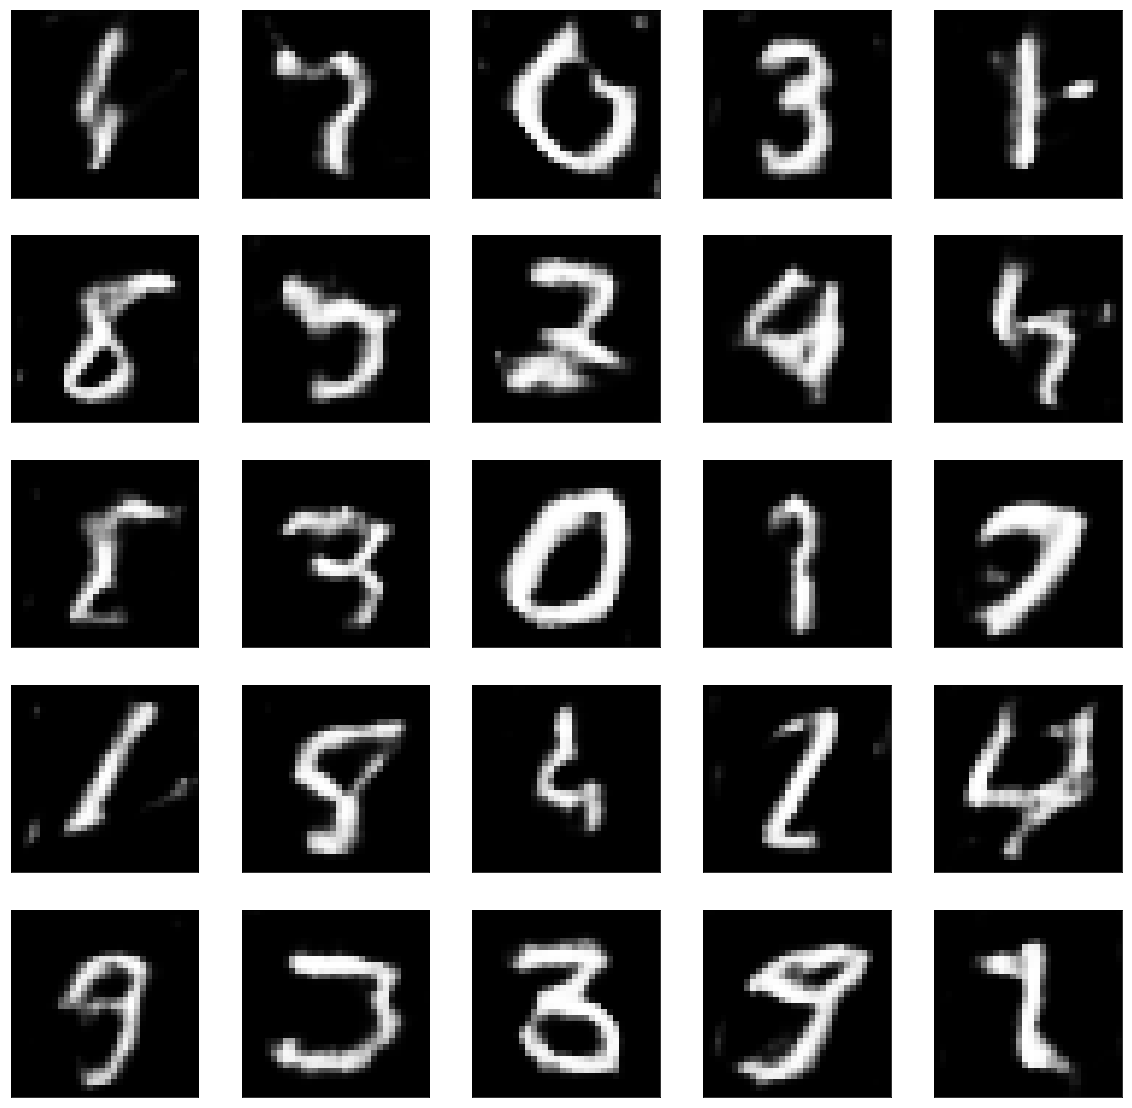

[Epoch 6/10] [Batch 373/938] [Generator loss: 0.875131] [Discriminator loss: 0.545738]
[Epoch 6/10] [Batch 374/938] [Generator loss: 1.129603] [Discriminator loss: 0.536695]
[Epoch 6/10] [Batch 375/938] [Generator loss: 1.157130] [Discriminator loss: 0.531702]
[Epoch 6/10] [Batch 376/938] [Generator loss: 1.062965] [Discriminator loss: 0.685134]
[Epoch 6/10] [Batch 377/938] [Generator loss: 1.149096] [Discriminator loss: 0.453807]
[Epoch 6/10] [Batch 378/938] [Generator loss: 1.072215] [Discriminator loss: 0.736824]
[Epoch 6/10] [Batch 379/938] [Generator loss: 0.839936] [Discriminator loss: 0.484201]
[Epoch 6/10] [Batch 380/938] [Generator loss: 0.812084] [Discriminator loss: 0.658672]
[Epoch 6/10] [Batch 381/938] [Generator loss: 1.289289] [Discriminator loss: 0.602335]
[Epoch 6/10] [Batch 382/938] [Generator loss: 0.591869] [Discriminator loss: 0.697768]
[Epoch 6/10] [Batch 383/938] [Generator loss: 0.706411] [Discriminator loss: 0.470134]
[Epoch 6/10] [Batch 384/938] [Generator los

[Epoch 6/10] [Batch 472/938] [Generator loss: 0.922401] [Discriminator loss: 0.498353]
[Epoch 6/10] [Batch 473/938] [Generator loss: 1.489030] [Discriminator loss: 0.485115]
[Epoch 6/10] [Batch 474/938] [Generator loss: 0.872480] [Discriminator loss: 0.720685]
[Epoch 6/10] [Batch 475/938] [Generator loss: 0.658138] [Discriminator loss: 0.686830]
[Epoch 6/10] [Batch 476/938] [Generator loss: 0.603832] [Discriminator loss: 0.591057]
[Epoch 6/10] [Batch 477/938] [Generator loss: 0.733344] [Discriminator loss: 0.719534]
[Epoch 6/10] [Batch 478/938] [Generator loss: 1.019710] [Discriminator loss: 0.533922]
[Epoch 6/10] [Batch 479/938] [Generator loss: 0.921755] [Discriminator loss: 0.553570]
[Epoch 6/10] [Batch 480/938] [Generator loss: 1.066695] [Discriminator loss: 0.471554]
[Epoch 6/10] [Batch 481/938] [Generator loss: 0.519043] [Discriminator loss: 0.476020]
[Epoch 6/10] [Batch 482/938] [Generator loss: 1.232368] [Discriminator loss: 0.642993]
[Epoch 6/10] [Batch 483/938] [Generator los

[Epoch 6/10] [Batch 573/938] [Generator loss: 0.838999] [Discriminator loss: 0.532320]
[Epoch 6/10] [Batch 574/938] [Generator loss: 1.037688] [Discriminator loss: 0.628473]
[Epoch 6/10] [Batch 575/938] [Generator loss: 1.088884] [Discriminator loss: 0.489858]
[Epoch 6/10] [Batch 576/938] [Generator loss: 1.134724] [Discriminator loss: 0.721765]
[Epoch 6/10] [Batch 577/938] [Generator loss: 1.220082] [Discriminator loss: 0.511702]
[Epoch 6/10] [Batch 578/938] [Generator loss: 0.877866] [Discriminator loss: 0.578539]
[Epoch 6/10] [Batch 579/938] [Generator loss: 0.810128] [Discriminator loss: 0.645995]
[Epoch 6/10] [Batch 580/938] [Generator loss: 0.799771] [Discriminator loss: 0.586977]
[Epoch 6/10] [Batch 581/938] [Generator loss: 1.196697] [Discriminator loss: 0.660734]
[Epoch 6/10] [Batch 582/938] [Generator loss: 1.277662] [Discriminator loss: 0.598234]
[Epoch 6/10] [Batch 583/938] [Generator loss: 1.010189] [Discriminator loss: 0.656725]
[Epoch 6/10] [Batch 584/938] [Generator los

[Epoch 6/10] [Batch 668/938] [Generator loss: 0.991201] [Discriminator loss: 0.590590]
[Epoch 6/10] [Batch 669/938] [Generator loss: 0.735093] [Discriminator loss: 0.521083]
[Epoch 6/10] [Batch 670/938] [Generator loss: 0.927525] [Discriminator loss: 0.506196]
[Epoch 6/10] [Batch 671/938] [Generator loss: 1.198786] [Discriminator loss: 0.579463]
[Epoch 6/10] [Batch 672/938] [Generator loss: 1.036334] [Discriminator loss: 0.644947]
[Epoch 6/10] [Batch 673/938] [Generator loss: 0.668758] [Discriminator loss: 0.645467]
[Epoch 6/10] [Batch 674/938] [Generator loss: 0.724390] [Discriminator loss: 0.411398]
[Epoch 6/10] [Batch 675/938] [Generator loss: 0.996603] [Discriminator loss: 0.602524]
[Epoch 6/10] [Batch 676/938] [Generator loss: 0.903697] [Discriminator loss: 0.730582]
[Epoch 6/10] [Batch 677/938] [Generator loss: 0.866145] [Discriminator loss: 0.609804]
[Epoch 6/10] [Batch 678/938] [Generator loss: 0.962831] [Discriminator loss: 0.547435]
[Epoch 6/10] [Batch 679/938] [Generator los

[Epoch 6/10] [Batch 764/938] [Generator loss: 0.680022] [Discriminator loss: 0.563984]
[Epoch 6/10] [Batch 765/938] [Generator loss: 1.022602] [Discriminator loss: 0.480103]
[Epoch 6/10] [Batch 766/938] [Generator loss: 0.506136] [Discriminator loss: 0.602937]
[Epoch 6/10] [Batch 767/938] [Generator loss: 0.771203] [Discriminator loss: 0.521586]
[Epoch 6/10] [Batch 768/938] [Generator loss: 0.803938] [Discriminator loss: 0.653896]
[Epoch 6/10] [Batch 769/938] [Generator loss: 0.621749] [Discriminator loss: 0.728250]
[Epoch 6/10] [Batch 770/938] [Generator loss: 1.090537] [Discriminator loss: 0.721464]
[Epoch 6/10] [Batch 771/938] [Generator loss: 1.033843] [Discriminator loss: 0.595547]
[Epoch 6/10] [Batch 772/938] [Generator loss: 0.823930] [Discriminator loss: 0.599867]


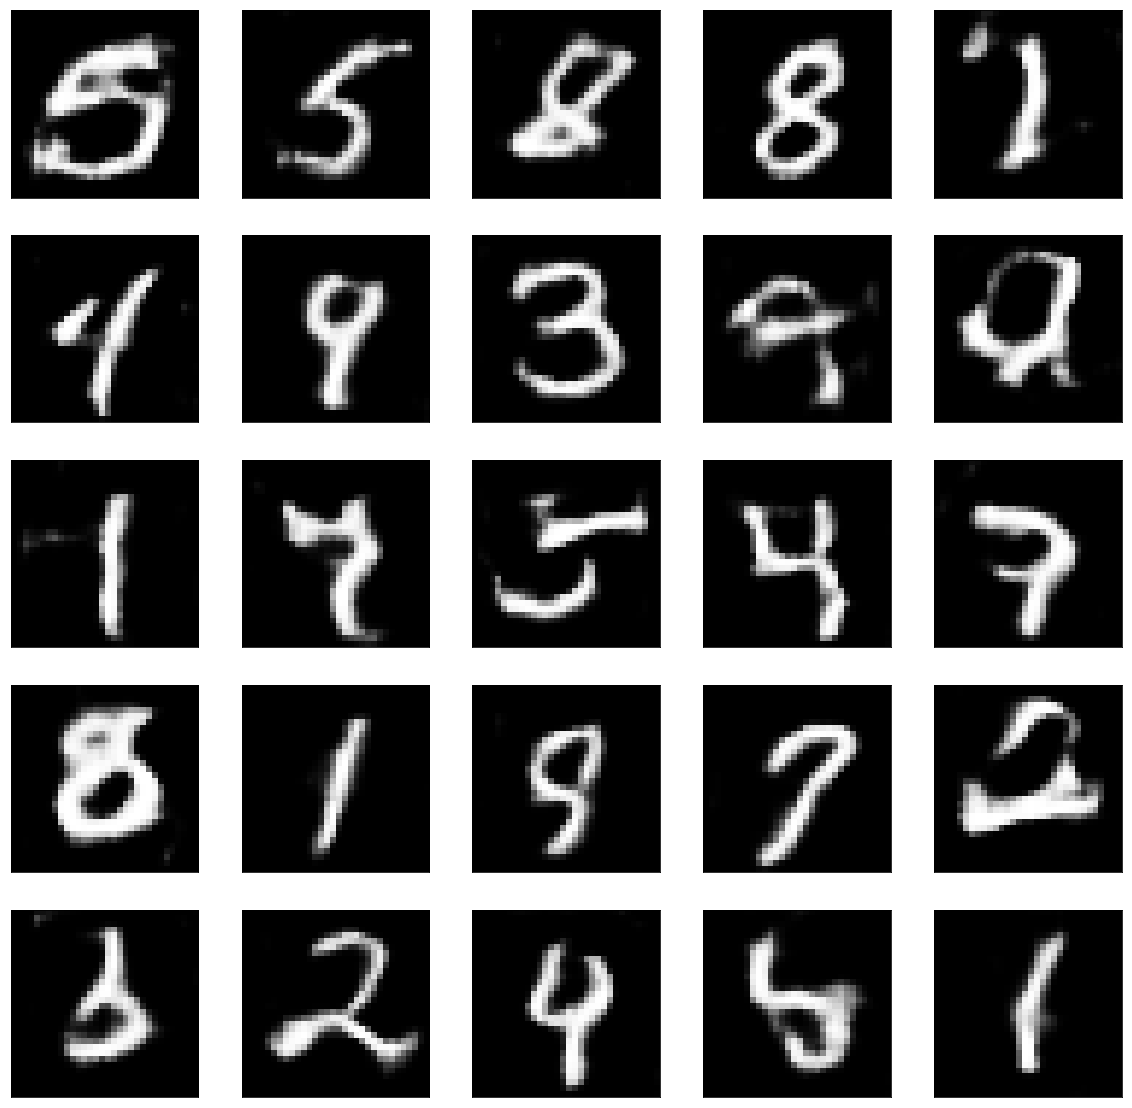

[Epoch 6/10] [Batch 773/938] [Generator loss: 0.593495] [Discriminator loss: 0.500033]
[Epoch 6/10] [Batch 774/938] [Generator loss: 0.958587] [Discriminator loss: 0.710173]
[Epoch 6/10] [Batch 775/938] [Generator loss: 0.659445] [Discriminator loss: 0.838497]
[Epoch 6/10] [Batch 776/938] [Generator loss: 1.192461] [Discriminator loss: 0.548044]
[Epoch 6/10] [Batch 777/938] [Generator loss: 0.962630] [Discriminator loss: 0.555963]
[Epoch 6/10] [Batch 778/938] [Generator loss: 1.664441] [Discriminator loss: 0.477934]
[Epoch 6/10] [Batch 779/938] [Generator loss: 0.934507] [Discriminator loss: 0.541249]
[Epoch 6/10] [Batch 780/938] [Generator loss: 1.175974] [Discriminator loss: 0.378328]
[Epoch 6/10] [Batch 781/938] [Generator loss: 0.907125] [Discriminator loss: 0.631259]
[Epoch 6/10] [Batch 782/938] [Generator loss: 0.693862] [Discriminator loss: 0.507628]
[Epoch 6/10] [Batch 783/938] [Generator loss: 0.965528] [Discriminator loss: 0.580799]
[Epoch 6/10] [Batch 784/938] [Generator los

[Epoch 6/10] [Batch 876/938] [Generator loss: 0.754245] [Discriminator loss: 0.557953]
[Epoch 6/10] [Batch 877/938] [Generator loss: 1.010915] [Discriminator loss: 0.725848]
[Epoch 6/10] [Batch 878/938] [Generator loss: 1.036878] [Discriminator loss: 0.536102]
[Epoch 6/10] [Batch 879/938] [Generator loss: 1.099847] [Discriminator loss: 0.563631]
[Epoch 6/10] [Batch 880/938] [Generator loss: 0.963628] [Discriminator loss: 0.549790]
[Epoch 6/10] [Batch 881/938] [Generator loss: 0.814505] [Discriminator loss: 0.592945]
[Epoch 6/10] [Batch 882/938] [Generator loss: 0.889393] [Discriminator loss: 0.610136]
[Epoch 6/10] [Batch 883/938] [Generator loss: 0.848013] [Discriminator loss: 0.580773]
[Epoch 6/10] [Batch 884/938] [Generator loss: 0.978763] [Discriminator loss: 0.419570]
[Epoch 6/10] [Batch 885/938] [Generator loss: 1.285349] [Discriminator loss: 0.634135]
[Epoch 6/10] [Batch 886/938] [Generator loss: 1.098705] [Discriminator loss: 0.614127]
[Epoch 6/10] [Batch 887/938] [Generator los

[Epoch 7/10] [Batch 40/938] [Generator loss: 1.367279] [Discriminator loss: 0.416666]
[Epoch 7/10] [Batch 41/938] [Generator loss: 0.740293] [Discriminator loss: 0.704197]
[Epoch 7/10] [Batch 42/938] [Generator loss: 1.021456] [Discriminator loss: 0.578235]
[Epoch 7/10] [Batch 43/938] [Generator loss: 0.865076] [Discriminator loss: 0.561199]
[Epoch 7/10] [Batch 44/938] [Generator loss: 1.046745] [Discriminator loss: 0.562965]
[Epoch 7/10] [Batch 45/938] [Generator loss: 0.878580] [Discriminator loss: 0.638375]
[Epoch 7/10] [Batch 46/938] [Generator loss: 1.280951] [Discriminator loss: 0.521682]
[Epoch 7/10] [Batch 47/938] [Generator loss: 0.635463] [Discriminator loss: 0.779680]
[Epoch 7/10] [Batch 48/938] [Generator loss: 0.908287] [Discriminator loss: 0.759320]
[Epoch 7/10] [Batch 49/938] [Generator loss: 1.023075] [Discriminator loss: 0.671126]
[Epoch 7/10] [Batch 50/938] [Generator loss: 1.216035] [Discriminator loss: 0.660347]
[Epoch 7/10] [Batch 51/938] [Generator loss: 0.906189]

[Epoch 7/10] [Batch 135/938] [Generator loss: 1.199086] [Discriminator loss: 0.429994]
[Epoch 7/10] [Batch 136/938] [Generator loss: 0.615056] [Discriminator loss: 0.446631]
[Epoch 7/10] [Batch 137/938] [Generator loss: 0.512296] [Discriminator loss: 0.597539]
[Epoch 7/10] [Batch 138/938] [Generator loss: 0.841574] [Discriminator loss: 0.509337]
[Epoch 7/10] [Batch 139/938] [Generator loss: 0.788470] [Discriminator loss: 0.568028]
[Epoch 7/10] [Batch 140/938] [Generator loss: 1.057738] [Discriminator loss: 0.554901]
[Epoch 7/10] [Batch 141/938] [Generator loss: 1.454064] [Discriminator loss: 0.517348]
[Epoch 7/10] [Batch 142/938] [Generator loss: 0.835124] [Discriminator loss: 0.494784]
[Epoch 7/10] [Batch 143/938] [Generator loss: 1.027842] [Discriminator loss: 0.406123]
[Epoch 7/10] [Batch 144/938] [Generator loss: 0.758921] [Discriminator loss: 0.688238]
[Epoch 7/10] [Batch 145/938] [Generator loss: 0.665429] [Discriminator loss: 0.594874]
[Epoch 7/10] [Batch 146/938] [Generator los

[Epoch 7/10] [Batch 231/938] [Generator loss: 0.973282] [Discriminator loss: 0.509203]
[Epoch 7/10] [Batch 232/938] [Generator loss: 1.103988] [Discriminator loss: 0.411954]
[Epoch 7/10] [Batch 233/938] [Generator loss: 1.568829] [Discriminator loss: 0.503632]
[Epoch 7/10] [Batch 234/938] [Generator loss: 1.409559] [Discriminator loss: 0.677942]


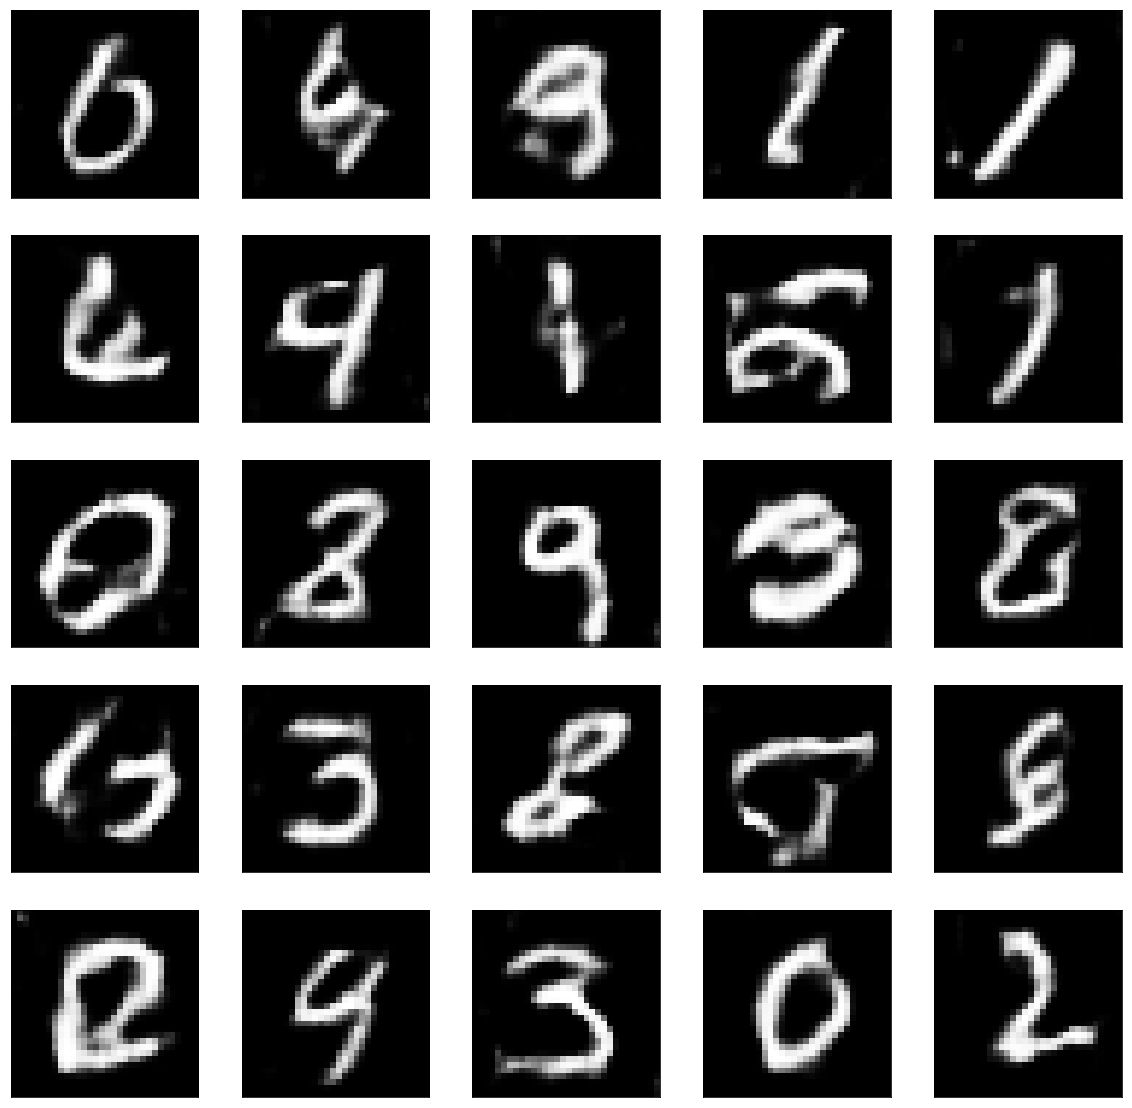

[Epoch 7/10] [Batch 235/938] [Generator loss: 0.733765] [Discriminator loss: 0.639636]
[Epoch 7/10] [Batch 236/938] [Generator loss: 0.963861] [Discriminator loss: 0.689945]
[Epoch 7/10] [Batch 237/938] [Generator loss: 1.496709] [Discriminator loss: 0.453669]
[Epoch 7/10] [Batch 238/938] [Generator loss: 1.182571] [Discriminator loss: 0.549139]
[Epoch 7/10] [Batch 239/938] [Generator loss: 0.925157] [Discriminator loss: 0.532217]
[Epoch 7/10] [Batch 240/938] [Generator loss: 1.312498] [Discriminator loss: 0.557451]
[Epoch 7/10] [Batch 241/938] [Generator loss: 0.955970] [Discriminator loss: 0.505911]
[Epoch 7/10] [Batch 242/938] [Generator loss: 0.759023] [Discriminator loss: 0.571725]
[Epoch 7/10] [Batch 243/938] [Generator loss: 0.790627] [Discriminator loss: 0.665188]
[Epoch 7/10] [Batch 244/938] [Generator loss: 0.634548] [Discriminator loss: 0.533292]
[Epoch 7/10] [Batch 245/938] [Generator loss: 0.775318] [Discriminator loss: 0.470284]
[Epoch 7/10] [Batch 246/938] [Generator los

[Epoch 7/10] [Batch 332/938] [Generator loss: 1.633046] [Discriminator loss: 0.510244]
[Epoch 7/10] [Batch 333/938] [Generator loss: 1.195416] [Discriminator loss: 0.464587]
[Epoch 7/10] [Batch 334/938] [Generator loss: 0.847689] [Discriminator loss: 0.602373]
[Epoch 7/10] [Batch 335/938] [Generator loss: 0.851534] [Discriminator loss: 0.515608]
[Epoch 7/10] [Batch 336/938] [Generator loss: 1.269318] [Discriminator loss: 0.376757]
[Epoch 7/10] [Batch 337/938] [Generator loss: 0.653584] [Discriminator loss: 0.639315]
[Epoch 7/10] [Batch 338/938] [Generator loss: 0.859123] [Discriminator loss: 0.592990]
[Epoch 7/10] [Batch 339/938] [Generator loss: 0.897954] [Discriminator loss: 0.611628]
[Epoch 7/10] [Batch 340/938] [Generator loss: 1.272856] [Discriminator loss: 0.643587]
[Epoch 7/10] [Batch 341/938] [Generator loss: 1.283437] [Discriminator loss: 0.491697]
[Epoch 7/10] [Batch 342/938] [Generator loss: 1.100532] [Discriminator loss: 0.543967]
[Epoch 7/10] [Batch 343/938] [Generator los

[Epoch 7/10] [Batch 431/938] [Generator loss: 0.887009] [Discriminator loss: 0.995253]
[Epoch 7/10] [Batch 432/938] [Generator loss: 1.010305] [Discriminator loss: 0.583410]
[Epoch 7/10] [Batch 433/938] [Generator loss: 0.732061] [Discriminator loss: 0.423922]
[Epoch 7/10] [Batch 434/938] [Generator loss: 0.886636] [Discriminator loss: 0.512801]
[Epoch 7/10] [Batch 435/938] [Generator loss: 0.986015] [Discriminator loss: 0.652859]
[Epoch 7/10] [Batch 436/938] [Generator loss: 1.454776] [Discriminator loss: 0.584681]
[Epoch 7/10] [Batch 437/938] [Generator loss: 0.905547] [Discriminator loss: 0.736637]
[Epoch 7/10] [Batch 438/938] [Generator loss: 0.819102] [Discriminator loss: 0.517252]
[Epoch 7/10] [Batch 439/938] [Generator loss: 1.130155] [Discriminator loss: 0.660550]
[Epoch 7/10] [Batch 440/938] [Generator loss: 1.072266] [Discriminator loss: 0.542879]
[Epoch 7/10] [Batch 441/938] [Generator loss: 1.003170] [Discriminator loss: 0.575885]
[Epoch 7/10] [Batch 442/938] [Generator los

[Epoch 7/10] [Batch 529/938] [Generator loss: 1.079852] [Discriminator loss: 0.500722]
[Epoch 7/10] [Batch 530/938] [Generator loss: 0.888879] [Discriminator loss: 0.457009]
[Epoch 7/10] [Batch 531/938] [Generator loss: 0.654166] [Discriminator loss: 0.648837]
[Epoch 7/10] [Batch 532/938] [Generator loss: 0.866142] [Discriminator loss: 0.769198]
[Epoch 7/10] [Batch 533/938] [Generator loss: 1.136195] [Discriminator loss: 0.578226]
[Epoch 7/10] [Batch 534/938] [Generator loss: 0.724583] [Discriminator loss: 0.636606]
[Epoch 7/10] [Batch 535/938] [Generator loss: 1.181564] [Discriminator loss: 0.612780]
[Epoch 7/10] [Batch 536/938] [Generator loss: 1.084137] [Discriminator loss: 0.682061]
[Epoch 7/10] [Batch 537/938] [Generator loss: 0.843551] [Discriminator loss: 0.486549]
[Epoch 7/10] [Batch 538/938] [Generator loss: 1.123643] [Discriminator loss: 0.650580]
[Epoch 7/10] [Batch 539/938] [Generator loss: 1.264175] [Discriminator loss: 0.552654]
[Epoch 7/10] [Batch 540/938] [Generator los

[Epoch 7/10] [Batch 624/938] [Generator loss: 0.540090] [Discriminator loss: 0.800589]
[Epoch 7/10] [Batch 625/938] [Generator loss: 1.007348] [Discriminator loss: 0.475347]
[Epoch 7/10] [Batch 626/938] [Generator loss: 1.452810] [Discriminator loss: 0.603247]
[Epoch 7/10] [Batch 627/938] [Generator loss: 0.695066] [Discriminator loss: 0.627305]
[Epoch 7/10] [Batch 628/938] [Generator loss: 1.218005] [Discriminator loss: 0.641090]
[Epoch 7/10] [Batch 629/938] [Generator loss: 1.136067] [Discriminator loss: 0.491664]
[Epoch 7/10] [Batch 630/938] [Generator loss: 0.755330] [Discriminator loss: 0.693170]
[Epoch 7/10] [Batch 631/938] [Generator loss: 0.605415] [Discriminator loss: 0.521701]
[Epoch 7/10] [Batch 632/938] [Generator loss: 1.079454] [Discriminator loss: 0.538429]
[Epoch 7/10] [Batch 633/938] [Generator loss: 0.725368] [Discriminator loss: 0.588244]
[Epoch 7/10] [Batch 634/938] [Generator loss: 0.991048] [Discriminator loss: 0.510285]


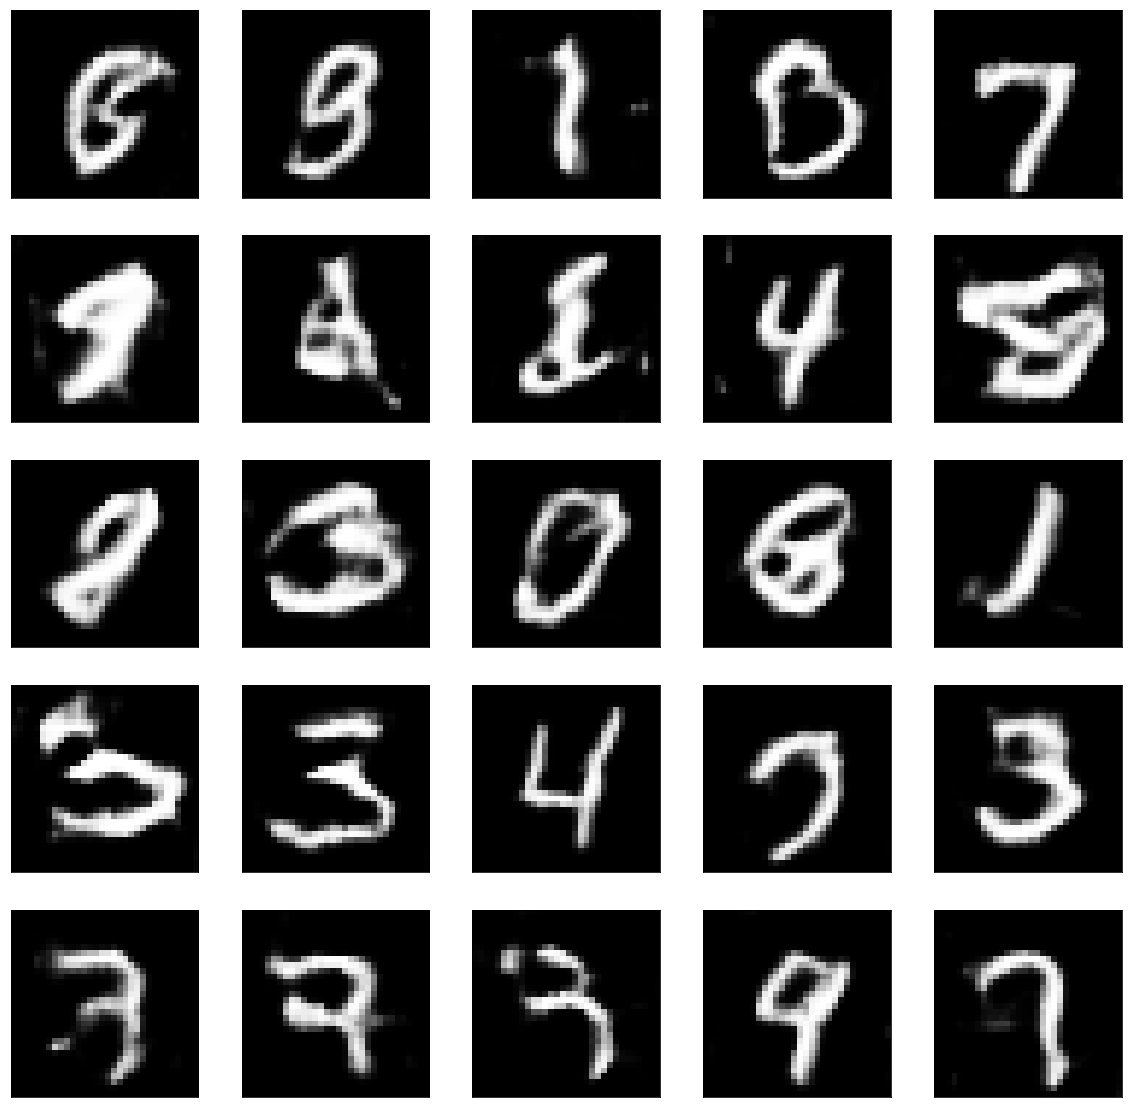

[Epoch 7/10] [Batch 635/938] [Generator loss: 0.927154] [Discriminator loss: 0.491193]
[Epoch 7/10] [Batch 636/938] [Generator loss: 0.870757] [Discriminator loss: 0.659661]
[Epoch 7/10] [Batch 637/938] [Generator loss: 0.837345] [Discriminator loss: 0.551688]
[Epoch 7/10] [Batch 638/938] [Generator loss: 0.903694] [Discriminator loss: 0.774033]
[Epoch 7/10] [Batch 639/938] [Generator loss: 0.430561] [Discriminator loss: 0.444865]
[Epoch 7/10] [Batch 640/938] [Generator loss: 0.929039] [Discriminator loss: 0.619509]
[Epoch 7/10] [Batch 641/938] [Generator loss: 0.968951] [Discriminator loss: 0.588498]
[Epoch 7/10] [Batch 642/938] [Generator loss: 0.787411] [Discriminator loss: 0.465247]
[Epoch 7/10] [Batch 643/938] [Generator loss: 1.322895] [Discriminator loss: 0.638983]
[Epoch 7/10] [Batch 644/938] [Generator loss: 0.607619] [Discriminator loss: 0.630159]
[Epoch 7/10] [Batch 645/938] [Generator loss: 1.038804] [Discriminator loss: 0.719883]
[Epoch 7/10] [Batch 646/938] [Generator los

[Epoch 7/10] [Batch 731/938] [Generator loss: 0.641498] [Discriminator loss: 0.748775]
[Epoch 7/10] [Batch 732/938] [Generator loss: 1.114305] [Discriminator loss: 0.629125]
[Epoch 7/10] [Batch 733/938] [Generator loss: 0.725641] [Discriminator loss: 0.601180]
[Epoch 7/10] [Batch 734/938] [Generator loss: 1.119854] [Discriminator loss: 0.641177]
[Epoch 7/10] [Batch 735/938] [Generator loss: 0.640656] [Discriminator loss: 0.594270]
[Epoch 7/10] [Batch 736/938] [Generator loss: 0.708848] [Discriminator loss: 0.508235]
[Epoch 7/10] [Batch 737/938] [Generator loss: 0.822067] [Discriminator loss: 0.621284]
[Epoch 7/10] [Batch 738/938] [Generator loss: 1.189027] [Discriminator loss: 0.461291]
[Epoch 7/10] [Batch 739/938] [Generator loss: 0.994357] [Discriminator loss: 0.554951]
[Epoch 7/10] [Batch 740/938] [Generator loss: 0.612125] [Discriminator loss: 0.520609]
[Epoch 7/10] [Batch 741/938] [Generator loss: 0.929529] [Discriminator loss: 0.464702]
[Epoch 7/10] [Batch 742/938] [Generator los

[Epoch 7/10] [Batch 827/938] [Generator loss: 0.674434] [Discriminator loss: 0.439237]
[Epoch 7/10] [Batch 828/938] [Generator loss: 0.820071] [Discriminator loss: 0.621387]
[Epoch 7/10] [Batch 829/938] [Generator loss: 1.286793] [Discriminator loss: 0.589537]
[Epoch 7/10] [Batch 830/938] [Generator loss: 0.750235] [Discriminator loss: 0.398010]
[Epoch 7/10] [Batch 831/938] [Generator loss: 1.107398] [Discriminator loss: 0.605931]
[Epoch 7/10] [Batch 832/938] [Generator loss: 1.134335] [Discriminator loss: 0.509172]
[Epoch 7/10] [Batch 833/938] [Generator loss: 0.952382] [Discriminator loss: 0.573642]
[Epoch 7/10] [Batch 834/938] [Generator loss: 0.946007] [Discriminator loss: 0.523108]
[Epoch 7/10] [Batch 835/938] [Generator loss: 0.649234] [Discriminator loss: 0.556302]
[Epoch 7/10] [Batch 836/938] [Generator loss: 1.362395] [Discriminator loss: 0.608657]
[Epoch 7/10] [Batch 837/938] [Generator loss: 0.833224] [Discriminator loss: 0.425720]
[Epoch 7/10] [Batch 838/938] [Generator los

[Epoch 7/10] [Batch 928/938] [Generator loss: 1.553849] [Discriminator loss: 0.504581]
[Epoch 7/10] [Batch 929/938] [Generator loss: 1.530888] [Discriminator loss: 0.419451]
[Epoch 7/10] [Batch 930/938] [Generator loss: 1.045863] [Discriminator loss: 0.476682]
[Epoch 7/10] [Batch 931/938] [Generator loss: 0.864287] [Discriminator loss: 0.525215]
[Epoch 7/10] [Batch 932/938] [Generator loss: 1.114780] [Discriminator loss: 0.596208]
[Epoch 7/10] [Batch 933/938] [Generator loss: 1.426149] [Discriminator loss: 0.569318]
[Epoch 7/10] [Batch 934/938] [Generator loss: 0.886174] [Discriminator loss: 0.561408]
[Epoch 7/10] [Batch 935/938] [Generator loss: 0.837440] [Discriminator loss: 0.569005]
[Epoch 7/10] [Batch 936/938] [Generator loss: 0.592708] [Discriminator loss: 0.448599]
[Epoch 7/10] [Batch 937/938] [Generator loss: 0.751630] [Discriminator loss: 0.560337]
[Epoch 8/10] [Batch 0/938] [Generator loss: 0.652468] [Discriminator loss: 0.686680]
[Epoch 8/10] [Batch 1/938] [Generator loss: 1

[Epoch 8/10] [Batch 91/938] [Generator loss: 1.269366] [Discriminator loss: 0.790000]
[Epoch 8/10] [Batch 92/938] [Generator loss: 0.914559] [Discriminator loss: 0.440498]
[Epoch 8/10] [Batch 93/938] [Generator loss: 1.220677] [Discriminator loss: 0.466710]
[Epoch 8/10] [Batch 94/938] [Generator loss: 0.869185] [Discriminator loss: 0.608552]
[Epoch 8/10] [Batch 95/938] [Generator loss: 0.607491] [Discriminator loss: 0.533582]
[Epoch 8/10] [Batch 96/938] [Generator loss: 0.976468] [Discriminator loss: 0.592495]


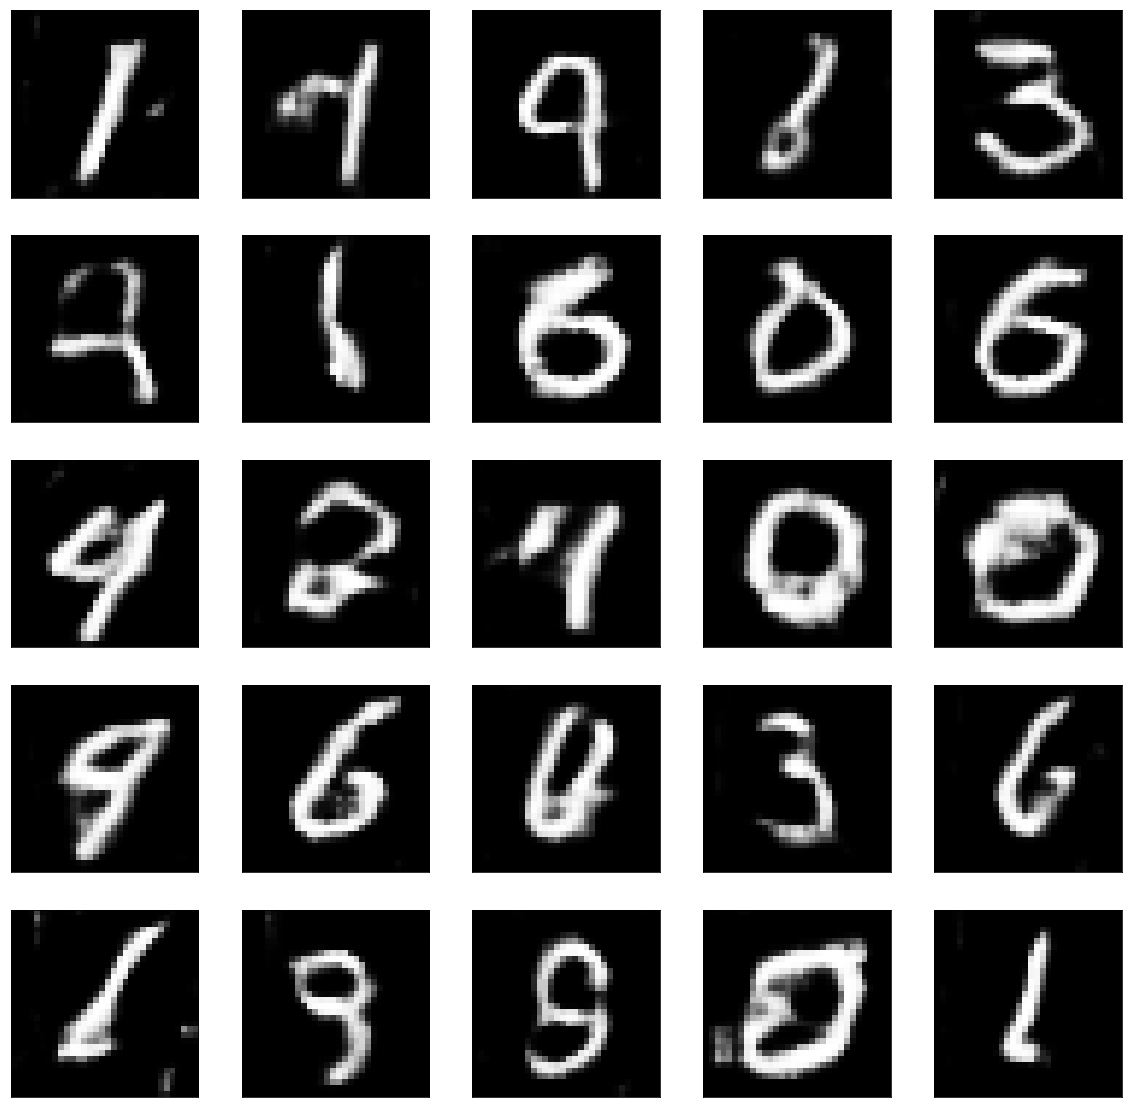

[Epoch 8/10] [Batch 97/938] [Generator loss: 1.185854] [Discriminator loss: 0.541649]
[Epoch 8/10] [Batch 98/938] [Generator loss: 0.785178] [Discriminator loss: 0.575035]
[Epoch 8/10] [Batch 99/938] [Generator loss: 0.773425] [Discriminator loss: 0.637532]
[Epoch 8/10] [Batch 100/938] [Generator loss: 0.643249] [Discriminator loss: 0.674623]
[Epoch 8/10] [Batch 101/938] [Generator loss: 0.768636] [Discriminator loss: 0.667261]
[Epoch 8/10] [Batch 102/938] [Generator loss: 0.744780] [Discriminator loss: 0.554877]
[Epoch 8/10] [Batch 103/938] [Generator loss: 0.924315] [Discriminator loss: 0.419792]
[Epoch 8/10] [Batch 104/938] [Generator loss: 1.361539] [Discriminator loss: 0.560879]
[Epoch 8/10] [Batch 105/938] [Generator loss: 1.328345] [Discriminator loss: 0.416956]
[Epoch 8/10] [Batch 106/938] [Generator loss: 1.165634] [Discriminator loss: 0.523196]
[Epoch 8/10] [Batch 107/938] [Generator loss: 0.789909] [Discriminator loss: 0.445551]
[Epoch 8/10] [Batch 108/938] [Generator loss: 

[Epoch 8/10] [Batch 196/938] [Generator loss: 1.421756] [Discriminator loss: 0.597543]
[Epoch 8/10] [Batch 197/938] [Generator loss: 1.220020] [Discriminator loss: 0.571375]
[Epoch 8/10] [Batch 198/938] [Generator loss: 1.026878] [Discriminator loss: 0.700074]
[Epoch 8/10] [Batch 199/938] [Generator loss: 1.001887] [Discriminator loss: 0.638359]
[Epoch 8/10] [Batch 200/938] [Generator loss: 0.867262] [Discriminator loss: 0.629397]
[Epoch 8/10] [Batch 201/938] [Generator loss: 0.947903] [Discriminator loss: 0.627047]
[Epoch 8/10] [Batch 202/938] [Generator loss: 1.209192] [Discriminator loss: 0.385309]
[Epoch 8/10] [Batch 203/938] [Generator loss: 1.159773] [Discriminator loss: 0.437918]
[Epoch 8/10] [Batch 204/938] [Generator loss: 0.918810] [Discriminator loss: 0.459980]
[Epoch 8/10] [Batch 205/938] [Generator loss: 0.917184] [Discriminator loss: 0.460697]
[Epoch 8/10] [Batch 206/938] [Generator loss: 1.030169] [Discriminator loss: 0.656294]
[Epoch 8/10] [Batch 207/938] [Generator los

[Epoch 8/10] [Batch 293/938] [Generator loss: 0.785624] [Discriminator loss: 0.589907]
[Epoch 8/10] [Batch 294/938] [Generator loss: 1.485423] [Discriminator loss: 0.388858]
[Epoch 8/10] [Batch 295/938] [Generator loss: 1.395017] [Discriminator loss: 0.545195]
[Epoch 8/10] [Batch 296/938] [Generator loss: 1.323532] [Discriminator loss: 0.569203]
[Epoch 8/10] [Batch 297/938] [Generator loss: 0.998911] [Discriminator loss: 0.579011]
[Epoch 8/10] [Batch 298/938] [Generator loss: 0.658167] [Discriminator loss: 0.604347]
[Epoch 8/10] [Batch 299/938] [Generator loss: 1.421584] [Discriminator loss: 0.430032]
[Epoch 8/10] [Batch 300/938] [Generator loss: 1.299986] [Discriminator loss: 0.558659]
[Epoch 8/10] [Batch 301/938] [Generator loss: 1.187823] [Discriminator loss: 0.586205]
[Epoch 8/10] [Batch 302/938] [Generator loss: 0.935142] [Discriminator loss: 0.606488]
[Epoch 8/10] [Batch 303/938] [Generator loss: 1.235717] [Discriminator loss: 0.433164]
[Epoch 8/10] [Batch 304/938] [Generator los

[Epoch 8/10] [Batch 389/938] [Generator loss: 1.162455] [Discriminator loss: 0.727167]
[Epoch 8/10] [Batch 390/938] [Generator loss: 0.997232] [Discriminator loss: 0.561471]
[Epoch 8/10] [Batch 391/938] [Generator loss: 1.633382] [Discriminator loss: 0.656136]
[Epoch 8/10] [Batch 392/938] [Generator loss: 0.814900] [Discriminator loss: 0.555212]
[Epoch 8/10] [Batch 393/938] [Generator loss: 0.876944] [Discriminator loss: 0.739103]
[Epoch 8/10] [Batch 394/938] [Generator loss: 0.399867] [Discriminator loss: 0.635266]
[Epoch 8/10] [Batch 395/938] [Generator loss: 1.194957] [Discriminator loss: 0.457414]
[Epoch 8/10] [Batch 396/938] [Generator loss: 1.194709] [Discriminator loss: 0.473896]
[Epoch 8/10] [Batch 397/938] [Generator loss: 0.882415] [Discriminator loss: 0.567839]
[Epoch 8/10] [Batch 398/938] [Generator loss: 1.000837] [Discriminator loss: 0.613473]
[Epoch 8/10] [Batch 399/938] [Generator loss: 1.185172] [Discriminator loss: 0.666655]
[Epoch 8/10] [Batch 400/938] [Generator los

[Epoch 8/10] [Batch 484/938] [Generator loss: 0.717889] [Discriminator loss: 0.466276]
[Epoch 8/10] [Batch 485/938] [Generator loss: 1.001113] [Discriminator loss: 0.513582]
[Epoch 8/10] [Batch 486/938] [Generator loss: 1.167640] [Discriminator loss: 0.694821]
[Epoch 8/10] [Batch 487/938] [Generator loss: 0.882724] [Discriminator loss: 0.478019]
[Epoch 8/10] [Batch 488/938] [Generator loss: 0.629363] [Discriminator loss: 0.608376]
[Epoch 8/10] [Batch 489/938] [Generator loss: 0.765911] [Discriminator loss: 0.471998]
[Epoch 8/10] [Batch 490/938] [Generator loss: 1.209143] [Discriminator loss: 0.507288]
[Epoch 8/10] [Batch 491/938] [Generator loss: 0.841474] [Discriminator loss: 0.452457]
[Epoch 8/10] [Batch 492/938] [Generator loss: 0.915089] [Discriminator loss: 0.382475]
[Epoch 8/10] [Batch 493/938] [Generator loss: 0.821815] [Discriminator loss: 0.470083]
[Epoch 8/10] [Batch 494/938] [Generator loss: 0.821848] [Discriminator loss: 0.607242]
[Epoch 8/10] [Batch 495/938] [Generator los

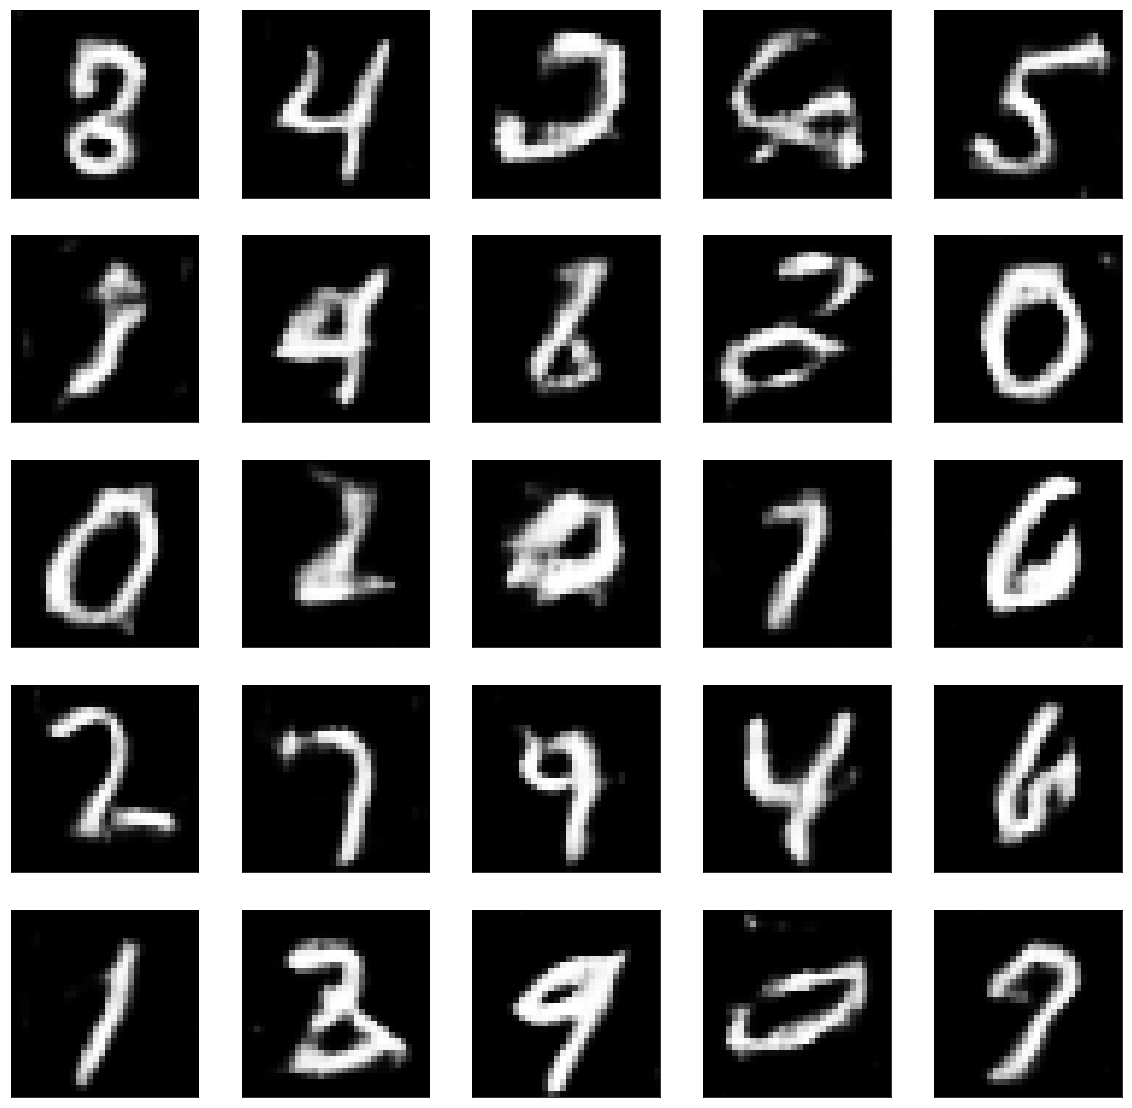

[Epoch 8/10] [Batch 497/938] [Generator loss: 0.816104] [Discriminator loss: 0.869658]
[Epoch 8/10] [Batch 498/938] [Generator loss: 1.086341] [Discriminator loss: 0.468881]
[Epoch 8/10] [Batch 499/938] [Generator loss: 0.933689] [Discriminator loss: 0.513625]
[Epoch 8/10] [Batch 500/938] [Generator loss: 0.984512] [Discriminator loss: 0.528124]
[Epoch 8/10] [Batch 501/938] [Generator loss: 1.371711] [Discriminator loss: 0.480110]
[Epoch 8/10] [Batch 502/938] [Generator loss: 0.901233] [Discriminator loss: 0.383679]
[Epoch 8/10] [Batch 503/938] [Generator loss: 0.733087] [Discriminator loss: 0.437674]
[Epoch 8/10] [Batch 504/938] [Generator loss: 1.230082] [Discriminator loss: 0.656682]
[Epoch 8/10] [Batch 505/938] [Generator loss: 0.921645] [Discriminator loss: 0.493691]
[Epoch 8/10] [Batch 506/938] [Generator loss: 0.688635] [Discriminator loss: 0.569160]
[Epoch 8/10] [Batch 507/938] [Generator loss: 0.672532] [Discriminator loss: 0.420172]
[Epoch 8/10] [Batch 508/938] [Generator los

[Epoch 8/10] [Batch 595/938] [Generator loss: 1.046500] [Discriminator loss: 0.613056]
[Epoch 8/10] [Batch 596/938] [Generator loss: 0.755226] [Discriminator loss: 0.600321]
[Epoch 8/10] [Batch 597/938] [Generator loss: 1.764373] [Discriminator loss: 0.531699]
[Epoch 8/10] [Batch 598/938] [Generator loss: 1.189279] [Discriminator loss: 0.587169]
[Epoch 8/10] [Batch 599/938] [Generator loss: 0.966180] [Discriminator loss: 0.546399]
[Epoch 8/10] [Batch 600/938] [Generator loss: 0.821315] [Discriminator loss: 0.503870]
[Epoch 8/10] [Batch 601/938] [Generator loss: 1.501047] [Discriminator loss: 0.562210]
[Epoch 8/10] [Batch 602/938] [Generator loss: 0.954213] [Discriminator loss: 0.417513]
[Epoch 8/10] [Batch 603/938] [Generator loss: 1.114404] [Discriminator loss: 0.814417]
[Epoch 8/10] [Batch 604/938] [Generator loss: 0.987338] [Discriminator loss: 0.623925]
[Epoch 8/10] [Batch 605/938] [Generator loss: 0.830468] [Discriminator loss: 0.523918]
[Epoch 8/10] [Batch 606/938] [Generator los

[Epoch 8/10] [Batch 697/938] [Generator loss: 0.897400] [Discriminator loss: 0.623044]
[Epoch 8/10] [Batch 698/938] [Generator loss: 0.592184] [Discriminator loss: 0.647476]
[Epoch 8/10] [Batch 699/938] [Generator loss: 0.871432] [Discriminator loss: 0.674274]
[Epoch 8/10] [Batch 700/938] [Generator loss: 0.535875] [Discriminator loss: 0.419310]
[Epoch 8/10] [Batch 701/938] [Generator loss: 0.786999] [Discriminator loss: 0.689559]
[Epoch 8/10] [Batch 702/938] [Generator loss: 0.692819] [Discriminator loss: 0.517354]
[Epoch 8/10] [Batch 703/938] [Generator loss: 1.103096] [Discriminator loss: 0.590968]
[Epoch 8/10] [Batch 704/938] [Generator loss: 1.160010] [Discriminator loss: 0.432295]
[Epoch 8/10] [Batch 705/938] [Generator loss: 1.213741] [Discriminator loss: 0.600588]
[Epoch 8/10] [Batch 706/938] [Generator loss: 0.895919] [Discriminator loss: 0.542380]
[Epoch 8/10] [Batch 707/938] [Generator loss: 0.830480] [Discriminator loss: 0.482759]
[Epoch 8/10] [Batch 708/938] [Generator los

[Epoch 8/10] [Batch 793/938] [Generator loss: 1.236349] [Discriminator loss: 0.778843]
[Epoch 8/10] [Batch 794/938] [Generator loss: 1.111646] [Discriminator loss: 0.444706]
[Epoch 8/10] [Batch 795/938] [Generator loss: 1.007015] [Discriminator loss: 0.598814]
[Epoch 8/10] [Batch 796/938] [Generator loss: 1.079792] [Discriminator loss: 0.703546]
[Epoch 8/10] [Batch 797/938] [Generator loss: 0.838634] [Discriminator loss: 0.591542]
[Epoch 8/10] [Batch 798/938] [Generator loss: 0.659315] [Discriminator loss: 0.707521]
[Epoch 8/10] [Batch 799/938] [Generator loss: 0.936607] [Discriminator loss: 0.666278]
[Epoch 8/10] [Batch 800/938] [Generator loss: 1.216263] [Discriminator loss: 0.525672]
[Epoch 8/10] [Batch 801/938] [Generator loss: 0.957638] [Discriminator loss: 0.522384]
[Epoch 8/10] [Batch 802/938] [Generator loss: 0.707226] [Discriminator loss: 0.669056]
[Epoch 8/10] [Batch 803/938] [Generator loss: 0.847280] [Discriminator loss: 0.563221]
[Epoch 8/10] [Batch 804/938] [Generator los

[Epoch 8/10] [Batch 891/938] [Generator loss: 0.720780] [Discriminator loss: 0.443731]
[Epoch 8/10] [Batch 892/938] [Generator loss: 1.195921] [Discriminator loss: 0.573204]
[Epoch 8/10] [Batch 893/938] [Generator loss: 0.749102] [Discriminator loss: 0.510459]
[Epoch 8/10] [Batch 894/938] [Generator loss: 1.371042] [Discriminator loss: 0.570818]
[Epoch 8/10] [Batch 895/938] [Generator loss: 0.765354] [Discriminator loss: 0.320674]
[Epoch 8/10] [Batch 896/938] [Generator loss: 1.449307] [Discriminator loss: 0.420850]


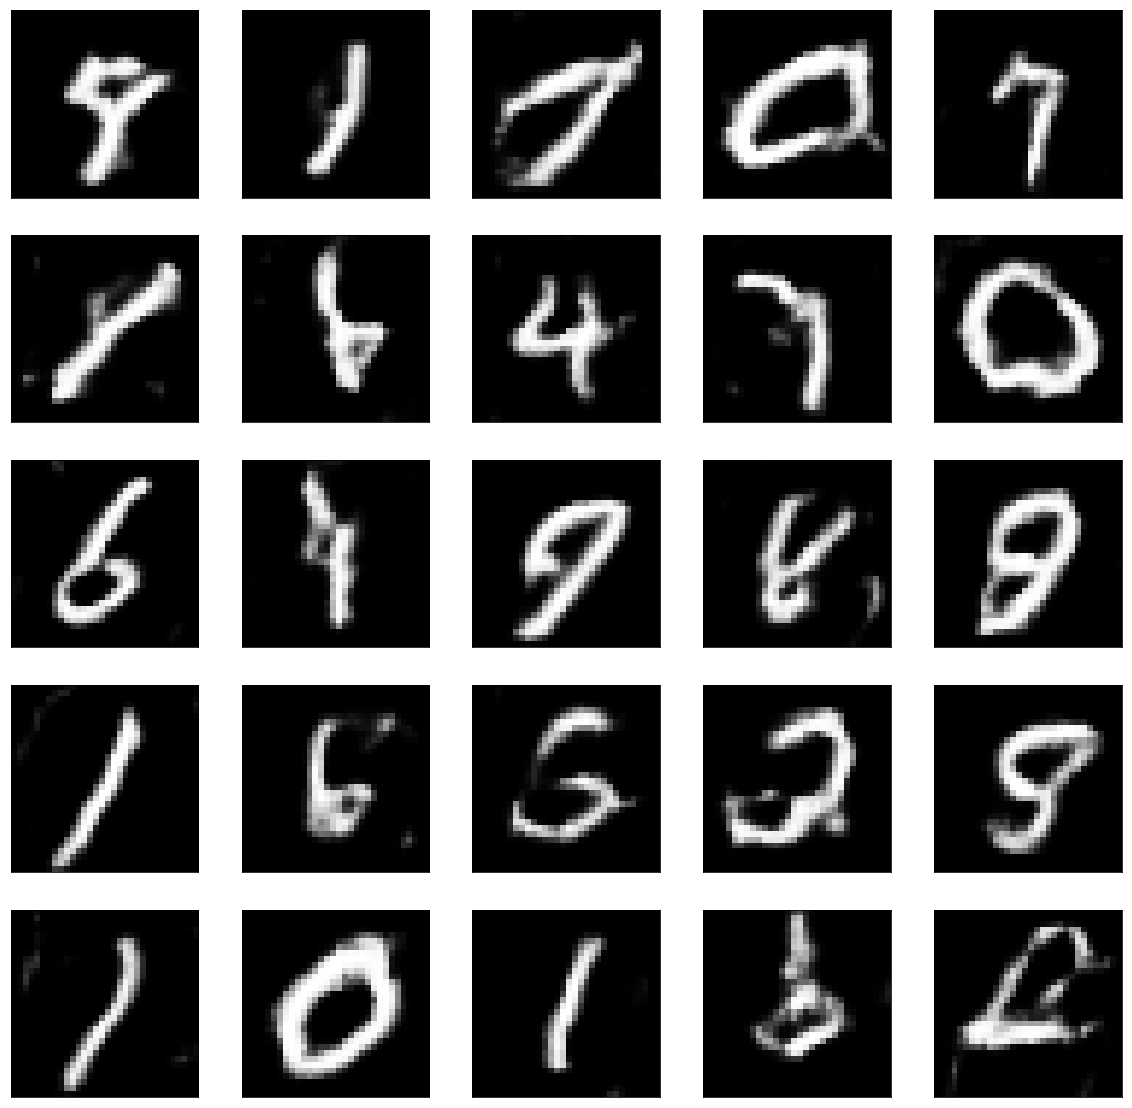

[Epoch 8/10] [Batch 897/938] [Generator loss: 1.268671] [Discriminator loss: 0.692697]
[Epoch 8/10] [Batch 898/938] [Generator loss: 0.751883] [Discriminator loss: 0.636597]
[Epoch 8/10] [Batch 899/938] [Generator loss: 0.676458] [Discriminator loss: 0.591972]
[Epoch 8/10] [Batch 900/938] [Generator loss: 0.883322] [Discriminator loss: 0.527726]
[Epoch 8/10] [Batch 901/938] [Generator loss: 0.637266] [Discriminator loss: 0.438853]
[Epoch 8/10] [Batch 902/938] [Generator loss: 0.709539] [Discriminator loss: 0.425824]
[Epoch 8/10] [Batch 903/938] [Generator loss: 1.102368] [Discriminator loss: 0.545521]
[Epoch 8/10] [Batch 904/938] [Generator loss: 1.135225] [Discriminator loss: 0.512217]
[Epoch 8/10] [Batch 905/938] [Generator loss: 0.729140] [Discriminator loss: 0.580284]
[Epoch 8/10] [Batch 906/938] [Generator loss: 0.936825] [Discriminator loss: 0.474277]
[Epoch 8/10] [Batch 907/938] [Generator loss: 1.028912] [Discriminator loss: 0.597673]
[Epoch 8/10] [Batch 908/938] [Generator los

[Epoch 9/10] [Batch 57/938] [Generator loss: 0.995151] [Discriminator loss: 0.495453]
[Epoch 9/10] [Batch 58/938] [Generator loss: 1.411965] [Discriminator loss: 0.397677]
[Epoch 9/10] [Batch 59/938] [Generator loss: 1.165307] [Discriminator loss: 0.676302]
[Epoch 9/10] [Batch 60/938] [Generator loss: 1.233359] [Discriminator loss: 0.649887]
[Epoch 9/10] [Batch 61/938] [Generator loss: 0.898796] [Discriminator loss: 0.423639]
[Epoch 9/10] [Batch 62/938] [Generator loss: 0.765556] [Discriminator loss: 0.738774]
[Epoch 9/10] [Batch 63/938] [Generator loss: 1.056355] [Discriminator loss: 0.623965]
[Epoch 9/10] [Batch 64/938] [Generator loss: 1.027520] [Discriminator loss: 0.297202]
[Epoch 9/10] [Batch 65/938] [Generator loss: 0.904717] [Discriminator loss: 0.494928]
[Epoch 9/10] [Batch 66/938] [Generator loss: 1.249170] [Discriminator loss: 0.443255]
[Epoch 9/10] [Batch 67/938] [Generator loss: 1.052645] [Discriminator loss: 0.581124]
[Epoch 9/10] [Batch 68/938] [Generator loss: 0.687618]

[Epoch 9/10] [Batch 152/938] [Generator loss: 0.714860] [Discriminator loss: 0.578072]
[Epoch 9/10] [Batch 153/938] [Generator loss: 1.110053] [Discriminator loss: 0.536414]
[Epoch 9/10] [Batch 154/938] [Generator loss: 1.172212] [Discriminator loss: 0.505783]
[Epoch 9/10] [Batch 155/938] [Generator loss: 1.160982] [Discriminator loss: 0.654585]
[Epoch 9/10] [Batch 156/938] [Generator loss: 1.556236] [Discriminator loss: 0.463551]
[Epoch 9/10] [Batch 157/938] [Generator loss: 0.986104] [Discriminator loss: 0.649304]
[Epoch 9/10] [Batch 158/938] [Generator loss: 1.207837] [Discriminator loss: 0.638658]
[Epoch 9/10] [Batch 159/938] [Generator loss: 0.773106] [Discriminator loss: 0.709807]
[Epoch 9/10] [Batch 160/938] [Generator loss: 0.637410] [Discriminator loss: 0.626584]
[Epoch 9/10] [Batch 161/938] [Generator loss: 0.893220] [Discriminator loss: 0.608341]
[Epoch 9/10] [Batch 162/938] [Generator loss: 1.060719] [Discriminator loss: 0.453415]
[Epoch 9/10] [Batch 163/938] [Generator los

[Epoch 9/10] [Batch 252/938] [Generator loss: 0.997212] [Discriminator loss: 0.873149]
[Epoch 9/10] [Batch 253/938] [Generator loss: 0.719965] [Discriminator loss: 0.544105]
[Epoch 9/10] [Batch 254/938] [Generator loss: 0.800223] [Discriminator loss: 0.716066]
[Epoch 9/10] [Batch 255/938] [Generator loss: 0.570352] [Discriminator loss: 0.566597]
[Epoch 9/10] [Batch 256/938] [Generator loss: 0.725753] [Discriminator loss: 0.391896]
[Epoch 9/10] [Batch 257/938] [Generator loss: 0.778680] [Discriminator loss: 0.513872]
[Epoch 9/10] [Batch 258/938] [Generator loss: 0.800614] [Discriminator loss: 0.483229]
[Epoch 9/10] [Batch 259/938] [Generator loss: 0.876469] [Discriminator loss: 0.473783]
[Epoch 9/10] [Batch 260/938] [Generator loss: 0.873903] [Discriminator loss: 0.605409]
[Epoch 9/10] [Batch 261/938] [Generator loss: 0.622634] [Discriminator loss: 0.661970]
[Epoch 9/10] [Batch 262/938] [Generator loss: 1.183175] [Discriminator loss: 0.509140]
[Epoch 9/10] [Batch 263/938] [Generator los

[Epoch 9/10] [Batch 349/938] [Generator loss: 1.107981] [Discriminator loss: 0.710704]
[Epoch 9/10] [Batch 350/938] [Generator loss: 0.934256] [Discriminator loss: 0.482562]
[Epoch 9/10] [Batch 351/938] [Generator loss: 0.689059] [Discriminator loss: 0.493392]
[Epoch 9/10] [Batch 352/938] [Generator loss: 0.811310] [Discriminator loss: 0.655022]
[Epoch 9/10] [Batch 353/938] [Generator loss: 1.115269] [Discriminator loss: 0.454203]
[Epoch 9/10] [Batch 354/938] [Generator loss: 1.045507] [Discriminator loss: 0.603254]
[Epoch 9/10] [Batch 355/938] [Generator loss: 0.931143] [Discriminator loss: 0.583130]
[Epoch 9/10] [Batch 356/938] [Generator loss: 1.369138] [Discriminator loss: 0.519456]
[Epoch 9/10] [Batch 357/938] [Generator loss: 0.879854] [Discriminator loss: 0.652327]
[Epoch 9/10] [Batch 358/938] [Generator loss: 0.851493] [Discriminator loss: 0.750151]


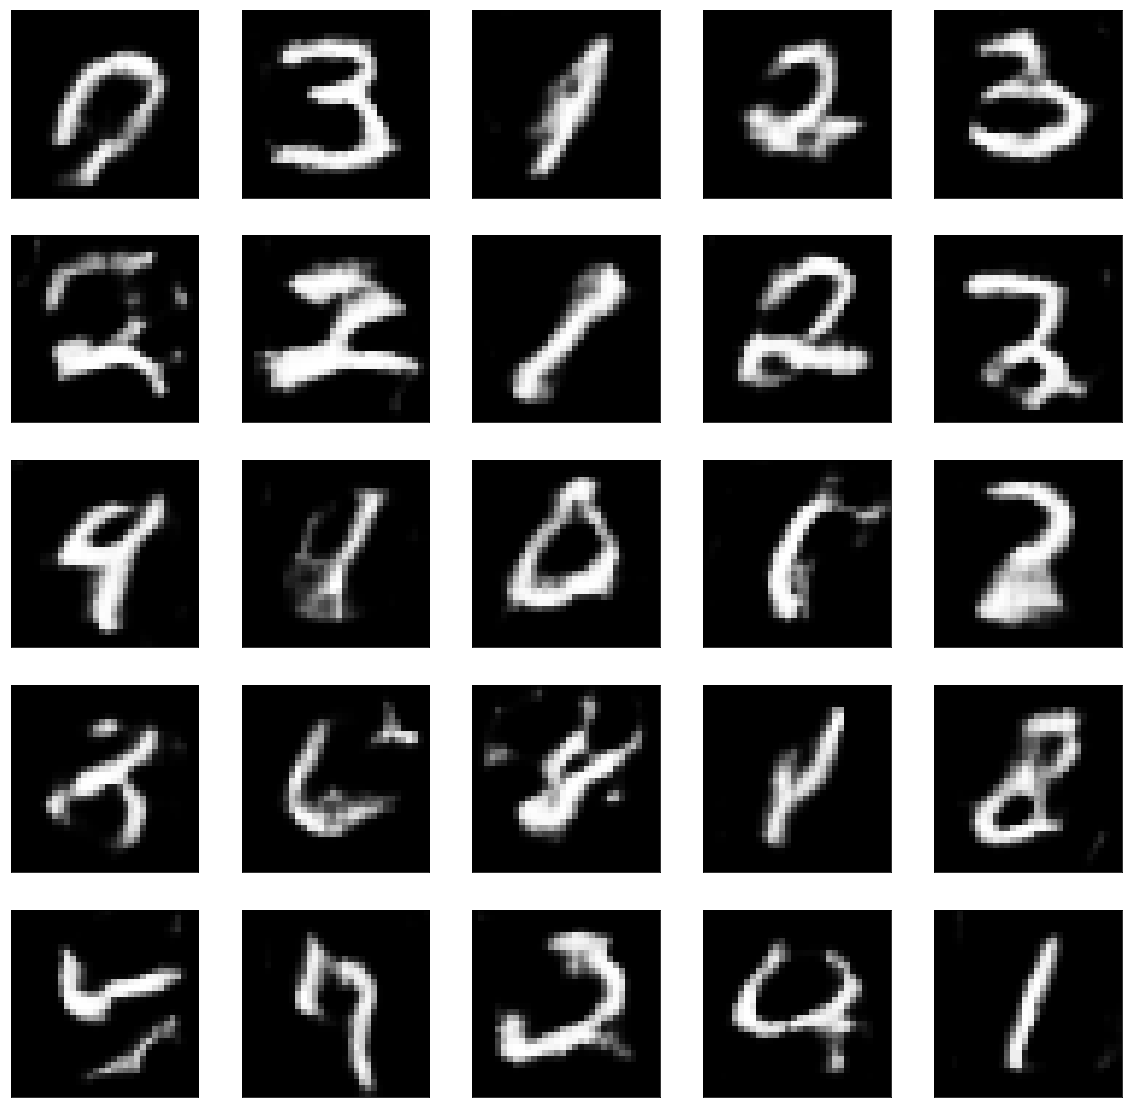

[Epoch 9/10] [Batch 359/938] [Generator loss: 0.955030] [Discriminator loss: 0.534314]
[Epoch 9/10] [Batch 360/938] [Generator loss: 1.046412] [Discriminator loss: 0.381751]
[Epoch 9/10] [Batch 361/938] [Generator loss: 1.488483] [Discriminator loss: 0.632686]
[Epoch 9/10] [Batch 362/938] [Generator loss: 1.247165] [Discriminator loss: 0.586477]
[Epoch 9/10] [Batch 363/938] [Generator loss: 0.794927] [Discriminator loss: 0.442818]
[Epoch 9/10] [Batch 364/938] [Generator loss: 0.964978] [Discriminator loss: 0.500993]
[Epoch 9/10] [Batch 365/938] [Generator loss: 0.889468] [Discriminator loss: 0.489564]
[Epoch 9/10] [Batch 366/938] [Generator loss: 0.877878] [Discriminator loss: 0.679893]
[Epoch 9/10] [Batch 367/938] [Generator loss: 1.238445] [Discriminator loss: 0.532864]
[Epoch 9/10] [Batch 368/938] [Generator loss: 1.121941] [Discriminator loss: 0.587080]
[Epoch 9/10] [Batch 369/938] [Generator loss: 0.832895] [Discriminator loss: 0.536811]
[Epoch 9/10] [Batch 370/938] [Generator los

[Epoch 9/10] [Batch 457/938] [Generator loss: 0.721049] [Discriminator loss: 0.630041]
[Epoch 9/10] [Batch 458/938] [Generator loss: 0.758039] [Discriminator loss: 0.491515]
[Epoch 9/10] [Batch 459/938] [Generator loss: 0.715835] [Discriminator loss: 0.656026]
[Epoch 9/10] [Batch 460/938] [Generator loss: 0.705117] [Discriminator loss: 0.747828]
[Epoch 9/10] [Batch 461/938] [Generator loss: 1.092282] [Discriminator loss: 0.406625]
[Epoch 9/10] [Batch 462/938] [Generator loss: 1.092399] [Discriminator loss: 0.677039]
[Epoch 9/10] [Batch 463/938] [Generator loss: 1.594826] [Discriminator loss: 0.659252]
[Epoch 9/10] [Batch 464/938] [Generator loss: 1.279274] [Discriminator loss: 0.533179]
[Epoch 9/10] [Batch 465/938] [Generator loss: 0.793752] [Discriminator loss: 0.601786]
[Epoch 9/10] [Batch 466/938] [Generator loss: 0.506809] [Discriminator loss: 0.585226]
[Epoch 9/10] [Batch 467/938] [Generator loss: 0.774336] [Discriminator loss: 0.527864]
[Epoch 9/10] [Batch 468/938] [Generator los

[Epoch 9/10] [Batch 560/938] [Generator loss: 0.918364] [Discriminator loss: 0.529764]
[Epoch 9/10] [Batch 561/938] [Generator loss: 1.428138] [Discriminator loss: 0.553843]
[Epoch 9/10] [Batch 562/938] [Generator loss: 0.708786] [Discriminator loss: 0.710692]
[Epoch 9/10] [Batch 563/938] [Generator loss: 0.505768] [Discriminator loss: 0.572260]
[Epoch 9/10] [Batch 564/938] [Generator loss: 1.182695] [Discriminator loss: 0.637824]
[Epoch 9/10] [Batch 565/938] [Generator loss: 1.277450] [Discriminator loss: 0.683972]
[Epoch 9/10] [Batch 566/938] [Generator loss: 1.144028] [Discriminator loss: 0.587980]
[Epoch 9/10] [Batch 567/938] [Generator loss: 1.232298] [Discriminator loss: 0.440603]
[Epoch 9/10] [Batch 568/938] [Generator loss: 0.954907] [Discriminator loss: 0.476968]
[Epoch 9/10] [Batch 569/938] [Generator loss: 1.000770] [Discriminator loss: 0.517372]
[Epoch 9/10] [Batch 570/938] [Generator loss: 1.012255] [Discriminator loss: 0.494643]
[Epoch 9/10] [Batch 571/938] [Generator los

[Epoch 9/10] [Batch 662/938] [Generator loss: 1.175694] [Discriminator loss: 0.504854]
[Epoch 9/10] [Batch 663/938] [Generator loss: 0.675550] [Discriminator loss: 0.449458]
[Epoch 9/10] [Batch 664/938] [Generator loss: 0.854957] [Discriminator loss: 0.591894]
[Epoch 9/10] [Batch 665/938] [Generator loss: 0.455998] [Discriminator loss: 0.560217]
[Epoch 9/10] [Batch 666/938] [Generator loss: 1.254105] [Discriminator loss: 0.456915]
[Epoch 9/10] [Batch 667/938] [Generator loss: 0.749030] [Discriminator loss: 0.506349]
[Epoch 9/10] [Batch 668/938] [Generator loss: 0.733703] [Discriminator loss: 0.786171]
[Epoch 9/10] [Batch 669/938] [Generator loss: 1.184931] [Discriminator loss: 0.349838]
[Epoch 9/10] [Batch 670/938] [Generator loss: 1.316528] [Discriminator loss: 0.425555]
[Epoch 9/10] [Batch 671/938] [Generator loss: 1.550854] [Discriminator loss: 0.631105]
[Epoch 9/10] [Batch 672/938] [Generator loss: 1.125939] [Discriminator loss: 0.612716]
[Epoch 9/10] [Batch 673/938] [Generator los

[Epoch 9/10] [Batch 757/938] [Generator loss: 0.866649] [Discriminator loss: 0.624926]
[Epoch 9/10] [Batch 758/938] [Generator loss: 1.082077] [Discriminator loss: 0.636881]


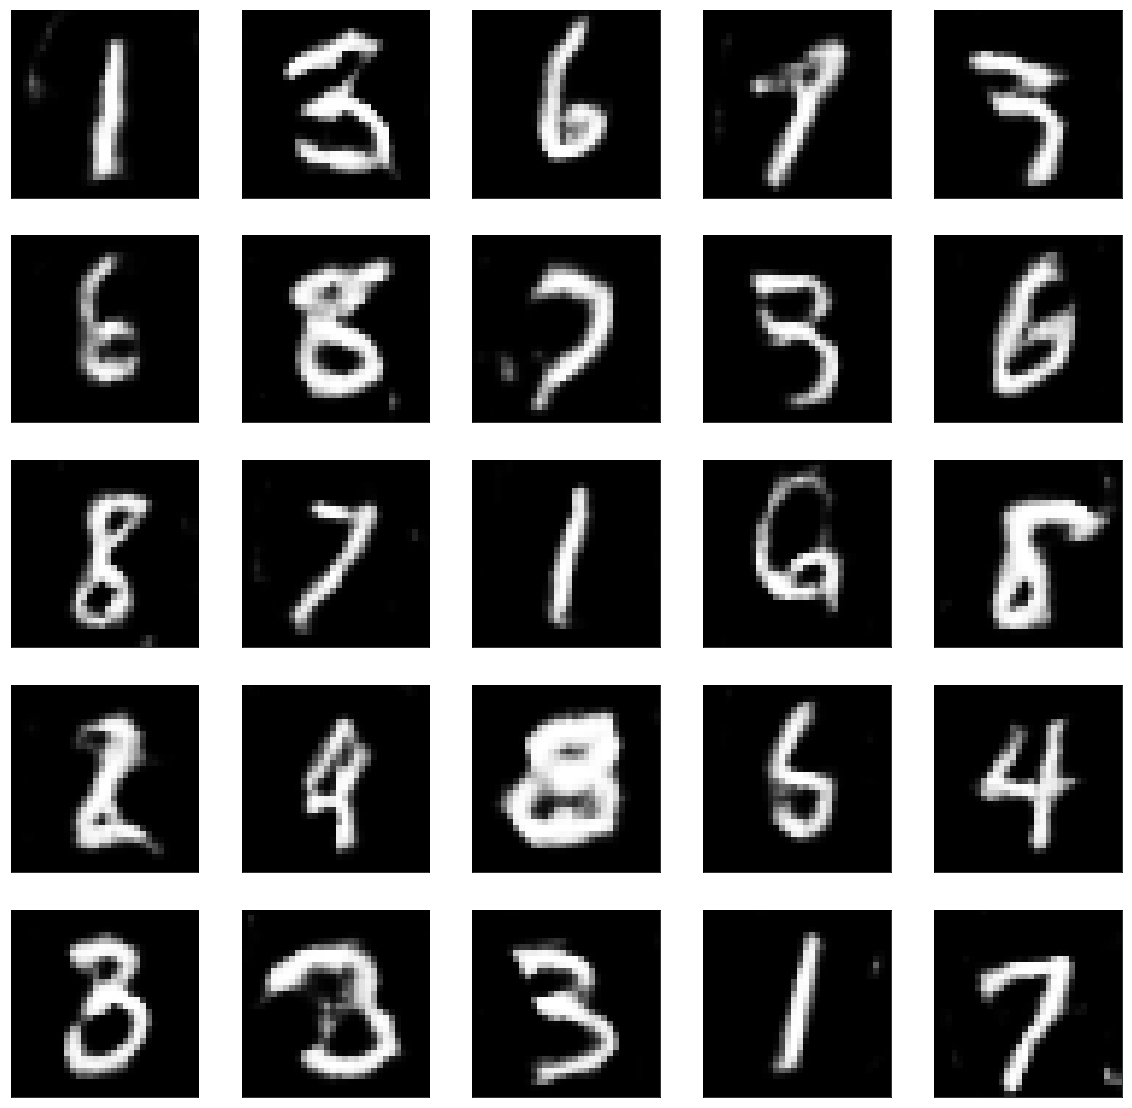

[Epoch 9/10] [Batch 759/938] [Generator loss: 1.157463] [Discriminator loss: 0.412258]
[Epoch 9/10] [Batch 760/938] [Generator loss: 1.363621] [Discriminator loss: 0.553434]
[Epoch 9/10] [Batch 761/938] [Generator loss: 0.705344] [Discriminator loss: 0.543011]
[Epoch 9/10] [Batch 762/938] [Generator loss: 1.142670] [Discriminator loss: 0.544464]
[Epoch 9/10] [Batch 763/938] [Generator loss: 1.062500] [Discriminator loss: 0.748209]
[Epoch 9/10] [Batch 764/938] [Generator loss: 1.124655] [Discriminator loss: 0.476781]
[Epoch 9/10] [Batch 765/938] [Generator loss: 1.829435] [Discriminator loss: 0.553759]
[Epoch 9/10] [Batch 766/938] [Generator loss: 0.976259] [Discriminator loss: 0.440346]
[Epoch 9/10] [Batch 767/938] [Generator loss: 0.877503] [Discriminator loss: 0.614421]
[Epoch 9/10] [Batch 768/938] [Generator loss: 0.579521] [Discriminator loss: 0.559331]
[Epoch 9/10] [Batch 769/938] [Generator loss: 1.050245] [Discriminator loss: 0.468617]
[Epoch 9/10] [Batch 770/938] [Generator los

[Epoch 9/10] [Batch 854/938] [Generator loss: 0.674509] [Discriminator loss: 0.550740]
[Epoch 9/10] [Batch 855/938] [Generator loss: 0.493731] [Discriminator loss: 0.484475]
[Epoch 9/10] [Batch 856/938] [Generator loss: 0.931586] [Discriminator loss: 0.586428]
[Epoch 9/10] [Batch 857/938] [Generator loss: 2.038216] [Discriminator loss: 0.811413]
[Epoch 9/10] [Batch 858/938] [Generator loss: 0.899142] [Discriminator loss: 0.412724]
[Epoch 9/10] [Batch 859/938] [Generator loss: 1.129478] [Discriminator loss: 0.624364]
[Epoch 9/10] [Batch 860/938] [Generator loss: 0.959589] [Discriminator loss: 0.498729]
[Epoch 9/10] [Batch 861/938] [Generator loss: 1.034431] [Discriminator loss: 0.702958]
[Epoch 9/10] [Batch 862/938] [Generator loss: 0.827180] [Discriminator loss: 0.558090]
[Epoch 9/10] [Batch 863/938] [Generator loss: 0.935892] [Discriminator loss: 0.567670]
[Epoch 9/10] [Batch 864/938] [Generator loss: 0.760483] [Discriminator loss: 0.445989]
[Epoch 9/10] [Batch 865/938] [Generator los

In [19]:
g_loss_to_display = []
d_loss_to_display = []
    
for epoch in range(n_epochs):
    for i, (imgs, _) in enumerate(data_loader):
        
        # adversarial ground truths
        valid = Variable(Tensor(imgs.shape[0], 1).fill_(1.0), requires_grad=False)
        fake = Variable(Tensor(imgs.shape[0], 1).fill_(0.0), requires_grad=False)
        
        # configure input
        real_imgs = Variable(imgs.type(Tensor))
        
        # ----------------
        # Train Generator
        # ----------------
        
        optimizer_G.zero_grad()
        
        # sample noise as generator input
        z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], latent_dim))))
        
        # generate a batch of images
        gen_imgs = generator(z)
        
        # loss measures the generator's ability to fool the discriminator
        # print(imgs.shape)
        # print(gen_imgs.shape)
        # break
        g_loss = adversarial_loss(discriminator(gen_imgs), valid)
        g_loss.backward()
        
        optimizer_G.step()
        
        # ---------------------
        #  Train Discriminator
        # ---------------------
        
        optimizer_D.zero_grad()
        
        # measure the discriminator's ability to classify real from generated samples
        real_loss = adversarial_loss(discriminator(real_imgs), valid)
        fake_loss = adversarial_loss(discriminator(gen_imgs.detach()), fake)
        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        
        optimizer_D.step()
        
        print(
            "[Epoch %d/%d] [Batch %d/%d] [Generator loss: %f] [Discriminator loss: %f]"
            % (epoch, n_epochs, i, len(data_loader), g_loss.item(), d_loss.item())
        )
        
        # save losses for plotting later
        g_loss_to_display.append(g_loss.item())
        d_loss_to_display.append(d_loss.item())
        
        batches_done = epoch * len(data_loader) + i
        
        if batches_done % sample_interval == 0:
            gen_imgs_to_display = np.transpose(gen_imgs[:25].cpu().detach(), (0, 2, 3, 1))
            
            # display 25 generated images in one batch and save it
            imshow(gen_imgs_to_display)
            save_image(gen_imgs.data[:25], "images/dcgan/%d.png" % batches_done, nrow=5, normalize=True)

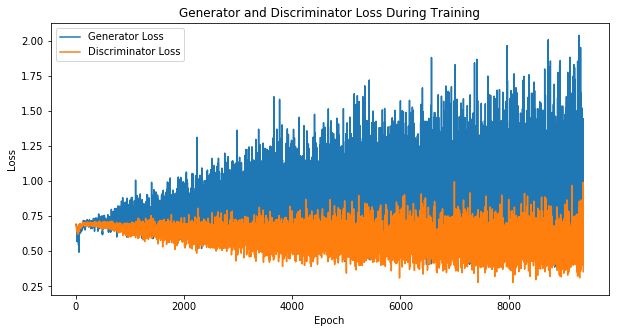

In [23]:
# plot g_loss and d_loss
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(g_loss_to_display, label='Generator Loss')
plt.plot(d_loss_to_display, label='Discriminator Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.savefig('./images/dcgan/final_loss.png')
plt.show()

## Final GAN Images

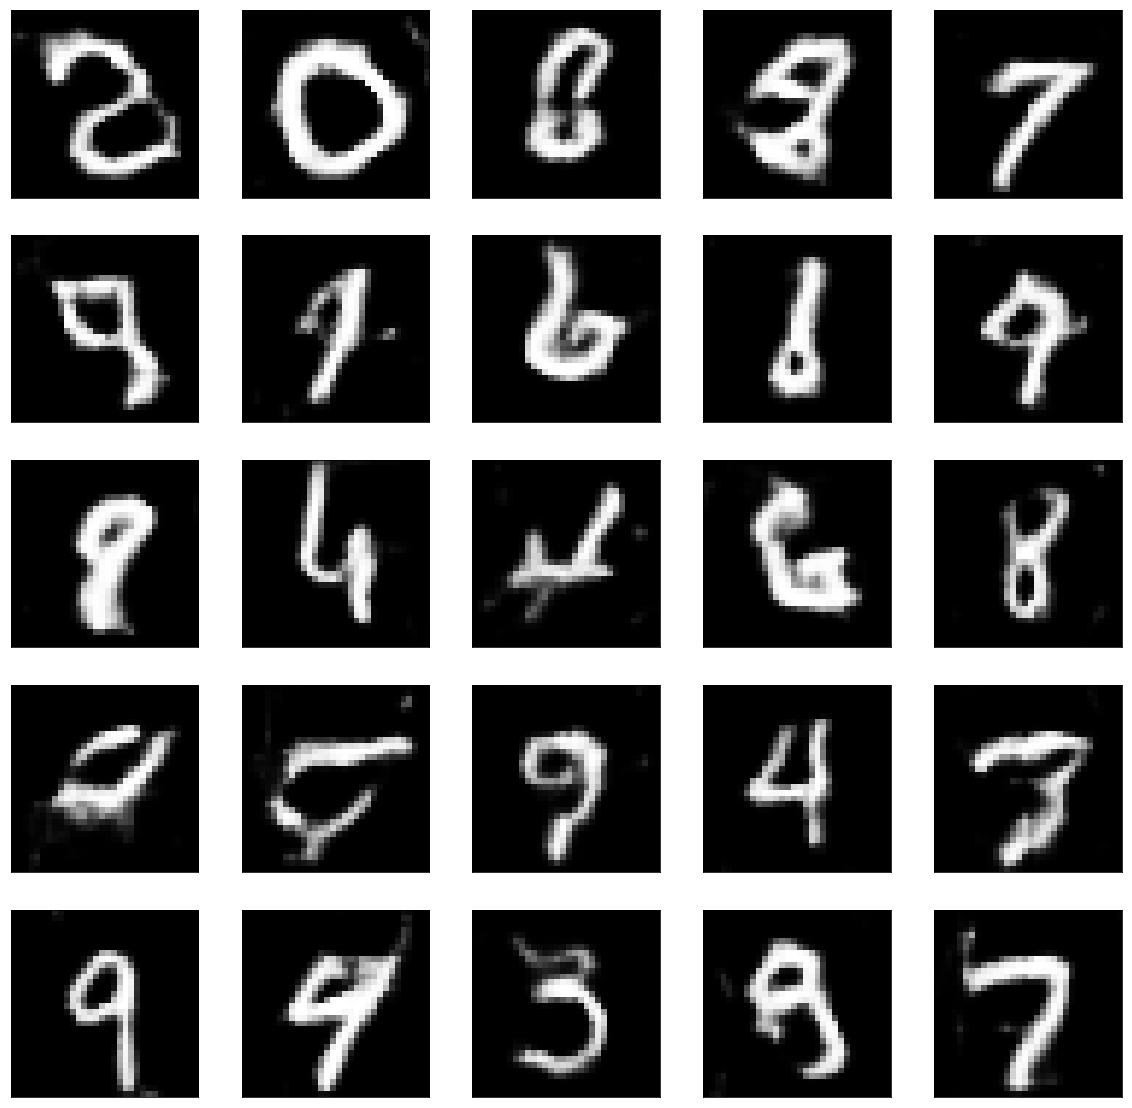

In [21]:
# obtain one batch of test images
dataiter = iter(data_loader)
imgs, _ = dataiter.next()

# sample noise as generator input
z = Variable(Tensor(np.random.normal(0, 1, (imgs.shape[0], latent_dim))))

# generate a batch of images
gen_imgs = generator(z)
gen_imgs_to_display = np.transpose(gen_imgs[:25].cpu().detach(), (0, 2, 3, 1))

# show and save these final images
imshow(gen_imgs_to_display)

---